In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
#fakes_suffix = 'SMOTE_train_test_80-20_min14_kneighbors8'
fakes_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

# num=3039 #5000
# n_classes=11 #12
# n_epochs=4000 #500
# #fakes_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
# #fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
# #fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
# # fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'
# fakes_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'

suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{fakes_suffix}"

dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

In [4]:
# # Try CVAE without None class for train and test
# dataset_bank_tns_df_resampled_train = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train['tns_cls'] != 'None']
# dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']

# Try CVAE with None class for train and test
dataset_bank_tns_df_resampled_train = dataset_bank_tns_df_resampled_train
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test

In [5]:
dataset_bank_tns_df_resampled_train

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc91973,0.648056,0.438369,0.306405,0.000000,0.350863,1.296113,1.132292,0.416165,2.372943,-0.013326,...,0.502309,0.721143,0.811645,0.579434,39.665981,0.019535,Fake,TDE,-99.00000,None
ZTFabc46594,0.486110,0.605627,0.258561,0.017279,0.317578,0.937265,0.604629,0.378644,0.566701,-0.007330,...,-0.059388,-0.053494,-0.067460,-0.116639,8.221067,0.055221,Fake,TDE,-99.00000,None
ZTFabc20988,0.447717,0.433476,0.428571,0.000000,0.403265,0.895435,0.820801,0.547785,-0.871551,0.005264,...,0.466027,0.127562,0.206142,0.121683,2.985047,0.021310,Fake,TDE,-99.00000,None


In [6]:
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20aaybwth,0.384511,0.549172,0.250000,0.125000,0.324167,0.769022,0.619796,0.227901,3.039816,-0.000004,...,0.065300,0.089100,0.114300,0.066299,18.578022,0.023904,Yes_TNS,None,-99.00000,ZTF
ZTF21abhvfrj,0.477448,1.131876,0.090909,0.090909,0.329433,0.954895,0.633796,0.214027,5.379689,-0.001774,...,0.904800,1.048300,0.646000,-3.536699,11.699969,0.344573,Yes_TNS,None,-99.00000,ALeRCE
ZTF20acngnvf,0.221461,0.330890,0.235294,0.058824,0.311743,0.442923,0.306310,0.137998,0.532772,0.001336,...,-0.086601,-0.048399,-0.113600,-0.270000,38.753182,2.917582,No_TNS,None,-99.00000,None
ZTF20aciucub,0.223271,0.301653,0.285714,0.000000,0.343634,0.446543,0.400569,0.169672,1.121545,0.007691,...,0.836599,0.839901,0.759600,0.988201,57.223518,0.566740,Yes_TNS,None,-99.00000,ALeRCE
ZTF21abcfnuk,0.240122,0.239833,0.285714,0.000000,0.402769,0.480244,0.435988,0.232947,-0.639529,0.017278,...,0.705400,0.707901,0.560101,0.530401,15.985091,0.185905,Yes_TNS,None,-99.00000,SGLF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.00000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.00000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.00000,iPTF


In [7]:
# # Without None class
# dataset_bank_tns_df_resampled_val = dataset_bank_tns_df_resampled_test.iloc[0:100, :]
# dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test.iloc[100:, :]

# With None class
dataset_bank_tns_df_resampled_val = dataset_bank_tns_df_resampled_test.iloc[0:800, :]
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test.iloc[800:, :]

In [8]:
dataset_bank_tns_df_resampled_val

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20aaybwth,0.384511,0.549172,0.250000,0.125000,0.324167,0.769022,0.619796,0.227901,3.039816,-0.000004,...,0.065300,0.089100,0.114300,0.066299,18.578022,0.023904,Yes_TNS,None,-99.000,ZTF
ZTF21abhvfrj,0.477448,1.131876,0.090909,0.090909,0.329433,0.954895,0.633796,0.214027,5.379689,-0.001774,...,0.904800,1.048300,0.646000,-3.536699,11.699969,0.344573,Yes_TNS,None,-99.000,ALeRCE
ZTF20acngnvf,0.221461,0.330890,0.235294,0.058824,0.311743,0.442923,0.306310,0.137998,0.532772,0.001336,...,-0.086601,-0.048399,-0.113600,-0.270000,38.753182,2.917582,No_TNS,None,-99.000,None
ZTF20aciucub,0.223271,0.301653,0.285714,0.000000,0.343634,0.446543,0.400569,0.169672,1.121545,0.007691,...,0.836599,0.839901,0.759600,0.988201,57.223518,0.566740,Yes_TNS,None,-99.000,ALeRCE
ZTF21abcfnuk,0.240122,0.239833,0.285714,0.000000,0.402769,0.480244,0.435988,0.232947,-0.639529,0.017278,...,0.705400,0.707901,0.560101,0.530401,15.985091,0.185905,Yes_TNS,None,-99.000,SGLF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21abcluco,0.346180,0.281860,0.500000,0.000000,0.386540,0.692360,0.665854,0.427299,-1.176493,0.000582,...,-0.011900,0.061298,0.036100,-0.063801,0.307335,0.061243,No_TNS,None,-99.000,None
ZTF21abicckd,0.737504,0.145873,0.333333,0.000000,0.404300,1.475008,1.278904,0.707212,-0.824572,0.039803,...,1.647499,1.763899,1.631399,0.440901,26.071528,0.966307,Yes_TNS,SN Ia,0.038,ATLAS
ZTF18acpphpi,0.622930,0.406424,0.285714,0.000000,0.435209,1.245859,1.183127,0.884825,-2.042864,0.022919,...,0.301300,0.359699,0.162901,0.093300,17.127977,0.251549,Yes_TNS,None,-99.000,ZTF


In [9]:
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21acguazv,0.530289,0.359868,0.166667,0.000000,0.397192,1.060577,1.024118,0.695982,-0.271199,-0.000264,...,0.337900,0.370499,0.122400,0.269899,19.463984,0.162609,Yes_TNS,None,-99.000000,ZTF
ZTF20acusecr,0.406060,0.733228,0.545455,0.000000,0.407855,0.812120,0.786542,0.658684,-1.974156,0.012656,...,0.325199,0.401699,0.471100,0.162901,52.515766,0.100272,Yes_TNS,SN IIb,0.030884,ALeRCE
ZTF18acvgwfq,0.491922,0.110375,0.250000,0.000000,0.389128,0.983845,0.983845,0.693222,-1.123165,0.037882,...,0.700701,0.792599,0.732101,0.556599,66.367034,0.588898,No_TNS,None,-99.000000,None
ZTF20acoucvl,0.602848,0.900363,0.083333,0.083333,0.383363,1.205696,0.814826,0.454219,2.285217,-0.005790,...,-0.107801,-0.055300,-0.119699,-0.304499,17.989310,19.329898,Yes_TNS,None,-99.000000,Fink
ZTF20acivqxn,0.303108,0.408794,0.500000,0.000000,0.432429,0.606216,0.587496,0.485471,-2.033157,0.027061,...,0.251701,0.366400,0.598101,0.068701,23.128233,0.762087,Yes_TNS,None,-99.000000,ATLAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.000000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.000000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.000000,iPTF


In [10]:
np.unique(np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [11]:
x_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]
x_test = dataset_bank_tns_df_resampled_test.iloc[:, 0:120]
x_val = dataset_bank_tns_df_resampled_val.iloc[:, 0:120]

x_train_all = dataset_bank_tns_df_resampled_train 
x_test_all = dataset_bank_tns_df_resampled_test
x_val_all = dataset_bank_tns_df_resampled_val

import numpy as np
import random
import tensorflow as tf

seed_value = 11

# Set Python random seed
random.seed(seed_value)

# Set NumPy random seed
np.random.seed(seed_value)

# Set TensorFlow random seed
tf.random.set_seed(seed_value)

### CVAE

In [12]:
%%time
import numpy as np
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.losses import binary_crossentropy, KLDivergence
from keras import backend as K
from keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import random
import tensorflow as tf

seed_value = 11

# Set Python random seed
random.seed(seed_value)

# Set NumPy random seed
np.random.seed(seed_value)

# Set TensorFlow random seed
tf.random.set_seed(seed_value)

# Normalize the input data & validation data
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_normalized = (x_train - x_train_mean) / x_train_std

x_val_mean = np.mean(x_val, axis=0)
x_val_std = np.std(x_val, axis=0)
x_val_normalized = (x_val - x_train_mean) / x_train_std # scale to training

# Class labels
label_encoder = LabelEncoder()
y_train = np.array(x_train_all.tns_cls)
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert string labels to integers
num_classes = len(label_encoder.classes_)  # Update the number of classes
y_train_encoded = keras.utils.to_categorical(y_train_encoded, num_classes)  # One-hot encode the integer labels
y_train_encoded = np.array(y_train_encoded, dtype=np.float32)  # Convert to float32
print(y_train_encoded)
x_train_normalized_with_labels = np.concatenate((x_train_normalized, y_train_encoded), axis=1)

label_encoder = LabelEncoder()
y_val = np.array(x_val_all.tns_cls)
y_val_encoded = label_encoder.fit_transform(y_val)  # Convert string labels to integers
y_val_encoded = keras.utils.to_categorical(y_val_encoded, num_classes)  # One-hot encode the integer labels
y_val_encoded = np.array(y_val_encoded, dtype=np.float32)  # Convert to float32
print(y_val_encoded)
x_val_normalized_with_labels = np.concatenate((x_val_normalized, y_val_encoded), axis=1)
print(x_train_normalized_with_labels.shape)


# Define the dimensions
#input_dim = 120
input_dim = x_train_normalized_with_labels.shape[1] # 132

latent_dim = 20 #40 #20 # 20 # 5
intermediate_dim = 64
num_classes = len(np.unique(np.array(x_train_all.tns_cls)))

nepochs = 250 #500
batch_size = 256 #256 #128

class_loss_weight = 10000
#weight_sn_ia = 10  # Set a higher weight for "SN Ia" class label
#suffix=f'{batch_size}_epochs={nepochs}_latent_dim={latent_dim}_{class_loss_weight}xClassLoss_{weight_sn_ia}xIa'
suffix=f'{batch_size}_epochs={nepochs}_latent_dim={latent_dim}_{class_loss_weight}xClassLoss'


# Set the random seed for TensorFlow/Keras layers
tf.keras.backend.clear_session()  # Clear any existing models or layers

# Rest of your code to define the VAE architecture

# Encoder
input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(intermediate_dim, activation='relu')(input_layer)

class_labels = Dense(num_classes, activation='softmax')(hidden_layer)
print(class_labels)
hidden_layer_with_labels = keras.layers.concatenate([hidden_layer, class_labels])

# Define the mean and variance of the latent distribution
z_mean = Dense(latent_dim)(hidden_layer_with_labels)
z_log_var = Dense(latent_dim)(hidden_layer_with_labels)

# # Define the mean and variance of the latent distribution
# z_mean = Dense(latent_dim)(hidden_layer)
# z_log_var = Dense(latent_dim)(hidden_layer)

# Custom layer for reparameterization trick
class SamplingLayer(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = K.shape(z_mean)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = SamplingLayer()([z_mean, z_log_var])

# Decoder
decoder_hidden = Dense(intermediate_dim, activation='relu')
decoder_output = Dense(input_dim, activation='linear')  # linear- Modified activation function

# Define the VAE model
decoder_mean = decoder_output(decoder_hidden(z))
vae = Model(input_layer, decoder_mean)

# Define the reconstruction loss
reconstruction_loss = input_dim * binary_crossentropy(input_layer, decoder_mean)

# Define the KL divergence loss
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

# Adding a classification loss using cross-entropy
# This change ensures that you are calculating the cross-entropy loss between 
# class_labels and itself, which effectively adds a regularization term to 
# encourage the model to use the class labels in the latent representation although this might seem redundant.
# class_loss = class_loss_weight * keras.losses.categorical_crossentropy(class_labels, class_labels)

# # Assign weights to class labels
# class_weights = np.ones(num_classes)  # Initialize with equal weights
# index_sn_ia = np.where(label_encoder.classes_ == "SN Ia")[0]  # Find the index of "SN Ia" in class_labels
# class_weights[index_sn_ia] = weight_sn_ia  # Assign the higher weight to "SN Ia" class label
class_loss = class_loss_weight * keras.losses.categorical_crossentropy(class_labels, class_labels, from_logits=True, label_smoothing=True)
# class_loss = class_loss_weight * tf.reduce_mean(class_weights * class_loss)
# print(tf.keras.losses.categorical_crossentropy(class_labels, class_labels))

# class_loss = class_loss_weight * tf.keras.losses.categorical_crossentropy(y_train_encoded, y_train_encoded)
# print(tf.keras.losses.categorical_crossentropy(y_train_encoded, y_train_encoded))

# Add the reconstruction and KL divergence losses as additional losses
# TODO: consider doing 2x this class_loss?
# Define the weighting factor for the classification loss
vae.add_loss(K.mean(reconstruction_loss + kl_loss + class_loss))
# vae.add_loss(K.mean(reconstruction_loss + kl_loss))

# Compile the model with the desired learning rate
optimizer = keras.optimizers.Adam(lr=1e-3) # same as ParSNIP
vae.compile(optimizer=optimizer)

# Define a callback for updating the progress bar
progress_bar = tqdm(unit="batch", total=len(x_train) // batch_size)
progress_callback = LambdaCallback(on_batch_end=lambda batch, logs: progress_bar.update(1) if (batch + 1) % 32 == 0 else False)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5) # same as ParSNIP

# Train the VAE
history = vae.fit(
    x_train_normalized_with_labels, y_train_encoded, #x_train_normalized, x_train_normalized,
    batch_size=batch_size,
    epochs=nepochs,
    callbacks=[progress_callback, reduce_lr],
    validation_data=(x_val_normalized_with_labels, y_val_encoded)  # Assuming you have a validation set
)

# Close the progress bar after training
progress_bar.close()

# Obtain the latent representation of the input data
encoder = Model(input_layer, z_mean)
print(encoder.summary())
# Obtain the latent representation of the input data
latent_representation = encoder.predict(x_train_normalized_with_labels)
# latent_representation = encoder.predict(x_train)

# Extract loss values from history
loss_history = history.history['loss']

# Save the loss values to a file
#np.savetxt('loss_values.txt', loss_history)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(31872, 132)
KerasTensor(type_spec=TensorSpec(shape=(None, 12), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")
Cause: Unable to locate the source code of <bound method SamplingLayer.call of <__main__.SamplingLayer object at 0x7fd2373744f0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @t

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 1/250


/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 18/125 [===>..........................] - ETA: 0s - loss: 27334.6074  

  1%|          | 1/124 [00:00<01:49,  1.12batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 26686.5332

  2%|▏         | 3/124 [00:01<00:35,  3.36batch/s]

125/125 [==============================] - 1s 5ms/step - loss: 26261.0781 - val_loss: 25019.2305 - lr: 0.0010
Epoch 2/250
 18/125 [===>..........................] - ETA: 0s - loss: 25044.4746

  3%|▎         | 4/124 [00:01<00:39,  3.01batch/s]

 86/125 [===================>..........] - ETA: 0s - loss: 24917.0488

  5%|▍         | 6/124 [00:01<00:25,  4.68batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24871.1934 - val_loss: 24706.3770 - lr: 0.0010
Epoch 3/250
 18/125 [===>..........................] - ETA: 0s - loss: 24766.6289

  6%|▌         | 7/124 [00:01<00:25,  4.63batch/s]

 89/125 [====================>.........] - ETA: 0s - loss: 24679.5254

  7%|▋         | 9/124 [00:02<00:18,  6.21batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24658.9883 - val_loss: 24518.4961 - lr: 0.0010
Epoch 4/250
 17/125 [===>..........................] - ETA: 0s - loss: 24598.1504

  8%|▊         | 10/124 [00:02<00:19,  5.73batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24589.0508

 10%|▉         | 12/124 [00:02<00:16,  6.74batch/s]

125/125 [==============================] - 0s 4ms/step - loss: 24580.5957 - val_loss: 24459.0469 - lr: 0.0010
Epoch 5/250
 16/125 [==>...........................] - ETA: 0s - loss: 24549.8301

 10%|█         | 13/124 [00:02<00:18,  5.88batch/s]

 61/125 [=============>................] - ETA: 0s - loss: 24545.9297

 11%|█▏        | 14/124 [00:02<00:17,  6.36batch/s]

 90/125 [====================>.........] - ETA: 0s - loss: 24542.0664

 12%|█▏        | 15/124 [00:02<00:15,  6.87batch/s]

125/125 [==============================] - 0s 4ms/step - loss: 24536.4785 - val_loss: 24396.7852 - lr: 0.0010
Epoch 6/250
 19/125 [===>..........................] - ETA: 0s - loss: 24524.2129

 13%|█▎        | 16/124 [00:03<00:17,  6.16batch/s]

 53/125 [===========>..................] - ETA: 0s - loss: 24535.4297

 14%|█▎        | 17/124 [00:03<00:15,  6.88batch/s]

 85/125 [===================>..........] - ETA: 0s - loss: 24536.1035

 15%|█▍        | 18/124 [00:03<00:14,  7.49batch/s]

125/125 [==============================] - 0s 4ms/step - loss: 24528.8164 - val_loss: 24399.8457 - lr: 0.0010
Epoch 7/250
 20/125 [===>..........................] - ETA: 0s - loss: 24532.7852

 15%|█▌        | 19/124 [00:03<00:18,  5.73batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24523.0059

 17%|█▋        | 21/124 [00:03<00:13,  7.39batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24516.0078 - val_loss: 24340.8730 - lr: 0.0010
Epoch 8/250
 20/125 [===>..........................] - ETA: 0s - loss: 24497.2402

 18%|█▊        | 22/124 [00:04<00:15,  6.61batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24495.1328

 19%|█▉        | 24/124 [00:04<00:12,  7.84batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24489.6641 - val_loss: 24307.1152 - lr: 0.0010
Epoch 9/250
 20/125 [===>..........................] - ETA: 0s - loss: 24473.1211

 20%|██        | 25/124 [00:04<00:14,  6.94batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24466.7012

 22%|██▏       | 27/124 [00:04<00:12,  8.05batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24464.7422 - val_loss: 24285.2363 - lr: 0.0010
Epoch 10/250
 18/125 [===>..........................] - ETA: 0s - loss: 24474.9512

 23%|██▎       | 28/124 [00:04<00:13,  6.91batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24486.0410

 24%|██▍       | 30/124 [00:05<00:11,  8.10batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24480.3418 - val_loss: 24275.8828 - lr: 0.0010
Epoch 11/250
 20/125 [===>..........................] - ETA: 0s - loss: 24455.9121

 25%|██▌       | 31/124 [00:05<00:12,  7.20batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24498.9609

 27%|██▋       | 33/124 [00:05<00:10,  8.37batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24504.9766 - val_loss: 24308.6836 - lr: 0.0010
Epoch 12/250
 20/125 [===>..........................] - ETA: 0s - loss: 24504.9863

 27%|██▋       | 34/124 [00:05<00:12,  7.28batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24495.6172

 29%|██▉       | 36/124 [00:05<00:10,  8.39batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24493.5762 - val_loss: 24264.1855 - lr: 0.0010
Epoch 13/250
 20/125 [===>..........................] - ETA: 0s - loss: 24475.6816

 30%|██▉       | 37/124 [00:05<00:11,  7.37batch/s]

 78/125 [=================>............] - ETA: 0s - loss: 24461.6797

 31%|███▏      | 39/124 [00:06<00:09,  8.60batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24454.5801 - val_loss: 24257.4258 - lr: 0.0010
Epoch 14/250
 19/125 [===>..........................] - ETA: 0s - loss: 24436.8281

 32%|███▏      | 40/124 [00:06<00:11,  7.44batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24436.1152

 34%|███▍      | 42/124 [00:06<00:09,  8.63batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24434.0078 - val_loss: 24229.6016 - lr: 0.0010
Epoch 15/250
 19/125 [===>..........................] - ETA: 0s - loss: 24432.8496

 35%|███▍      | 43/124 [00:06<00:10,  7.48batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24421.8281

 36%|███▋      | 45/124 [00:06<00:09,  8.64batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24418.0508 - val_loss: 24206.5469 - lr: 0.0010
Epoch 16/250
 19/125 [===>..........................] - ETA: 0s - loss: 24404.9316

 37%|███▋      | 46/124 [00:07<00:10,  7.50batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24401.4023

 39%|███▊      | 48/124 [00:07<00:08,  8.65batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24402.4648 - val_loss: 24195.3281 - lr: 0.0010
Epoch 17/250
 20/125 [===>..........................] - ETA: 0s - loss: 24395.3555

 40%|███▉      | 49/124 [00:07<00:09,  7.53batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24392.7266

 41%|████      | 51/124 [00:07<00:08,  8.70batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24391.5840 - val_loss: 24188.6543 - lr: 0.0010
Epoch 18/250
 20/125 [===>..........................] - ETA: 0s - loss: 24382.4805

 42%|████▏     | 52/124 [00:07<00:09,  7.59batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24386.2656

 44%|████▎     | 54/124 [00:07<00:08,  8.72batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24388.9570 - val_loss: 24192.9141 - lr: 0.0010
Epoch 19/250
 20/125 [===>..........................] - ETA: 0s - loss: 24386.4883

 44%|████▍     | 55/124 [00:08<00:09,  7.60batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24380.1758

 46%|████▌     | 57/124 [00:08<00:07,  8.68batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24381.9805 - val_loss: 24177.2637 - lr: 0.0010
Epoch 20/250
 16/125 [==>...........................] - ETA: 0s - loss: 24380.6719

 47%|████▋     | 58/124 [00:08<00:09,  7.00batch/s]

 86/125 [===================>..........] - ETA: 0s - loss: 24387.2734

 48%|████▊     | 60/124 [00:08<00:08,  7.92batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24383.8770 - val_loss: 24169.0840 - lr: 0.0010
Epoch 21/250
 20/125 [===>..........................] - ETA: 0s - loss: 24376.2031

 49%|████▉     | 61/124 [00:08<00:08,  7.10batch/s]

 47/125 [==========>...................] - ETA: 0s - loss: 24377.2988

 50%|█████     | 62/124 [00:09<00:08,  7.36batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24370.2871 - val_loss: 24163.7949 - lr: 0.0010
Epoch 22/250
 20/125 [===>..........................] - ETA: 0s - loss: 24358.7070

 52%|█████▏    | 64/124 [00:09<00:08,  7.20batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24357.0938

 53%|█████▎    | 66/124 [00:09<00:06,  8.35batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24355.5898 - val_loss: 24154.7207 - lr: 0.0010
Epoch 23/250
 19/125 [===>..........................] - ETA: 0s - loss: 24354.3926

 54%|█████▍    | 67/124 [00:09<00:07,  7.35batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24345.1992

 56%|█████▌    | 69/124 [00:09<00:06,  8.33batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24345.6113 - val_loss: 24145.6875 - lr: 0.0010
Epoch 24/250
 17/125 [===>..........................] - ETA: 0s - loss: 24352.1270

 56%|█████▋    | 70/124 [00:10<00:07,  6.89batch/s]

 48/125 [==========>...................] - ETA: 0s - loss: 24345.4707

 57%|█████▋    | 71/124 [00:10<00:07,  7.41batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24354.7246 - val_loss: 24188.8711 - lr: 0.0010
Epoch 25/250
 19/125 [===>..........................] - ETA: 0s - loss: 24371.9688

 59%|█████▉    | 73/124 [00:10<00:07,  7.09batch/s]

 90/125 [====================>.........] - ETA: 0s - loss: 24361.8555

 60%|██████    | 75/124 [00:10<00:06,  8.06batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24362.2930 - val_loss: 24179.9141 - lr: 0.0010
Epoch 26/250
 20/125 [===>..........................] - ETA: 0s - loss: 24351.1895

 61%|██████▏   | 76/124 [00:10<00:06,  7.12batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24372.7656

 63%|██████▎   | 78/124 [00:11<00:05,  8.27batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24375.5078 - val_loss: 24181.3184 - lr: 0.0010
Epoch 27/250
 20/125 [===>..........................] - ETA: 0s - loss: 24380.0000

 64%|██████▎   | 79/124 [00:11<00:06,  7.29batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24383.1758

 65%|██████▌   | 81/124 [00:11<00:05,  8.38batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24379.6289 - val_loss: 24166.7578 - lr: 0.0010
Epoch 28/250
 19/125 [===>..........................] - ETA: 0s - loss: 24375.7031

 66%|██████▌   | 82/124 [00:11<00:05,  7.21batch/s]

 87/125 [===================>..........] - ETA: 0s - loss: 24375.4199

 68%|██████▊   | 84/124 [00:11<00:04,  8.14batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24369.5625 - val_loss: 24161.2695 - lr: 0.0010
Epoch 29/250
 18/125 [===>..........................] - ETA: 0s - loss: 24349.7637

 69%|██████▊   | 85/124 [00:12<00:05,  6.91batch/s]

 87/125 [===================>..........] - ETA: 0s - loss: 24344.6172

 70%|███████   | 87/124 [00:12<00:04,  7.90batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24356.1875 - val_loss: 24161.8164 - lr: 0.0010
Epoch 30/250
 19/125 [===>..........................] - ETA: 0s - loss: 24381.4258

 71%|███████   | 88/124 [00:12<00:05,  6.95batch/s]

 88/125 [====================>.........] - ETA: 0s - loss: 24369.1699

 73%|███████▎  | 90/124 [00:12<00:04,  7.91batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24376.2930 - val_loss: 24166.0918 - lr: 0.0010
Epoch 31/250
 19/125 [===>..........................] - ETA: 0s - loss: 24385.1035

 73%|███████▎  | 91/124 [00:12<00:04,  6.90batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24375.2754

 75%|███████▌  | 93/124 [00:13<00:03,  8.11batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24380.1426 - val_loss: 24177.6641 - lr: 0.0010
Epoch 32/250
 20/125 [===>..........................] - ETA: 0s - loss: 24395.3242

 76%|███████▌  | 94/124 [00:13<00:04,  7.14batch/s]

 63/125 [==============>...............] - ETA: 0s - loss: 24391.2266

 77%|███████▋  | 95/124 [00:13<00:03,  7.32batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24391.9785

 77%|███████▋  | 96/124 [00:13<00:03,  7.65batch/s]

125/125 [==============================] - 0s 4ms/step - loss: 24388.0449 - val_loss: 24162.0469 - lr: 0.0010
Epoch 33/250
 18/125 [===>..........................] - ETA: 0s - loss: 24364.3789

 78%|███████▊  | 97/124 [00:13<00:04,  6.49batch/s]

 89/125 [====================>.........] - ETA: 0s - loss: 24365.8535

 80%|███████▉  | 99/124 [00:13<00:03,  7.89batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24362.1680 - val_loss: 24149.6602 - lr: 0.0010
Epoch 34/250
 19/125 [===>..........................] - ETA: 0s - loss: 24362.7168

 81%|████████  | 100/124 [00:14<00:03,  6.89batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24352.1836

 82%|████████▏ | 102/124 [00:14<00:02,  8.15batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24349.1289 - val_loss: 24128.8926 - lr: 5.0000e-04
Epoch 35/250
 30/125 [======>.......................] - ETA: 0s - loss: 24335.7852

 83%|████████▎ | 103/124 [00:14<00:03,  6.81batch/s]

 81/125 [==================>...........] - ETA: 0s - loss: 24338.7852

 85%|████████▍ | 105/124 [00:14<00:02,  7.93batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24342.3789 - val_loss: 24134.9375 - lr: 5.0000e-04
Epoch 36/250
 19/125 [===>..........................] - ETA: 0s - loss: 24349.1973

 85%|████████▌ | 106/124 [00:14<00:02,  7.03batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24346.4844

 87%|████████▋ | 108/124 [00:15<00:01,  8.25batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24347.4199 - val_loss: 24142.5977 - lr: 5.0000e-04
Epoch 37/250
 20/125 [===>..........................] - ETA: 0s - loss: 24345.7129

 88%|████████▊ | 109/124 [00:15<00:02,  7.25batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24338.9082

 90%|████████▉ | 111/124 [00:15<00:01,  8.45batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24336.2656 - val_loss: 24116.0664 - lr: 5.0000e-04
Epoch 38/250
 19/125 [===>..........................] - ETA: 0s - loss: 24332.1621

 90%|█████████ | 112/124 [00:15<00:01,  7.33batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24327.6465

 92%|█████████▏| 114/124 [00:15<00:01,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24327.4023 - val_loss: 24123.0156 - lr: 5.0000e-04
Epoch 39/250
 20/125 [===>..........................] - ETA: 0s - loss: 24326.5918

 93%|█████████▎| 115/124 [00:16<00:01,  7.42batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24330.9805

 94%|█████████▍| 117/124 [00:16<00:00,  8.56batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24329.3906 - val_loss: 24123.7891 - lr: 5.0000e-04
Epoch 40/250
 20/125 [===>..........................] - ETA: 0s - loss: 24326.1211

 95%|█████████▌| 118/124 [00:16<00:00,  7.44batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24321.0879

 97%|█████████▋| 120/124 [00:16<00:00,  8.53batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24319.5605 - val_loss: 24106.8672 - lr: 5.0000e-04
Epoch 41/250
 19/125 [===>..........................] - ETA: 0s - loss: 24304.8105

 98%|█████████▊| 121/124 [00:16<00:00,  7.39batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24313.0586

 99%|█████████▉| 123/124 [00:17<00:00,  8.50batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24315.6016 - val_loss: 24111.3594 - lr: 5.0000e-04
Epoch 42/250
 20/125 [===>..........................] - ETA: 0s - loss: 24306.8711

100%|██████████| 124/124 [00:17<00:00,  7.44batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24313.6953

126batch [00:17,  8.55batch/s]                      

125/125 [==============================] - 0s 3ms/step - loss: 24315.0176 - val_loss: 24100.0801 - lr: 5.0000e-04
Epoch 43/250
 20/125 [===>..........................] - ETA: 0s - loss: 24310.3848

127batch [00:17,  7.46batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24311.3848

129batch [00:17,  8.55batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24309.5117 - val_loss: 24101.9141 - lr: 5.0000e-04
Epoch 44/250
 18/125 [===>..........................] - ETA: 0s - loss: 24298.6230

130batch [00:17,  7.41batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24307.2656

132batch [00:18,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24304.0840 - val_loss: 24098.5684 - lr: 5.0000e-04
Epoch 45/250
 20/125 [===>..........................] - ETA: 0s - loss: 24302.5820

133batch [00:18,  7.45batch/s]

 78/125 [=================>............] - ETA: 0s - loss: 24309.6602

135batch [00:18,  8.63batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24316.1641 - val_loss: 24098.2988 - lr: 5.0000e-04
Epoch 46/250
 19/125 [===>..........................] - ETA: 0s - loss: 24323.5234

136batch [00:18,  7.43batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24317.5820

138batch [00:18,  8.57batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24315.3672 - val_loss: 24101.5762 - lr: 5.0000e-04
Epoch 47/250
 20/125 [===>..........................] - ETA: 0s - loss: 24302.9902

139batch [00:19,  7.47batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24305.1426

141batch [00:19,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24304.2480 - val_loss: 24093.0195 - lr: 5.0000e-04
Epoch 48/250
 19/125 [===>..........................] - ETA: 0s - loss: 24297.6230

142batch [00:19,  7.41batch/s]

 47/125 [==========>...................] - ETA: 0s - loss: 24295.8301

143batch [00:19,  7.62batch/s]

 78/125 [=================>............] - ETA: 0s - loss: 24299.3574

144batch [00:19,  8.07batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24300.3008 - val_loss: 24092.2090 - lr: 5.0000e-04
Epoch 49/250
 19/125 [===>..........................] - ETA: 0s - loss: 24301.3594

145batch [00:19,  6.89batch/s]

 52/125 [===========>..................] - ETA: 0s - loss: 24302.0645

146batch [00:20,  7.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24299.7852 - val_loss: 24088.0859 - lr: 5.0000e-04
Epoch 50/250
 20/125 [===>..........................] - ETA: 0s - loss: 24303.9453

148batch [00:20,  7.27batch/s]

 47/125 [==========>...................] - ETA: 0s - loss: 24309.9609

149batch [00:20,  7.44batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24321.7598 - val_loss: 24121.1602 - lr: 5.0000e-04
Epoch 51/250
 20/125 [===>..........................] - ETA: 0s - loss: 24312.6133

151batch [00:20,  7.24batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24314.8945

153batch [00:20,  8.39batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24314.2188 - val_loss: 24105.5898 - lr: 5.0000e-04
Epoch 52/250
 19/125 [===>..........................] - ETA: 0s - loss: 24301.9336

154batch [00:21,  7.32batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24337.9922

156batch [00:21,  8.45batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24342.0195 - val_loss: 24119.1992 - lr: 5.0000e-04
Epoch 53/250
 19/125 [===>..........................] - ETA: 0s - loss: 24338.3262

157batch [00:21,  7.39batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24329.5449

159batch [00:21,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24325.2637 - val_loss: 24099.9375 - lr: 5.0000e-04
Epoch 54/250
 20/125 [===>..........................] - ETA: 0s - loss: 24312.1816

160batch [00:21,  7.41batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24308.3848

162batch [00:22,  8.56batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24305.4785 - val_loss: 24086.4102 - lr: 5.0000e-04
Epoch 55/250
 20/125 [===>..........................] - ETA: 0s - loss: 24306.9668

163batch [00:22,  7.45batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24300.9980

165batch [00:22,  8.64batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24295.9844 - val_loss: 24080.7812 - lr: 5.0000e-04
Epoch 56/250
 18/125 [===>..........................] - ETA: 0s - loss: 24288.5391

166batch [00:22,  7.37batch/s]

 90/125 [====================>.........] - ETA: 0s - loss: 24290.8555

168batch [00:22,  8.45batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24292.1602 - val_loss: 24083.4414 - lr: 5.0000e-04
Epoch 57/250
 20/125 [===>..........................] - ETA: 0s - loss: 24294.7578

169batch [00:22,  7.41batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24292.7148

171batch [00:23,  8.54batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24292.0859 - val_loss: 24117.5332 - lr: 5.0000e-04
Epoch 58/250
 20/125 [===>..........................] - ETA: 0s - loss: 24305.5039

172batch [00:23,  7.47batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24297.2129

174batch [00:23,  8.63batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24296.1445 - val_loss: 24084.1543 - lr: 5.0000e-04
Epoch 59/250
 20/125 [===>..........................] - ETA: 0s - loss: 24288.1191

175batch [00:23,  7.46batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24282.4785

177batch [00:23,  8.63batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24283.0703 - val_loss: 24071.0098 - lr: 5.0000e-04
Epoch 60/250
 20/125 [===>..........................] - ETA: 0s - loss: 24280.9395

178batch [00:24,  7.46batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24276.7500

180batch [00:24,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24280.0039 - val_loss: 24069.8359 - lr: 5.0000e-04
Epoch 61/250
 20/125 [===>..........................] - ETA: 0s - loss: 24279.9414

181batch [00:24,  7.49batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24279.4062

183batch [00:24,  8.64batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24281.1680 - val_loss: 24075.6484 - lr: 5.0000e-04
Epoch 62/250
 19/125 [===>..........................] - ETA: 0s - loss: 24272.7578

184batch [00:24,  7.42batch/s]

 88/125 [====================>.........] - ETA: 0s - loss: 24282.1230

186batch [00:25,  8.41batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24281.2246 - val_loss: 24071.2773 - lr: 5.0000e-04
Epoch 63/250
 20/125 [===>..........................] - ETA: 0s - loss: 24273.6934

187batch [00:25,  7.34batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24277.5000

189batch [00:25,  8.53batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24275.6348 - val_loss: 24068.2891 - lr: 5.0000e-04
Epoch 64/250
 20/125 [===>..........................] - ETA: 0s - loss: 24268.1191

190batch [00:25,  7.44batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24271.0215

192batch [00:25,  8.56batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24270.3145 - val_loss: 24062.8672 - lr: 5.0000e-04
Epoch 65/250
 20/125 [===>..........................] - ETA: 0s - loss: 24259.9824

193batch [00:25,  7.44batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24268.2227

195batch [00:26,  8.66batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24267.8359 - val_loss: 24066.9453 - lr: 5.0000e-04
Epoch 66/250
 20/125 [===>..........................] - ETA: 0s - loss: 24274.9531

196batch [00:26,  7.46batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24270.5449

198batch [00:26,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24271.0195 - val_loss: 24071.9824 - lr: 5.0000e-04
Epoch 67/250
 20/125 [===>..........................] - ETA: 0s - loss: 24275.7930

199batch [00:26,  7.35batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24281.4434

201batch [00:26,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24279.1328 - val_loss: 24068.5781 - lr: 5.0000e-04
Epoch 68/250
 19/125 [===>..........................] - ETA: 0s - loss: 24283.3984

202batch [00:27,  7.42batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24275.5469

204batch [00:27,  8.56batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24274.0664 - val_loss: 24067.5605 - lr: 5.0000e-04
Epoch 69/250
 19/125 [===>..........................] - ETA: 0s - loss: 24270.8633

205batch [00:27,  7.41batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24270.9570

207batch [00:27,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24269.6836 - val_loss: 24061.3008 - lr: 5.0000e-04
Epoch 70/250
 19/125 [===>..........................] - ETA: 0s - loss: 24267.8496

208batch [00:27,  7.39batch/s]

 50/125 [===========>..................] - ETA: 0s - loss: 24277.8008

209batch [00:27,  7.70batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24277.2246 - val_loss: 24061.6191 - lr: 5.0000e-04
Epoch 71/250
 19/125 [===>..........................] - ETA: 0s - loss: 24272.2246

211batch [00:28,  7.40batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24270.2871

213batch [00:28,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24268.5781 - val_loss: 24057.2148 - lr: 5.0000e-04
Epoch 72/250
 19/125 [===>..........................] - ETA: 0s - loss: 24253.1445

214batch [00:28,  7.46batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24264.3613

216batch [00:28,  8.60batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24265.1699 - val_loss: 24059.4902 - lr: 5.0000e-04
Epoch 73/250
 20/125 [===>..........................] - ETA: 0s - loss: 24266.8945

217batch [00:28,  7.48batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24264.0684

219batch [00:29,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24264.9785 - val_loss: 24057.8047 - lr: 5.0000e-04
Epoch 74/250
 20/125 [===>..........................] - ETA: 0s - loss: 24256.7383

220batch [00:29,  7.48batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24267.2188

222batch [00:29,  8.64batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24273.7441 - val_loss: 24078.3281 - lr: 5.0000e-04
Epoch 75/250
 19/125 [===>..........................] - ETA: 0s - loss: 24278.4434

223batch [00:29,  7.46batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24272.0469

225batch [00:29,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24271.7383 - val_loss: 24062.2910 - lr: 5.0000e-04
Epoch 76/250
 20/125 [===>..........................] - ETA: 0s - loss: 24278.5273

226batch [00:30,  7.53batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24287.9746

228batch [00:30,  8.66batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24285.5098 - val_loss: 24066.4570 - lr: 5.0000e-04
Epoch 77/250
 21/125 [====>.........................] - ETA: 0s - loss: 24277.6953

229batch [00:30,  7.55batch/s]

 78/125 [=================>............] - ETA: 0s - loss: 24281.8281

231batch [00:30,  8.70batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24276.5684 - val_loss: 24062.8867 - lr: 5.0000e-04
Epoch 78/250
 20/125 [===>..........................] - ETA: 0s - loss: 24274.0098

232batch [00:30,  7.49batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24269.9590

234batch [00:31,  8.69batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24270.3965 - val_loss: 24074.6992 - lr: 5.0000e-04
Epoch 79/250
 20/125 [===>..........................] - ETA: 0s - loss: 24267.0312

235batch [00:31,  7.54batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24263.6152

237batch [00:31,  8.68batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24265.2305 - val_loss: 24072.9766 - lr: 5.0000e-04
Epoch 80/250
 19/125 [===>..........................] - ETA: 0s - loss: 24270.7832

238batch [00:31,  7.50batch/s]

 90/125 [====================>.........] - ETA: 0s - loss: 24266.5586

240batch [00:31,  8.44batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24265.3789 - val_loss: 24059.4707 - lr: 5.0000e-04
Epoch 81/250
 19/125 [===>..........................] - ETA: 0s - loss: 24270.4844

241batch [00:31,  7.27batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24259.3906

243batch [00:32,  8.37batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24259.2305 - val_loss: 24056.9512 - lr: 5.0000e-04
Epoch 82/250
 18/125 [===>..........................] - ETA: 0s - loss: 24256.6406

244batch [00:32,  7.22batch/s]

 89/125 [====================>.........] - ETA: 0s - loss: 24259.3223

246batch [00:32,  8.25batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24258.1348 - val_loss: 24060.1562 - lr: 5.0000e-04
Epoch 83/250
 19/125 [===>..........................] - ETA: 0s - loss: 24265.1562

247batch [00:32,  7.23batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24258.1406

249batch [00:32,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24256.1504 - val_loss: 24061.6562 - lr: 5.0000e-04
Epoch 84/250
 20/125 [===>..........................] - ETA: 0s - loss: 24283.2871

250batch [00:33,  7.38batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24270.9922

252batch [00:33,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24269.3008 - val_loss: 24060.1914 - lr: 5.0000e-04
Epoch 85/250
 19/125 [===>..........................] - ETA: 0s - loss: 24263.0410

253batch [00:33,  7.41batch/s]

 52/125 [===========>..................] - ETA: 0s - loss: 24259.5625

254batch [00:33,  7.73batch/s]

 86/125 [===================>..........] - ETA: 0s - loss: 24259.3047

255batch [00:33,  7.42batch/s]

125/125 [==============================] - 0s 4ms/step - loss: 24256.9707 - val_loss: 24055.7363 - lr: 5.0000e-04
Epoch 86/250
 19/125 [===>..........................] - ETA: 0s - loss: 24252.6367

256batch [00:33,  6.37batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24253.5762

258batch [00:34,  7.90batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24254.4180 - val_loss: 24075.0527 - lr: 5.0000e-04
Epoch 87/250
 19/125 [===>..........................] - ETA: 0s - loss: 24260.2500

259batch [00:34,  6.93batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24254.8281

261batch [00:34,  8.29batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24254.5117 - val_loss: 24051.8906 - lr: 5.0000e-04
Epoch 88/250
 18/125 [===>..........................] - ETA: 0s - loss: 24250.6699

262batch [00:34,  7.17batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24253.5762

264batch [00:34,  8.44batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24251.7070 - val_loss: 24045.8633 - lr: 5.0000e-04
Epoch 89/250
 20/125 [===>..........................] - ETA: 0s - loss: 24248.9805

265batch [00:35,  7.39batch/s]

 78/125 [=================>............] - ETA: 0s - loss: 24246.5469

267batch [00:35,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24248.4355 - val_loss: 24048.7695 - lr: 5.0000e-04
Epoch 90/250
 19/125 [===>..........................] - ETA: 0s - loss: 24243.5195

268batch [00:35,  7.46batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24245.4434

270batch [00:35,  8.61batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24245.6367 - val_loss: 24046.5781 - lr: 5.0000e-04
Epoch 91/250
 20/125 [===>..........................] - ETA: 0s - loss: 24243.0312

271batch [00:35,  7.44batch/s]

 78/125 [=================>............] - ETA: 0s - loss: 24244.3066

273batch [00:36,  8.64batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24242.5840 - val_loss: 24041.4512 - lr: 5.0000e-04
Epoch 92/250
 20/125 [===>..........................] - ETA: 0s - loss: 24247.6699

274batch [00:36,  7.50batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24248.2949

276batch [00:36,  8.66batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24246.5332 - val_loss: 24046.0586 - lr: 5.0000e-04
Epoch 93/250
 19/125 [===>..........................] - ETA: 0s - loss: 24253.6426

277batch [00:36,  7.51batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24252.4473

279batch [00:36,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24250.6074 - val_loss: 24046.4395 - lr: 5.0000e-04
Epoch 94/250
 20/125 [===>..........................] - ETA: 0s - loss: 24253.1445

280batch [00:36,  7.46batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24243.9609

282batch [00:37,  8.55batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24243.1152 - val_loss: 24038.7793 - lr: 5.0000e-04
Epoch 95/250
 20/125 [===>..........................] - ETA: 0s - loss: 24226.0879

283batch [00:37,  7.45batch/s]

 54/125 [===========>..................] - ETA: 0s - loss: 24251.3984

284batch [00:37,  7.75batch/s]

 84/125 [===================>..........] - ETA: 0s - loss: 24257.9062

285batch [00:37,  8.08batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24263.2285 - val_loss: 24051.8086 - lr: 5.0000e-04
Epoch 96/250
 19/125 [===>..........................] - ETA: 0s - loss: 24256.8066

286batch [00:37,  6.70batch/s]

 50/125 [===========>..................] - ETA: 0s - loss: 24257.4004

287batch [00:37,  7.32batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24248.5879 - val_loss: 24039.7207 - lr: 5.0000e-04
Epoch 97/250
 19/125 [===>..........................] - ETA: 0s - loss: 24241.7754

289batch [00:38,  7.10batch/s]

 56/125 [============>.................] - ETA: 0s - loss: 24237.5312

290batch [00:38,  7.39batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24241.5391 - val_loss: 24039.8086 - lr: 5.0000e-04
Epoch 98/250
 20/125 [===>..........................] - ETA: 0s - loss: 24241.7520

292batch [00:38,  7.13batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24237.4492

294batch [00:38,  8.25batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24236.5059 - val_loss: 24040.0605 - lr: 5.0000e-04
Epoch 99/250
 20/125 [===>..........................] - ETA: 0s - loss: 24233.5117

295batch [00:38,  7.29batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24233.5742

297batch [00:39,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24236.6094 - val_loss: 24033.1406 - lr: 5.0000e-04
Epoch 100/250
 17/125 [===>..........................] - ETA: 0s - loss: 24223.9473

298batch [00:39,  7.15batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24240.2734

300batch [00:39,  8.34batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24240.6328 - val_loss: 24036.4160 - lr: 5.0000e-04
Epoch 101/250
 19/125 [===>..........................] - ETA: 0s - loss: 24241.2422

301batch [00:39,  7.33batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24238.4258

303batch [00:39,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24234.5195 - val_loss: 24032.9512 - lr: 5.0000e-04
Epoch 102/250
 19/125 [===>..........................] - ETA: 0s - loss: 24234.8555

304batch [00:40,  7.39batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24231.7305

306batch [00:40,  8.53batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24234.0547 - val_loss: 24037.8926 - lr: 5.0000e-04
Epoch 103/250
 20/125 [===>..........................] - ETA: 0s - loss: 24240.0664

307batch [00:40,  7.48batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24233.0977

309batch [00:40,  8.67batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24231.8613 - val_loss: 24032.7930 - lr: 5.0000e-04
Epoch 104/250
 20/125 [===>..........................] - ETA: 0s - loss: 24229.2539

310batch [00:40,  7.49batch/s]

 78/125 [=================>............] - ETA: 0s - loss: 24236.2461

312batch [00:41,  8.67batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24234.2773 - val_loss: 24039.5938 - lr: 5.0000e-04
Epoch 105/250
 20/125 [===>..........................] - ETA: 0s - loss: 24231.8965

313batch [00:41,  7.44batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24238.5586

315batch [00:41,  8.61batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24242.6797 - val_loss: 24061.3828 - lr: 5.0000e-04
Epoch 106/250
 19/125 [===>..........................] - ETA: 0s - loss: 24259.3047

316batch [00:41,  7.46batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24256.6289

318batch [00:41,  8.55batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24253.7832 - val_loss: 24049.9648 - lr: 5.0000e-04
Epoch 107/250
 20/125 [===>..........................] - ETA: 0s - loss: 24248.0586

319batch [00:41,  7.45batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24245.6113

321batch [00:42,  8.64batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24240.7363 - val_loss: 24039.9746 - lr: 5.0000e-04
Epoch 108/250
 20/125 [===>..........................] - ETA: 0s - loss: 24245.0293

322batch [00:42,  7.50batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24237.6113

324batch [00:42,  8.67batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24245.3496 - val_loss: 24055.6641 - lr: 5.0000e-04
Epoch 109/250
 19/125 [===>..........................] - ETA: 0s - loss: 24245.4316

325batch [00:42,  7.51batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24245.3418

327batch [00:42,  8.66batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24244.4512 - val_loss: 24038.3281 - lr: 5.0000e-04
Epoch 110/250
 20/125 [===>..........................] - ETA: 0s - loss: 24230.5879

328batch [00:43,  7.52batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24240.5840

330batch [00:43,  8.68batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24238.1133 - val_loss: 24039.4902 - lr: 5.0000e-04
Epoch 111/250
 20/125 [===>..........................] - ETA: 0s - loss: 24230.3887

331batch [00:43,  7.54batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24236.2070

333batch [00:43,  8.65batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24235.1016 - val_loss: 24036.4883 - lr: 5.0000e-04
Epoch 112/250
 19/125 [===>..........................] - ETA: 0s - loss: 24237.6855

334batch [00:43,  7.44batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24250.3477

336batch [00:44,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24249.0977 - val_loss: 24048.1289 - lr: 5.0000e-04
Epoch 113/250
 18/125 [===>..........................] - ETA: 0s - loss: 24255.5527

337batch [00:44,  7.42batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24254.0664

339batch [00:44,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24250.1719 - val_loss: 24042.7090 - lr: 5.0000e-04
Epoch 114/250
 29/125 [=====>........................] - ETA: 0s - loss: 24243.7344

340batch [00:44,  7.11batch/s]

 81/125 [==================>...........] - ETA: 0s - loss: 24240.6504

342batch [00:44,  8.04batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24239.8281 - val_loss: 24039.6465 - lr: 2.5000e-04
Epoch 115/250
 19/125 [===>..........................] - ETA: 0s - loss: 24225.6738

343batch [00:45,  7.02batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24238.7031

345batch [00:45,  8.23batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24237.7578 - val_loss: 24038.6602 - lr: 2.5000e-04
Epoch 116/250
 30/125 [======>.......................] - ETA: 0s - loss: 24229.6484

346batch [00:45,  6.96batch/s]

 83/125 [==================>...........] - ETA: 0s - loss: 24232.9785

348batch [00:45,  8.09batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24233.8672 - val_loss: 24034.1445 - lr: 2.5000e-04
Epoch 117/250
 20/125 [===>..........................] - ETA: 0s - loss: 24239.7363

349batch [00:45,  7.16batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24232.5586

351batch [00:45,  8.38batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24231.4668 - val_loss: 24029.8145 - lr: 2.5000e-04
Epoch 118/250
 20/125 [===>..........................] - ETA: 0s - loss: 24238.3008

352batch [00:46,  7.35batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24230.5371

354batch [00:46,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24229.0332 - val_loss: 24029.9023 - lr: 2.5000e-04
Epoch 119/250
 20/125 [===>..........................] - ETA: 0s - loss: 24234.2559

355batch [00:46,  7.43batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24235.4863

357batch [00:46,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24235.8242 - val_loss: 24033.6211 - lr: 2.5000e-04
Epoch 120/250
 20/125 [===>..........................] - ETA: 0s - loss: 24229.7695

358batch [00:46,  7.46batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24236.3281

360batch [00:47,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24236.4199 - val_loss: 24030.0234 - lr: 2.5000e-04
Epoch 121/250
 19/125 [===>..........................] - ETA: 0s - loss: 24230.4941

361batch [00:47,  7.48batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24234.8223

363batch [00:47,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24234.4941 - val_loss: 24039.0742 - lr: 2.5000e-04
Epoch 122/250
 20/125 [===>..........................] - ETA: 0s - loss: 24239.3262

364batch [00:47,  7.51batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24235.5000

366batch [00:47,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24238.0098 - val_loss: 24036.6250 - lr: 2.5000e-04
Epoch 123/250
 20/125 [===>..........................] - ETA: 0s - loss: 24229.5625

367batch [00:48,  7.49batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24234.0898

369batch [00:48,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24235.5391 - val_loss: 24037.7441 - lr: 2.5000e-04
Epoch 124/250
 20/125 [===>..........................] - ETA: 0s - loss: 24232.4844

370batch [00:48,  7.44batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24232.9180

372batch [00:48,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24232.3457 - val_loss: 24033.2051 - lr: 2.5000e-04
Epoch 125/250
 19/125 [===>..........................] - ETA: 0s - loss: 24236.9570

373batch [00:48,  7.46batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24230.3496

375batch [00:48,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24230.0645 - val_loss: 24028.1738 - lr: 2.5000e-04
Epoch 126/250
 20/125 [===>..........................] - ETA: 0s - loss: 24232.2793

376batch [00:49,  7.46batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24229.5449

378batch [00:49,  8.60batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24227.1699 - val_loss: 24027.5645 - lr: 2.5000e-04
Epoch 127/250
 19/125 [===>..........................] - ETA: 0s - loss: 24225.4941

379batch [00:49,  7.46batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24224.1855

381batch [00:49,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24224.1621 - val_loss: 24027.2285 - lr: 2.5000e-04
Epoch 128/250
 29/125 [=====>........................] - ETA: 0s - loss: 24220.6133

382batch [00:49,  7.18batch/s]

 85/125 [===================>..........] - ETA: 0s - loss: 24222.6953

384batch [00:50,  8.36batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24223.0996 - val_loss: 24024.2539 - lr: 2.5000e-04
Epoch 129/250
 18/125 [===>..........................] - ETA: 0s - loss: 24224.3359

385batch [00:50,  7.25batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24224.8164

387batch [00:50,  8.44batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24222.3086 - val_loss: 24025.2090 - lr: 2.5000e-04
Epoch 130/250
 19/125 [===>..........................] - ETA: 0s - loss: 24227.6016

388batch [00:50,  7.39batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24222.4688

390batch [00:50,  8.55batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24222.0820 - val_loss: 24026.4512 - lr: 2.5000e-04
Epoch 131/250
 20/125 [===>..........................] - ETA: 0s - loss: 24225.1816

391batch [00:51,  7.44batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24223.4570

393batch [00:51,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24222.7266 - val_loss: 24023.0371 - lr: 2.5000e-04
Epoch 132/250
 19/125 [===>..........................] - ETA: 0s - loss: 24220.7148

394batch [00:51,  7.46batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24223.2695

396batch [00:51,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24224.6934 - val_loss: 24027.1445 - lr: 2.5000e-04
Epoch 133/250
 19/125 [===>..........................] - ETA: 0s - loss: 24219.9766

397batch [00:51,  7.43batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24223.9609

399batch [00:51,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24222.8262 - val_loss: 24023.1816 - lr: 2.5000e-04
Epoch 134/250
 20/125 [===>..........................] - ETA: 0s - loss: 24222.3125

400batch [00:52,  7.49batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24220.2559

402batch [00:52,  8.60batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24220.0938 - val_loss: 24020.4297 - lr: 2.5000e-04
Epoch 135/250
 31/125 [======>.......................] - ETA: 0s - loss: 24217.7520

403batch [00:52,  6.85batch/s]

 83/125 [==================>...........] - ETA: 0s - loss: 24219.2988

405batch [00:52,  7.93batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24219.0059 - val_loss: 24019.8633 - lr: 2.5000e-04
Epoch 136/250
 20/125 [===>..........................] - ETA: 0s - loss: 24219.6680

406batch [00:52,  7.06batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24219.3105

408batch [00:53,  8.25batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24220.1074 - val_loss: 24017.2578 - lr: 2.5000e-04
Epoch 137/250
 19/125 [===>..........................] - ETA: 0s - loss: 24220.8105

409batch [00:53,  7.24batch/s]

 57/125 [============>.................] - ETA: 0s - loss: 24223.1016

410batch [00:53,  7.72batch/s]

 84/125 [===================>..........] - ETA: 0s - loss: 24221.1387

411batch [00:53,  8.08batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24221.8770 - val_loss: 24020.6875 - lr: 2.5000e-04
Epoch 138/250
 20/125 [===>..........................] - ETA: 0s - loss: 24212.5352

412batch [00:53,  6.92batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24222.5117

414batch [00:53,  8.36batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24219.7754 - val_loss: 24018.0508 - lr: 2.5000e-04
Epoch 139/250
 20/125 [===>..........................] - ETA: 0s - loss: 24222.6133

415batch [00:54,  7.22batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24216.4453

417batch [00:54,  8.49batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24217.0625 - val_loss: 24014.6152 - lr: 2.5000e-04
Epoch 140/250
 20/125 [===>..........................] - ETA: 0s - loss: 24212.5156

418batch [00:54,  7.40batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24214.3574

420batch [00:54,  8.57batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24215.8398 - val_loss: 24014.5391 - lr: 2.5000e-04
Epoch 141/250
 18/125 [===>..........................] - ETA: 0s - loss: 24204.0645

421batch [00:54,  7.31batch/s]

 88/125 [====================>.........] - ETA: 0s - loss: 24219.7441

423batch [00:55,  8.37batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24216.8242 - val_loss: 24015.8535 - lr: 2.5000e-04
Epoch 142/250
 19/125 [===>..........................] - ETA: 0s - loss: 24221.3105

424batch [00:55,  7.33batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24216.3164

426batch [00:55,  8.50batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24217.2266 - val_loss: 24017.5586 - lr: 2.5000e-04
Epoch 143/250
 20/125 [===>..........................] - ETA: 0s - loss: 24224.5840

427batch [00:55,  7.42batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24218.2305

429batch [00:55,  8.54batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24216.0840 - val_loss: 24015.9160 - lr: 2.5000e-04
Epoch 144/250
 20/125 [===>..........................] - ETA: 0s - loss: 24221.2070

430batch [00:56,  7.44batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24216.0586

432batch [00:56,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24215.3555 - val_loss: 24016.0020 - lr: 2.5000e-04
Epoch 145/250
 19/125 [===>..........................] - ETA: 0s - loss: 24209.6621

433batch [00:56,  7.49batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24218.8828

435batch [00:56,  8.65batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24217.4883 - val_loss: 24014.3301 - lr: 2.5000e-04
Epoch 146/250
 19/125 [===>..........................] - ETA: 0s - loss: 24209.2617

436batch [00:56,  7.46batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24216.4785

438batch [00:56,  8.64batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24215.5625 - val_loss: 24017.1758 - lr: 2.5000e-04
Epoch 147/250
 19/125 [===>..........................] - ETA: 0s - loss: 24222.4492

439batch [00:57,  7.48batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24215.9707

441batch [00:57,  8.60batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24214.9180 - val_loss: 24014.5703 - lr: 2.5000e-04
Epoch 148/250
 20/125 [===>..........................] - ETA: 0s - loss: 24207.9258

442batch [00:57,  7.49batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24213.6582

444batch [00:57,  8.63batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24213.5371 - val_loss: 24011.5977 - lr: 2.5000e-04
Epoch 149/250
 19/125 [===>..........................] - ETA: 0s - loss: 24213.3535

445batch [00:57,  7.47batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24211.2656

447batch [00:58,  8.68batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24211.5840 - val_loss: 24008.9551 - lr: 2.5000e-04
Epoch 150/250
 20/125 [===>..........................] - ETA: 0s - loss: 24203.1133

448batch [00:58,  7.51batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24209.4355

450batch [00:58,  8.69batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24210.6465 - val_loss: 24009.1367 - lr: 2.5000e-04
Epoch 151/250
 19/125 [===>..........................] - ETA: 0s - loss: 24211.9414

451batch [00:58,  7.51batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24210.1719

453batch [00:58,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24209.8555 - val_loss: 24007.4902 - lr: 2.5000e-04
Epoch 152/250
 19/125 [===>..........................] - ETA: 0s - loss: 24219.8633

454batch [00:59,  7.44batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24210.3613

456batch [00:59,  8.60batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24208.9121 - val_loss: 24006.6309 - lr: 2.5000e-04
Epoch 153/250
 20/125 [===>..........................] - ETA: 0s - loss: 24198.5684

457batch [00:59,  7.44batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24206.5273

459batch [00:59,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24207.7695 - val_loss: 24007.3125 - lr: 2.5000e-04
Epoch 154/250
 19/125 [===>..........................] - ETA: 0s - loss: 24213.7754

460batch [00:59,  7.46batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24208.5078

462batch [00:59,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24209.0938 - val_loss: 24008.4883 - lr: 2.5000e-04
Epoch 155/250
 28/125 [=====>........................] - ETA: 0s - loss: 24202.3145

463batch [01:00,  7.12batch/s]

 83/125 [==================>...........] - ETA: 0s - loss: 24205.6562

465batch [01:00,  8.28batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24207.8809 - val_loss: 24004.6172 - lr: 2.5000e-04
Epoch 156/250
 18/125 [===>..........................] - ETA: 0s - loss: 24209.7090

466batch [01:00,  6.86batch/s]

 87/125 [===================>..........] - ETA: 0s - loss: 24210.6465

468batch [01:00,  7.89batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24208.7012 - val_loss: 24006.8730 - lr: 2.5000e-04
Epoch 157/250
 20/125 [===>..........................] - ETA: 0s - loss: 24206.9805

469batch [01:00,  7.02batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24211.1465

471batch [01:01,  8.22batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24211.1523 - val_loss: 24005.3555 - lr: 2.5000e-04
Epoch 158/250
 19/125 [===>..........................] - ETA: 0s - loss: 24211.6055

472batch [01:01,  7.23batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24210.8750

474batch [01:01,  8.36batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24213.7734 - val_loss: 24011.0723 - lr: 2.5000e-04
Epoch 159/250
 19/125 [===>..........................] - ETA: 0s - loss: 24213.0039

475batch [01:01,  7.32batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24210.6016

477batch [01:01,  8.50batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24210.5078 - val_loss: 24003.8184 - lr: 2.5000e-04
Epoch 160/250
 19/125 [===>..........................] - ETA: 0s - loss: 24203.8711

478batch [01:02,  6.96batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24207.6191

480batch [01:02,  8.16batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24207.1016 - val_loss: 24001.0352 - lr: 2.5000e-04
Epoch 161/250
 19/125 [===>..........................] - ETA: 0s - loss: 24214.2969

481batch [01:02,  7.16batch/s]

 91/125 [====================>.........] - ETA: 0s - loss: 24205.6543

483batch [01:02,  8.20batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24206.0234 - val_loss: 24001.3203 - lr: 2.5000e-04
Epoch 162/250
 20/125 [===>..........................] - ETA: 0s - loss: 24199.5156

484batch [01:02,  7.23batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24206.6387

486batch [01:03,  8.43batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24205.1953 - val_loss: 23998.9180 - lr: 2.5000e-04
Epoch 163/250
 19/125 [===>..........................] - ETA: 0s - loss: 24203.4473

487batch [01:03,  7.36batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24205.1152

489batch [01:03,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24204.6387 - val_loss: 24001.6152 - lr: 2.5000e-04
Epoch 164/250
 20/125 [===>..........................] - ETA: 0s - loss: 24219.4746

490batch [01:03,  7.45batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24213.0059

492batch [01:03,  8.53batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24212.2246 - val_loss: 24001.4941 - lr: 2.5000e-04
Epoch 165/250
 20/125 [===>..........................] - ETA: 0s - loss: 24207.0234

493batch [01:04,  7.44batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24207.9941

495batch [01:04,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24207.9336 - val_loss: 24002.0078 - lr: 2.5000e-04
Epoch 166/250
 19/125 [===>..........................] - ETA: 0s - loss: 24211.1172

496batch [01:04,  7.42batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24210.2266

498batch [01:04,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24211.9551 - val_loss: 24008.4375 - lr: 2.5000e-04
Epoch 167/250
 20/125 [===>..........................] - ETA: 0s - loss: 24210.2207

499batch [01:04,  7.44batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24210.3066

501batch [01:04,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24208.2012 - val_loss: 24004.1289 - lr: 2.5000e-04
Epoch 168/250
 20/125 [===>..........................] - ETA: 0s - loss: 24205.5117

502batch [01:05,  7.48batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24205.4082

504batch [01:05,  8.58batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24206.0566 - val_loss: 24001.1797 - lr: 2.5000e-04
Epoch 169/250
 19/125 [===>..........................] - ETA: 0s - loss: 24204.2891

505batch [01:05,  7.45batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24206.4746

507batch [01:05,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24206.4062 - val_loss: 24001.9570 - lr: 2.5000e-04
Epoch 170/250
 19/125 [===>..........................] - ETA: 0s - loss: 24199.1621

508batch [01:05,  7.42batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24207.2754

510batch [01:06,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24205.0645 - val_loss: 24000.6699 - lr: 2.5000e-04
Epoch 171/250
 20/125 [===>..........................] - ETA: 0s - loss: 24207.6777

511batch [01:06,  7.43batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24205.9824

513batch [01:06,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24204.0273 - val_loss: 24001.2695 - lr: 2.5000e-04
Epoch 172/250
 21/125 [====>.........................] - ETA: 0s - loss: 24208.4668

514batch [01:06,  7.51batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24205.1289

516batch [01:06,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24204.6836 - val_loss: 23998.7129 - lr: 2.5000e-04
Epoch 173/250
 19/125 [===>..........................] - ETA: 0s - loss: 24202.8887

517batch [01:07,  7.45batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24203.4375

519batch [01:07,  8.61batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24202.9688 - val_loss: 24000.6016 - lr: 2.5000e-04
Epoch 174/250
 20/125 [===>..........................] - ETA: 0s - loss: 24198.3711

520batch [01:07,  7.47batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24204.6191

522batch [01:07,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24205.4199 - val_loss: 24001.6055 - lr: 2.5000e-04
Epoch 175/250
 18/125 [===>..........................] - ETA: 0s - loss: 24205.5352

523batch [01:07,  7.46batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24206.0273

525batch [01:07,  8.60batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24205.0059 - val_loss: 24002.9844 - lr: 2.5000e-04
Epoch 176/250
 20/125 [===>..........................] - ETA: 0s - loss: 24203.1523

526batch [01:08,  7.52batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24204.4902

528batch [01:08,  8.62batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24203.9746 - val_loss: 23999.7305 - lr: 2.5000e-04
Epoch 177/250
 28/125 [=====>........................] - ETA: 0s - loss: 24199.7344

529batch [01:08,  6.90batch/s]

 59/125 [=============>................] - ETA: 0s - loss: 24202.5391

530batch [01:08,  7.42batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24201.9102 - val_loss: 23997.9824 - lr: 2.5000e-04
Epoch 178/250
 19/125 [===>..........................] - ETA: 0s - loss: 24196.1875

532batch [01:08,  7.15batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24199.9336

534batch [01:09,  8.22batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24202.4863 - val_loss: 24001.1367 - lr: 2.5000e-04
Epoch 179/250
 18/125 [===>..........................] - ETA: 0s - loss: 24203.0723

535batch [01:09,  7.22batch/s]

 81/125 [==================>...........] - ETA: 0s - loss: 24205.1797

537batch [01:09,  7.91batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24203.3125 - val_loss: 23998.7031 - lr: 2.5000e-04
Epoch 180/250
 19/125 [===>..........................] - ETA: 0s - loss: 24198.0684

538batch [01:09,  6.98batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24207.0449

540batch [01:09,  8.19batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24208.3438 - val_loss: 24004.2344 - lr: 2.5000e-04
Epoch 181/250
 31/125 [======>.......................] - ETA: 0s - loss: 24213.8984

541batch [01:10,  7.01batch/s]

 87/125 [===================>..........] - ETA: 0s - loss: 24208.7188

543batch [01:10,  8.19batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24208.5996 - val_loss: 24003.1504 - lr: 2.5000e-04
Epoch 182/250
 20/125 [===>..........................] - ETA: 0s - loss: 24199.7383

544batch [01:10,  7.21batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24207.1777

546batch [01:10,  8.37batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24205.7695 - val_loss: 24002.0723 - lr: 2.5000e-04
Epoch 183/250
 18/125 [===>..........................] - ETA: 0s - loss: 24205.3262

547batch [01:10,  7.24batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24205.4453

549batch [01:11,  8.40batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24204.5430 - val_loss: 24006.0176 - lr: 2.5000e-04
Epoch 184/250
 19/125 [===>..........................] - ETA: 0s - loss: 24203.4082

550batch [01:11,  7.36batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24208.9082

552batch [01:11,  8.55batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24206.2207 - val_loss: 24002.9961 - lr: 2.5000e-04
Epoch 185/250
 19/125 [===>..........................] - ETA: 0s - loss: 24210.3223

553batch [01:11,  7.40batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24205.3203

555batch [01:11,  8.47batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24205.2129 - val_loss: 23998.4902 - lr: 2.5000e-04
Epoch 186/250
 19/125 [===>..........................] - ETA: 0s - loss: 24209.5098

556batch [01:12,  7.35batch/s]

 91/125 [====================>.........] - ETA: 0s - loss: 24202.7109

558batch [01:12,  8.39batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24203.7246 - val_loss: 24001.0137 - lr: 2.5000e-04
Epoch 187/250
 20/125 [===>..........................] - ETA: 0s - loss: 24203.0488

559batch [01:12,  7.34batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24206.6230

561batch [01:12,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24206.2363 - val_loss: 23998.8164 - lr: 2.5000e-04
Epoch 188/250
 19/125 [===>..........................] - ETA: 0s - loss: 24210.9629

562batch [01:12,  7.37batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24202.8848

564batch [01:12,  8.54batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24204.1426 - val_loss: 23998.3672 - lr: 1.2500e-04
Epoch 189/250
 19/125 [===>..........................] - ETA: 0s - loss: 24200.1777

565batch [01:13,  7.41batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24203.3047

567batch [01:13,  8.50batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24203.5625 - val_loss: 23999.6562 - lr: 1.2500e-04
Epoch 190/250
 18/125 [===>..........................] - ETA: 0s - loss: 24209.1562

568batch [01:13,  7.33batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24203.5156

570batch [01:13,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24202.5488 - val_loss: 23995.2109 - lr: 1.2500e-04
Epoch 191/250
 19/125 [===>..........................] - ETA: 0s - loss: 24199.2031

571batch [01:13,  7.38batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24202.7148

573batch [01:14,  8.56batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24201.6465 - val_loss: 23992.7793 - lr: 1.2500e-04
Epoch 192/250
 19/125 [===>..........................] - ETA: 0s - loss: 24199.0723

574batch [01:14,  7.42batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24199.2168

576batch [01:14,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24200.8125 - val_loss: 23993.7480 - lr: 1.2500e-04
Epoch 193/250
 19/125 [===>..........................] - ETA: 0s - loss: 24198.8867

577batch [01:14,  7.38batch/s]

 88/125 [====================>.........] - ETA: 0s - loss: 24198.9941

579batch [01:14,  8.30batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24199.7734 - val_loss: 23996.1309 - lr: 1.2500e-04
Epoch 194/250
 19/125 [===>..........................] - ETA: 0s - loss: 24201.7070

580batch [01:15,  7.23batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24198.8633

582batch [01:15,  8.39batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24199.0742 - val_loss: 23995.1641 - lr: 1.2500e-04
Epoch 195/250
 19/125 [===>..........................] - ETA: 0s - loss: 24197.1426

583batch [01:15,  7.17batch/s]

 46/125 [==========>...................] - ETA: 0s - loss: 24198.2930

584batch [01:15,  7.61batch/s]

 79/125 [=================>............] - ETA: 0s - loss: 24199.7285

585batch [01:15,  8.02batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24200.0156 - val_loss: 23994.4453 - lr: 1.2500e-04
Epoch 196/250
 18/125 [===>..........................] - ETA: 0s - loss: 24203.8828

586batch [01:15,  6.75batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24198.2090

588batch [01:16,  8.22batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24199.1836 - val_loss: 23995.3867 - lr: 1.2500e-04
Epoch 197/250
 20/125 [===>..........................] - ETA: 0s - loss: 24204.4102

589batch [01:16,  6.73batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24199.4316

591batch [01:16,  8.10batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24199.1738 - val_loss: 23992.5371 - lr: 1.2500e-04
Epoch 198/250
 19/125 [===>..........................] - ETA: 0s - loss: 24195.7285

592batch [01:16,  7.11batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24198.5781

594batch [01:16,  8.33batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24199.3730 - val_loss: 23998.6680 - lr: 1.2500e-04
Epoch 199/250
 19/125 [===>..........................] - ETA: 0s - loss: 24209.5391

595batch [01:17,  7.29batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24200.5977

597batch [01:17,  8.37batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24200.0859 - val_loss: 23999.6641 - lr: 1.2500e-04
Epoch 200/250
 20/125 [===>..........................] - ETA: 0s - loss: 24204.1484

598batch [01:17,  7.32batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24198.2051

600batch [01:17,  8.49batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24199.5918 - val_loss: 23996.8789 - lr: 1.2500e-04
Epoch 201/250
 18/125 [===>..........................] - ETA: 0s - loss: 24197.2285

601batch [01:17,  7.36batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24199.3594

603batch [01:17,  8.49batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24200.0527 - val_loss: 23996.2441 - lr: 1.2500e-04
Epoch 202/250
 19/125 [===>..........................] - ETA: 0s - loss: 24202.6504

604batch [01:18,  7.38batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24199.8457

606batch [01:18,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24198.7324 - val_loss: 23997.4590 - lr: 1.2500e-04
Epoch 203/250
 19/125 [===>..........................] - ETA: 0s - loss: 24195.8770

607batch [01:18,  7.43batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24197.0625

609batch [01:18,  8.56batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24197.4648 - val_loss: 23996.9844 - lr: 1.2500e-04
Epoch 204/250
 20/125 [===>..........................] - ETA: 0s - loss: 24198.8281

610batch [01:18,  7.46batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24196.6484

612batch [01:19,  8.61batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24196.8867 - val_loss: 23994.0898 - lr: 1.2500e-04
Epoch 205/250
 30/125 [======>.......................] - ETA: 0s - loss: 24186.8848

613batch [01:19,  7.17batch/s]

 87/125 [===================>..........] - ETA: 0s - loss: 24193.8906

615batch [01:19,  8.36batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24196.8262 - val_loss: 23994.9707 - lr: 1.2500e-04
Epoch 206/250
 20/125 [===>..........................] - ETA: 0s - loss: 24196.8809

616batch [01:19,  7.31batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24199.1602

618batch [01:19,  8.45batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24196.8359 - val_loss: 23993.4238 - lr: 1.2500e-04
Epoch 207/250
 19/125 [===>..........................] - ETA: 0s - loss: 24195.4180

619batch [01:20,  7.33batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24195.3594

621batch [01:20,  8.55batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24197.1211 - val_loss: 23993.6934 - lr: 1.2500e-04
Epoch 208/250
 20/125 [===>..........................] - ETA: 0s - loss: 24193.4434

622batch [01:20,  7.45batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24199.9023

624batch [01:20,  8.61batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24197.6230 - val_loss: 23992.1992 - lr: 6.2500e-05
Epoch 209/250
 20/125 [===>..........................] - ETA: 0s - loss: 24202.4766

625batch [01:20,  7.43batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24199.4785

627batch [01:20,  8.59batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24197.0508 - val_loss: 23992.7656 - lr: 6.2500e-05
Epoch 210/250
 20/125 [===>..........................] - ETA: 0s - loss: 24195.8418

628batch [01:21,  7.50batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24196.2344

630batch [01:21,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24196.3887 - val_loss: 23992.4004 - lr: 6.2500e-05
Epoch 211/250
 30/125 [======>.......................] - ETA: 0s - loss: 24200.9512

631batch [01:21,  6.97batch/s]

 83/125 [==================>...........] - ETA: 0s - loss: 24197.9688

633batch [01:21,  7.92batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24195.9785 - val_loss: 23990.1172 - lr: 6.2500e-05
Epoch 212/250
 19/125 [===>..........................] - ETA: 0s - loss: 24191.0625

634batch [01:22,  6.83batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24195.1797

636batch [01:22,  8.01batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24195.0371 - val_loss: 23990.4766 - lr: 6.2500e-05
Epoch 213/250
 25/125 [=====>........................] - ETA: 0s - loss: 24197.7520

637batch [01:22,  6.33batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24194.0391

639batch [01:22,  7.45batch/s]

125/125 [==============================] - 0s 4ms/step - loss: 24195.0645 - val_loss: 23990.1680 - lr: 6.2500e-05
Epoch 214/250
 16/125 [==>...........................] - ETA: 0s - loss: 24189.6055

640batch [01:22,  6.57batch/s]

 87/125 [===================>..........] - ETA: 0s - loss: 24194.2793

642batch [01:23,  7.74batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24195.0195 - val_loss: 23990.7090 - lr: 6.2500e-05
Epoch 215/250
 20/125 [===>..........................] - ETA: 0s - loss: 24197.8027

643batch [01:23,  6.88batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24193.9785

645batch [01:23,  8.09batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24194.6953 - val_loss: 23990.4258 - lr: 6.2500e-05
Epoch 216/250
 20/125 [===>..........................] - ETA: 0s - loss: 24189.2090

646batch [01:23,  6.94batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24195.1191

648batch [01:23,  8.08batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24194.4121 - val_loss: 23992.3984 - lr: 6.2500e-05
Epoch 217/250
 20/125 [===>..........................] - ETA: 0s - loss: 24190.1523

649batch [01:24,  7.18batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24195.7988

651batch [01:24,  8.39batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24194.1113 - val_loss: 23988.8457 - lr: 6.2500e-05
Epoch 218/250
 20/125 [===>..........................] - ETA: 0s - loss: 24194.0625

652batch [01:24,  7.35batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24197.1641

654batch [01:24,  8.49batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24193.9668 - val_loss: 23988.1348 - lr: 6.2500e-05
Epoch 219/250
 20/125 [===>..........................] - ETA: 0s - loss: 24190.2188

655batch [01:24,  7.35batch/s]

 90/125 [====================>.........] - ETA: 0s - loss: 24192.7422

657batch [01:24,  8.35batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24193.8691 - val_loss: 23990.0586 - lr: 6.2500e-05
Epoch 220/250
 20/125 [===>..........................] - ETA: 0s - loss: 24194.9258

658batch [01:25,  7.35batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24195.2012

660batch [01:25,  8.50batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24193.3711 - val_loss: 23989.4512 - lr: 6.2500e-05
Epoch 221/250
 20/125 [===>..........................] - ETA: 0s - loss: 24187.0723

661batch [01:25,  7.42batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24194.6914

663batch [01:25,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24193.8652 - val_loss: 23991.0469 - lr: 6.2500e-05
Epoch 222/250
 20/125 [===>..........................] - ETA: 0s - loss: 24195.2793

664batch [01:25,  7.44batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24194.5625

666batch [01:26,  8.61batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24194.4922 - val_loss: 23991.8730 - lr: 6.2500e-05
Epoch 223/250
 19/125 [===>..........................] - ETA: 0s - loss: 24199.8008

667batch [01:26,  7.43batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24194.6738

669batch [01:26,  8.57batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24194.1211 - val_loss: 23991.5371 - lr: 6.2500e-05
Epoch 224/250
 17/125 [===>..........................] - ETA: 0s - loss: 24184.8418

670batch [01:26,  7.36batch/s]

 91/125 [====================>.........] - ETA: 0s - loss: 24194.1074

672batch [01:26,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24194.0000 - val_loss: 23990.0547 - lr: 6.2500e-05
Epoch 225/250
 20/125 [===>..........................] - ETA: 0s - loss: 24194.5195

673batch [01:27,  7.46batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24191.7285

675batch [01:27,  8.54batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24193.2539 - val_loss: 23990.9688 - lr: 6.2500e-05
Epoch 226/250
 19/125 [===>..........................] - ETA: 0s - loss: 24198.5391

676batch [01:27,  7.43batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24195.3594

678batch [01:27,  8.56batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24192.7285 - val_loss: 23991.8945 - lr: 6.2500e-05
Epoch 227/250
 19/125 [===>..........................] - ETA: 0s - loss: 24199.2109

679batch [01:27,  7.39batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24191.1699

681batch [01:27,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24193.2363 - val_loss: 23990.6641 - lr: 6.2500e-05
Epoch 228/250
 19/125 [===>..........................] - ETA: 0s - loss: 24187.8047

682batch [01:28,  7.40batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24194.4570

684batch [01:28,  8.49batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24192.7051 - val_loss: 23989.9844 - lr: 6.2500e-05
Epoch 229/250
 29/125 [=====>........................] - ETA: 0s - loss: 24191.9785

685batch [01:28,  7.10batch/s]

 84/125 [===================>..........] - ETA: 0s - loss: 24194.8906

687batch [01:28,  8.25batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24192.1348 - val_loss: 23989.4648 - lr: 3.1250e-05
Epoch 230/250
 20/125 [===>..........................] - ETA: 0s - loss: 24200.3086

688batch [01:28,  7.25batch/s]

 76/125 [=================>............] - ETA: 0s - loss: 24193.6738

690batch [01:29,  8.47batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24192.2344 - val_loss: 23988.7500 - lr: 3.1250e-05
Epoch 231/250
 20/125 [===>..........................] - ETA: 0s - loss: 24198.3008

691batch [01:29,  7.35batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24192.7676

693batch [01:29,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24192.1562 - val_loss: 23988.8828 - lr: 3.1250e-05
Epoch 232/250
 19/125 [===>..........................] - ETA: 0s - loss: 24196.3555

694batch [01:29,  7.37batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24191.2441

696batch [01:29,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24192.0586 - val_loss: 23988.5820 - lr: 3.1250e-05
Epoch 233/250
 19/125 [===>..........................] - ETA: 0s - loss: 24191.7246

697batch [01:30,  7.36batch/s]

 89/125 [====================>.........] - ETA: 0s - loss: 24191.2520

699batch [01:30,  8.36batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.8145 - val_loss: 23989.0625 - lr: 3.1250e-05
Epoch 234/250
 19/125 [===>..........................] - ETA: 0s - loss: 24197.5664

700batch [01:30,  7.30batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24192.5508

702batch [01:30,  8.43batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24192.0215 - val_loss: 23990.2129 - lr: 3.1250e-05
Epoch 235/250
 19/125 [===>..........................] - ETA: 0s - loss: 24197.9668

703batch [01:30,  7.32batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24193.0371

705batch [01:31,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.8398 - val_loss: 23987.6328 - lr: 3.1250e-05
Epoch 236/250
 19/125 [===>..........................] - ETA: 0s - loss: 24194.3164

706batch [01:31,  7.37batch/s]

 91/125 [====================>.........] - ETA: 0s - loss: 24192.1484

708batch [01:31,  8.40batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.9004 - val_loss: 23987.8516 - lr: 3.1250e-05
Epoch 237/250
 19/125 [===>..........................] - ETA: 0s - loss: 24186.5020

709batch [01:31,  7.31batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24191.7637

711batch [01:31,  8.41batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.7129 - val_loss: 23988.4590 - lr: 3.1250e-05
Epoch 238/250
 20/125 [===>..........................] - ETA: 0s - loss: 24195.4258

712batch [01:32,  7.33batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24192.7500

714batch [01:32,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.4941 - val_loss: 23988.8203 - lr: 3.1250e-05
Epoch 239/250
 20/125 [===>..........................] - ETA: 0s - loss: 24199.6055

715batch [01:32,  7.40batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24191.2227

717batch [01:32,  8.49batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.4629 - val_loss: 23988.6484 - lr: 3.1250e-05
Epoch 240/250
 18/125 [===>..........................] - ETA: 0s - loss: 24198.5078

718batch [01:32,  7.35batch/s]

 92/125 [=====================>........] - ETA: 0s - loss: 24192.9668

720batch [01:32,  8.44batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.4688 - val_loss: 23986.6953 - lr: 3.1250e-05
Epoch 241/250
 19/125 [===>..........................] - ETA: 0s - loss: 24195.7402

721batch [01:33,  7.33batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24190.4453

723batch [01:33,  8.43batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.5195 - val_loss: 23986.9004 - lr: 3.1250e-05
Epoch 242/250
 19/125 [===>..........................] - ETA: 0s - loss: 24188.0684

724batch [01:33,  7.35batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24192.6777

726batch [01:33,  8.45batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.1699 - val_loss: 23988.0254 - lr: 3.1250e-05
Epoch 243/250
 20/125 [===>..........................] - ETA: 0s - loss: 24187.5840

727batch [01:33,  7.35batch/s]

 77/125 [=================>............] - ETA: 0s - loss: 24190.0234

729batch [01:34,  8.53batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.3359 - val_loss: 23988.2305 - lr: 3.1250e-05
Epoch 244/250
 20/125 [===>..........................] - ETA: 0s - loss: 24196.1191

730batch [01:34,  7.41batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24192.9023

732batch [01:34,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.2734 - val_loss: 23988.4688 - lr: 3.1250e-05
Epoch 245/250
 20/125 [===>..........................] - ETA: 0s - loss: 24200.4844

733batch [01:34,  7.34batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24192.2227

735batch [01:34,  8.46batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24190.8906 - val_loss: 23986.8633 - lr: 3.1250e-05
Epoch 246/250
 19/125 [===>..........................] - ETA: 0s - loss: 24195.9824

736batch [01:35,  7.38batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24192.5645

738batch [01:35,  8.50batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.0605 - val_loss: 23988.8828 - lr: 3.1250e-05
Epoch 247/250
 20/125 [===>..........................] - ETA: 0s - loss: 24191.6934

739batch [01:35,  7.42batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24191.5293

741batch [01:35,  8.52batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.2852 - val_loss: 23988.8809 - lr: 3.1250e-05
Epoch 248/250
 19/125 [===>..........................] - ETA: 0s - loss: 24189.1973

742batch [01:35,  7.36batch/s]

 94/125 [=====================>........] - ETA: 0s - loss: 24189.3086

744batch [01:35,  8.51batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24191.0391 - val_loss: 23988.5508 - lr: 3.1250e-05
Epoch 249/250
 20/125 [===>..........................] - ETA: 0s - loss: 24190.0430

745batch [01:36,  7.41batch/s]

 95/125 [=====================>........] - ETA: 0s - loss: 24189.9551

747batch [01:36,  8.53batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24190.9609 - val_loss: 23987.6895 - lr: 3.1250e-05
Epoch 250/250
 19/125 [===>..........................] - ETA: 0s - loss: 24195.7383

748batch [01:36,  7.43batch/s]

 93/125 [=====================>........] - ETA: 0s - loss: 24191.0977

750batch [01:36,  8.53batch/s]

125/125 [==============================] - 0s 3ms/step - loss: 24190.9492 - val_loss: 23986.0645 - lr: 3.1250e-05


750batch [01:36,  7.74batch/s]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 132)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           8512        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 12)           780         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 76)           0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']          

996/996 [==============================] - 1s 858us/step
CPU times: user 2min 55s, sys: 48.1 s, total: 3min 43s
Wall time: 1min 42s


In [13]:
label_encoder.classes_

array(['None', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [14]:
# Assign weights to class labels
class_weights = np.ones(num_classes)  # Initialize with equal weights
weight_sn_ia = 10  # Set a higher weight for "SN Ia" class label
index_sn_ia = np.where(label_encoder.classes_ == "SN Ia")[0]  # Find the index of "SN Ia" in class_labels
class_weights[index_sn_ia] = weight_sn_ia  # Assign the higher weight to "SN Ia" class label
class_weights

array([ 1.,  1.,  1.,  1.,  1., 10.,  1.,  1.,  1.,  1.,  1.,  1.])

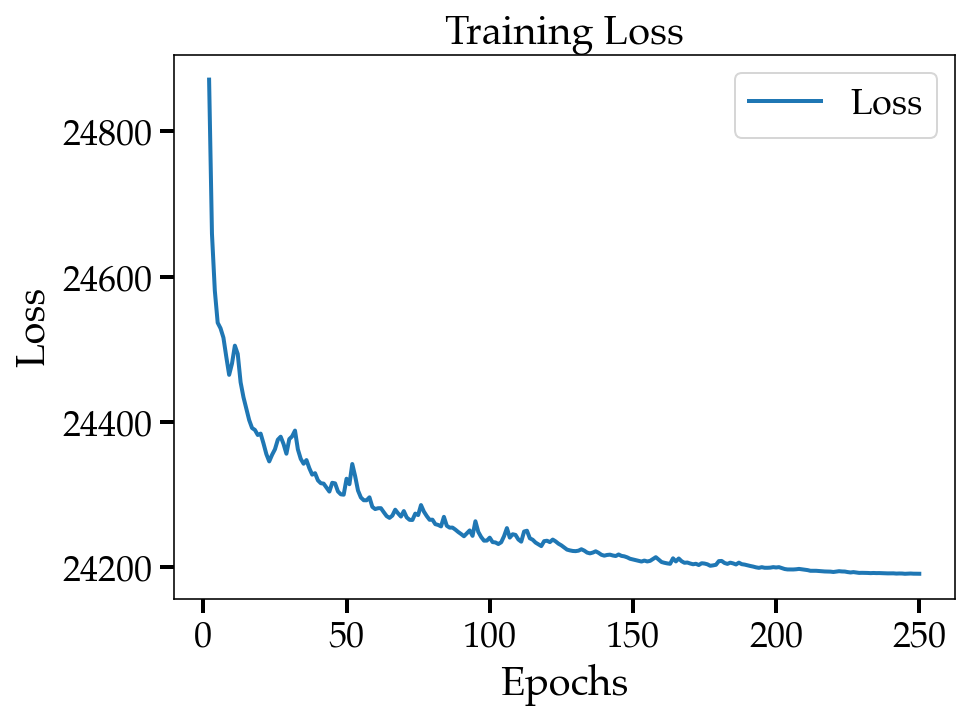

In [15]:
# Assuming you have a list of loss values named "loss_history"
epochs = range(1, len(loss_history) + 1)

# Plot the loss curve
plt.plot(epochs[1:], loss_history[1:], label='Loss')
#plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

loss_folder_path = f"../figures/CVAE/{fakes_suffix}/loss_curves"
if not os.path.exists(loss_folder_path):
    os.makedirs(loss_folder_path)
plt.savefig(f'{loss_folder_path}/cvae_model_{suffix}.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
np.unique(np.array(x_train_all.tns_cls))

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [17]:
np.unique(np.array(x_test_all.tns_cls))

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [18]:
x_test = x_test.astype('float32')
x_test_normalized = (x_test - x_train_mean) / x_train_std 

# Class labels
label_encoder = LabelEncoder()
y_test = np.array(x_test_all.tns_cls)
#print(y_test)
y_test_encoded = label_encoder.fit_transform(y_test)  # Convert string labels to integers
#print(y_test_encoded)
num_classes = len(label_encoder.classes_)  # Update the number of classes
y_test_encoded = keras.utils.to_categorical(y_test_encoded, num_classes) #num_classes  # One-hot encode the integer labels
#print(y_test_encoded[1])
x_test_normalized_with_labels = np.concatenate((x_test_normalized, y_test_encoded), axis=1)

# PZFLOW has mismatched class nums for train/test/val...


# Encode the test data
encoded_data = encoder.predict(x_test_normalized_with_labels)
# Decode the encoded data
decoded_data = vae.predict(x_test_normalized_with_labels)

# Evaluate the reconstruction loss
test_loss = np.mean(np.square(x_test_normalized_with_labels - decoded_data))

# Print the test loss
print("Test Loss:", test_loss)

26/26 [==============================] - 0s 1ms/step
Test Loss: 1.2705760469914287


/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [19]:
cols_132 = list(x_test_normalized.columns)+list(np.unique(np.array(x_test_all.tns_cls)))

x_test_normalized_with_labels_df = pd.DataFrame(x_test_normalized_with_labels, columns=cols_132, index=x_test_normalized.index)
x_test_normalized_with_labels_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21acguazv,-0.484607,-0.628688,-1.717797,-0.731876,0.130245,-0.461969,-0.143036,0.068463,-0.158087,-0.513241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZTF20acusecr,-0.849480,-0.200075,2.465405,-0.731876,0.407378,-0.833619,-0.559208,-0.020791,-1.135893,0.285844,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZTF18acvgwfq,-0.597293,-0.915101,-0.797493,-0.731876,-0.079319,-0.576749,-0.213583,0.061859,-0.647270,1.845960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZTF20acoucvl,-0.271491,-0.008207,-2.638102,2.366566,-0.229153,-0.244896,-0.509662,-0.510072,1.309759,-0.855020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZTF20acivqxn,-1.151862,-0.572522,1.963421,-0.731876,1.046044,-1.141616,-0.907886,-0.435287,-1.169770,1.176719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,-0.190392,0.191605,0.859055,-0.731876,1.705783,-0.162292,-0.102863,0.395981,-1.003844,1.187365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZTF21aarzxnb,-1.684063,-0.396402,-1.980742,-0.731876,-0.416300,-1.683700,-1.554200,-1.359074,0.903922,0.284946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZTF18acsxjhc,0.679346,0.243296,-0.203372,0.680072,-1.120649,0.646880,-0.063292,-0.305529,-0.009498,-0.395746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
decoded_data_df = pd.DataFrame(decoded_data, columns=cols_132, index=x_test_normalized.index)

decoded_data_df_with_tns = decoded_data_df.copy()
decoded_data_df_with_tns['tns_cls'] = y_test
decoded_data_df_with_tns

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,tns_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21acguazv,-1.083333,-1.854148,0.368908,-2.418162,-0.041304,-1.184586,-0.811997,-0.919152,-0.694948,-0.141574,...,-4.049673,0.176329,-0.423754,-0.189859,0.034242,-0.487952,-0.623627,-0.305978,-1.144121,None
ZTF20acusecr,-0.702852,-1.903295,1.216989,-2.870813,0.912924,-0.762774,-0.094683,0.579929,-1.339606,0.701444,...,-4.958665,-0.185060,-0.421894,-0.268265,0.133848,0.638952,-0.368476,-0.507143,-1.409438,SN IIb
ZTF18acvgwfq,-0.986068,-2.066586,0.051107,-1.814436,0.328452,-1.156883,-0.730296,-0.689240,-1.012497,-0.081028,...,-1.560308,-0.281001,-0.315755,-0.164692,-0.357825,0.100960,-0.869872,0.453392,-1.506528,None
ZTF20acoucvl,-0.396627,0.575179,-1.910019,1.236667,-0.772332,-0.494077,-0.681770,-1.497988,1.612827,-1.124604,...,-0.778618,-0.810753,0.118133,0.017736,0.054118,-0.821941,-0.873949,0.064420,-0.089814,None
ZTF20acivqxn,-1.540473,-1.180252,1.157266,-2.974259,0.951276,-1.577315,-1.108890,-0.221396,-2.505370,0.063722,...,-0.618159,-0.475919,0.063332,-0.081634,-0.369245,-0.547469,-0.980759,-0.918120,-0.392432,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,-0.793400,-1.221784,0.005101,-0.591864,1.198354,-0.659626,-0.248403,0.254033,-0.588125,0.075256,...,-5.472891,-0.219092,-0.204456,0.024610,-0.245368,0.006949,-0.246381,-0.596517,-0.302115,None
ZTF21aarzxnb,-1.494280,-1.733012,-0.789876,-0.870776,-0.858605,-1.558916,-1.311303,-1.944274,0.612252,-0.342102,...,-2.221119,-0.050209,-0.447154,-0.110226,-0.010785,-0.199167,-1.236369,0.134836,-1.516724,None
ZTF18acsxjhc,0.179014,-0.616260,-1.988160,1.216614,-0.595564,0.348500,0.081366,-0.635228,1.165261,-0.611536,...,-4.125744,0.056810,-0.045801,0.226543,-0.097883,-0.835308,-0.123050,-0.153672,-0.792390,None


[137, 582, 782]
https://alerce.online/object/ZTF21aajgdpo
https://alerce.online/object/ZTF21aavozbk
https://alerce.online/object/ZTF21achjmmc


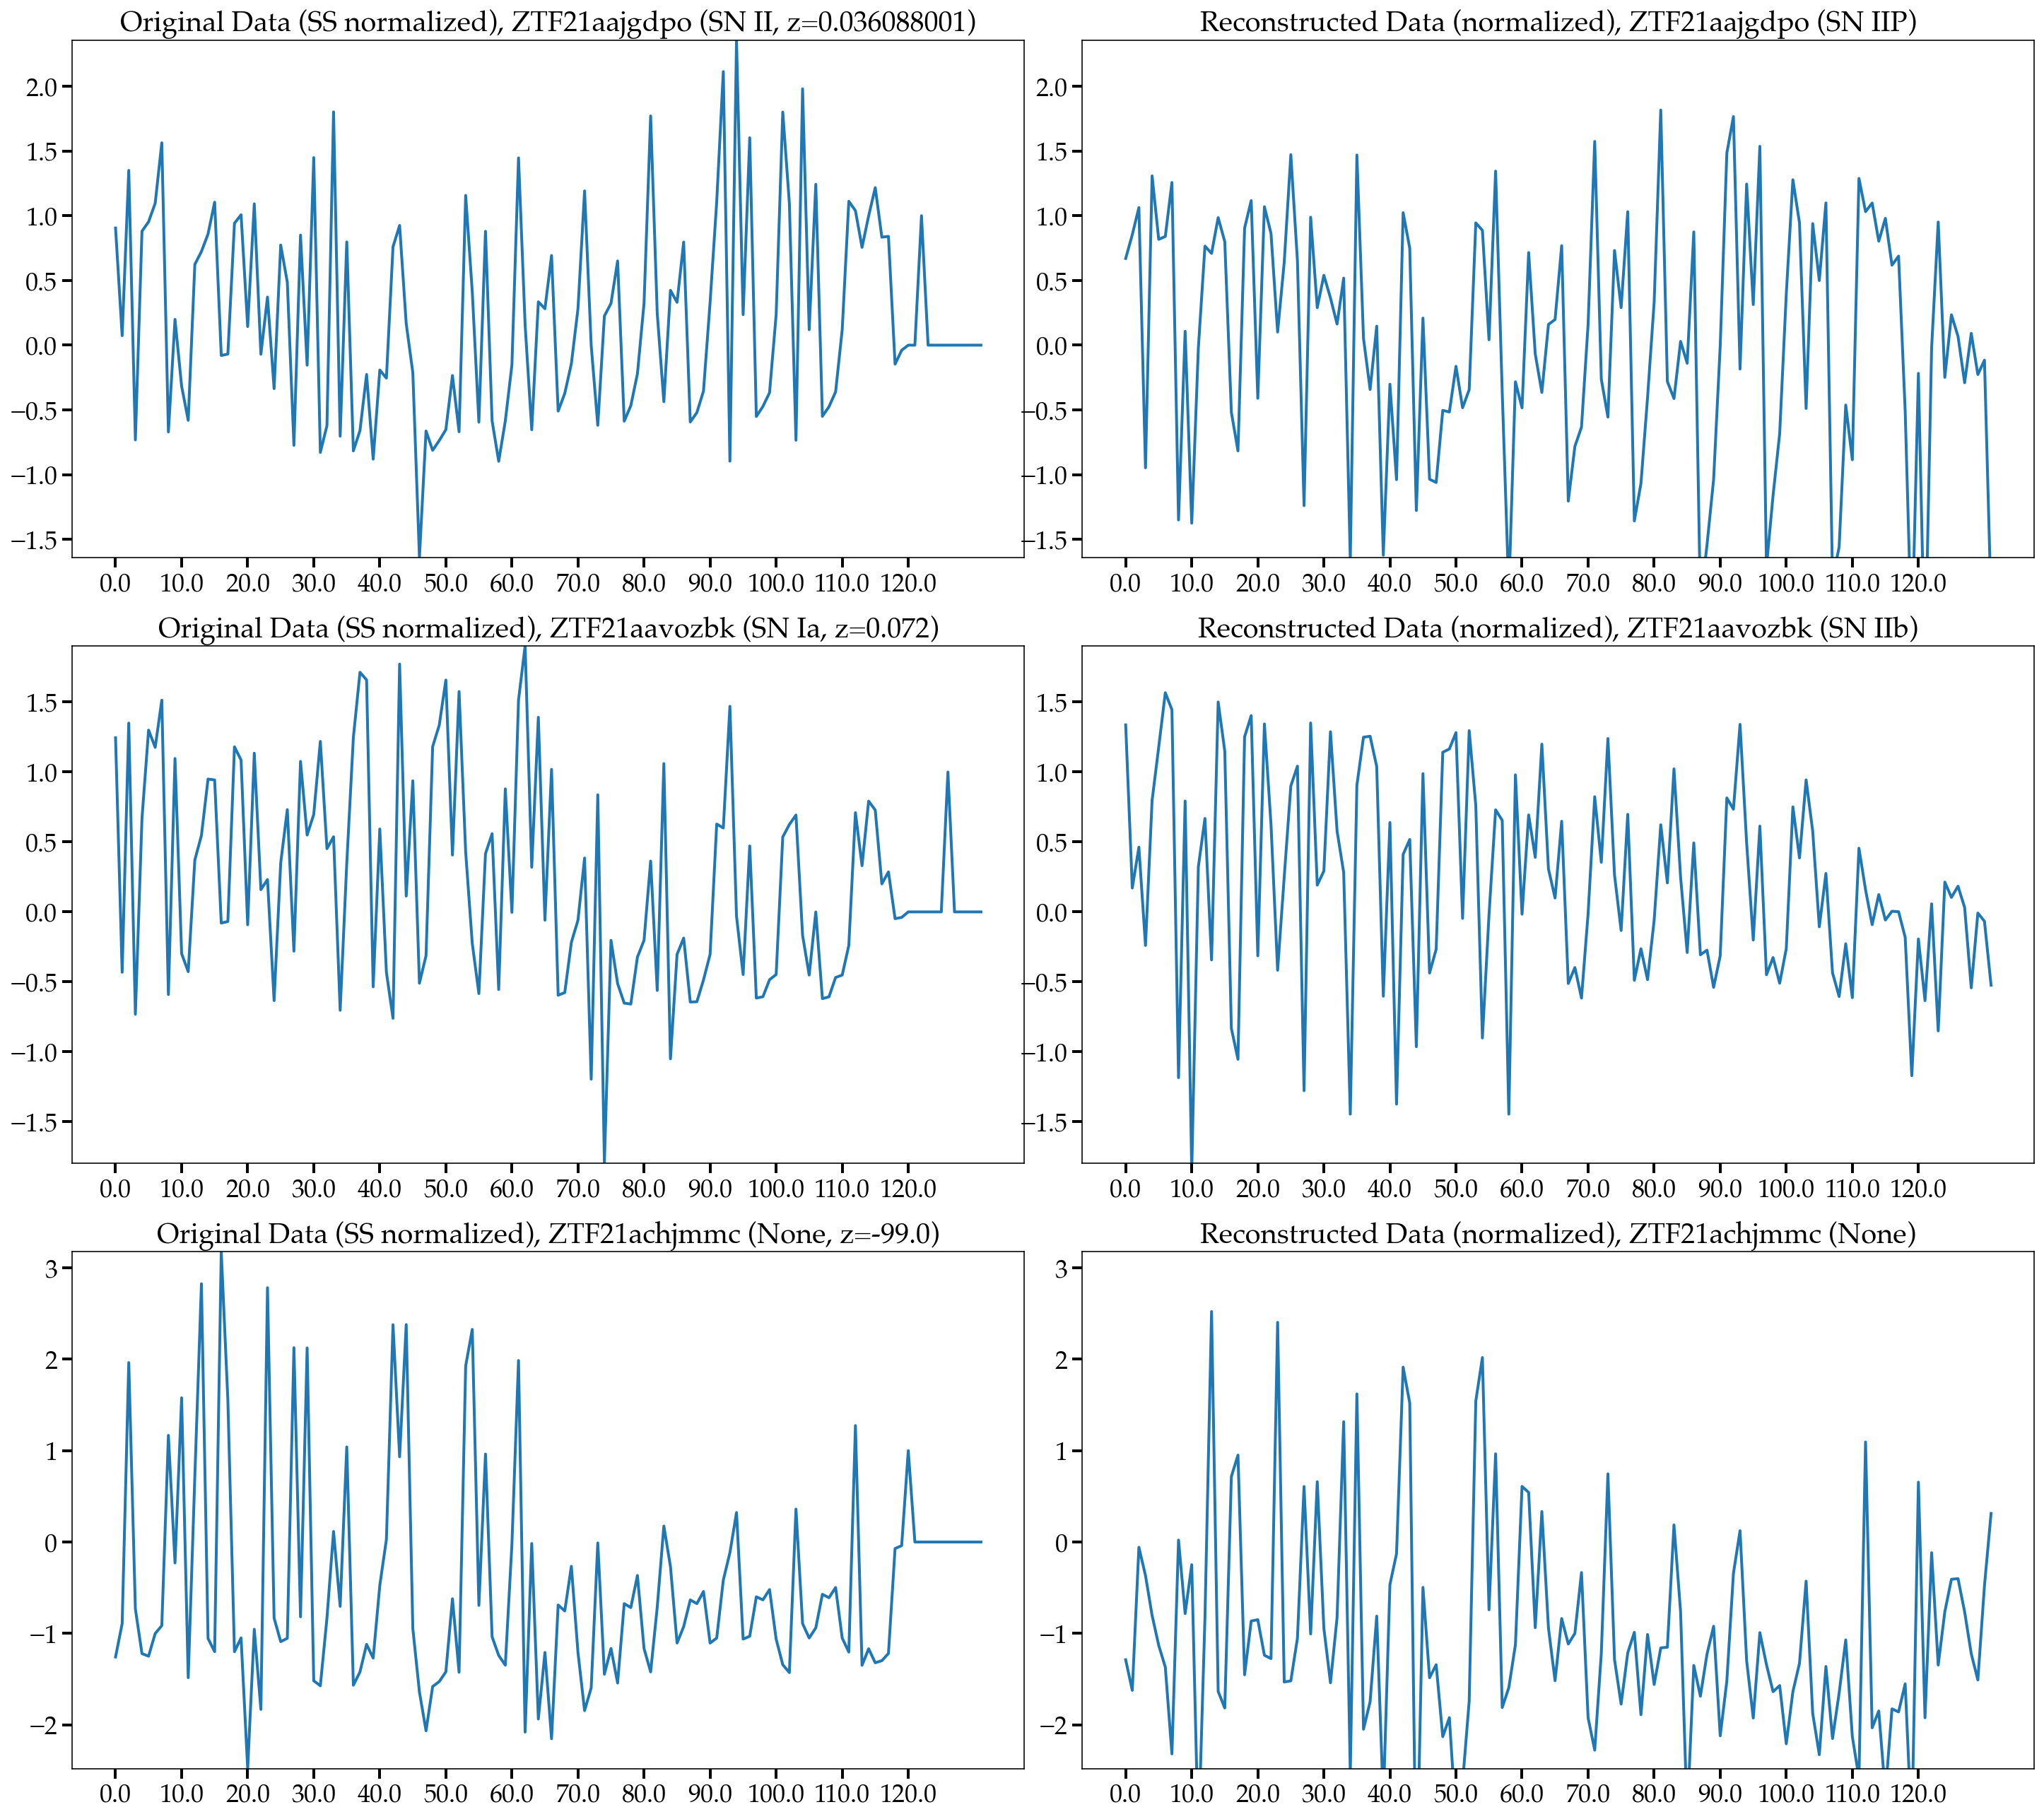

In [21]:
import matplotlib.pyplot as plt
import random

# Select a random sample of data points from x_test
num_samples = 3
random.seed(1)
random_indices = random.sample(range(len(x_test_normalized_with_labels_df)), num_samples)
print(random_indices)

# Plot original data and reconstructed data
fig, axes = plt.subplots(num_samples, 2, figsize=(20, 6 * num_samples))
for i, index in enumerate(random_indices):
    try:
        # Plot original data
        y_min, y_max=np.min(x_test_normalized_with_labels_df.iloc[index]), np.max(x_test_normalized_with_labels_df.iloc[index])
        print(f'https://alerce.online/object/{x_test_normalized_with_labels_df.iloc[index].name}')
        axes[i, 0].plot(x_test_normalized_with_labels_df.iloc[index])
        axes[i, 0].set_title(f"Original Data (SS normalized), {x_test_normalized_with_labels_df.iloc[index].name} ({x_test_all.iloc[index].tns_cls}, z={x_test_all.iloc[index].spec_z})")
        #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
        #axes[i, 0].set_xticks(np.array(range(0, 120, 20)))
        axes[i, 0].set_xticks(np.array([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.]))
        axes[i, 0].set_xticklabels([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.])
        #axes[i, 0].set_xticklabels(x_test.columns, rotation=90, fontsize=6)
        axes[i, 0].set_ylim([y_min, y_max])  # Set y-scale limits

        # Plot reconstructed data
        axes[i, 1].plot(decoded_data[index])
        axes[i, 1].set_title(f"Reconstructed Data (normalized), {x_test_normalized_with_labels_df.iloc[index].name} ({list(np.unique(np.array(x_test_all.tns_cls)))[np.array(decoded_data[index][-12:]).argmax()]})")
        axes[i, 1].set_xticks(np.array([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.]))
        axes[i, 1].set_xticklabels([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.])
        #axes[i, 1].set_xticklabels(list(x_test.columns), rotation=90, fontsize=6)
        axes[i, 1].set_ylim([y_min, y_max])  # Set y-scale limits
    except KeyError:
        continue

plt.tight_layout()

ovr_folder_path = f"../figures/CVAE/{fakes_suffix}/original_vs_reconstructed"
if not os.path.exists(ovr_folder_path):
    os.makedirs(ovr_folder_path)
plt.savefig(f'{ovr_folder_path}/cvae_model_{suffix}.jpg', dpi=150, bbox_inches='tight')
plt.show()


In [22]:
print(decoded_data_df_with_tns.iloc[:, -13:-1])

                   None   SLSN-II     SN II    SN IIP    SN IIb    SN IIn  \
ztf_object_id                                                               
ZTF21acguazv   0.267941 -1.859499 -0.008621 -4.049673  0.176329 -0.423754   
ZTF20acusecr   0.093897 -2.828332 -0.059159 -4.958665 -0.185060 -0.421894   
ZTF18acvgwfq   0.606579 -1.961306 -0.151087 -1.560308 -0.281001 -0.315755   
ZTF20acoucvl   0.211216 -0.068656 -0.081519 -0.778618 -0.810753  0.118133   
ZTF20acivqxn   0.344478 -1.791095 -0.164806 -0.618159 -0.475919  0.063332   
...                 ...       ...       ...       ...       ...       ...   
ZTF20acupxyy   0.214447 -0.483152 -0.045786 -5.472891 -0.219092 -0.204456   
ZTF21aarzxnb   0.475935 -1.789439 -0.011168 -2.221119 -0.050209 -0.447154   
ZTF18acsxjhc   0.200176 -1.672839  0.118320 -4.125744  0.056810 -0.045801   
ZTF21aatklhw   0.289391 -1.104342  0.021678 -1.685765 -0.022646 -0.166370   
ZTF21absyome   0.269731 -0.679157 -0.179101 -1.452657 -0.545141 -0.062445   

In [23]:
decoded_data_df_with_tns = decoded_data_df_with_tns.drop(columns='None')
decoded_data_df_with_tns.iloc[:, -12:-1]

,SLSN-II,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE
ztf_object_id,,,,,,,,,,,
ZTF21acguazv,-1.859499,-0.008621,-4.049673,0.176329,-0.423754,-0.189859,0.034242,-0.487952,-0.623627,-0.305978,-1.144121
ZTF20acusecr,-2.828332,-0.059159,-4.958665,-0.185060,-0.421894,-0.268265,0.133848,0.638952,-0.368476,-0.507143,-1.409438
ZTF18acvgwfq,-1.961306,-0.151087,-1.560308,-0.281001,-0.315755,-0.164692,-0.357825,0.100960,-0.869872,0.453392,-1.506528
ZTF20acoucvl,-0.068656,-0.081519,-0.778618,-0.810753,0.118133,0.017736,0.054118,-0.821941,-0.873949,0.064420,-0.089814
ZTF20acivqxn,-1.791095,-0.164806,-0.618159,-0.475919,0.063332,-0.081634,-0.369245,-0.547469,-0.980759,-0.918120,-0.392432
...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,-0.483152,-0.045786,-5.472891,-0.219092,-0.204456,0.024610,-0.245368,0.006949,-0.246381,-0.596517,-0.302115
ZTF21aarzxnb,-1.789439,-0.011168,-2.221119,-0.050209,-0.447154,-0.110226,-0.010785,-0.199167,-1.236369,0.134836,-1.516724
ZTF18acsxjhc,-1.672839,0.118320,-4.125744,0.056810,-0.045801,0.226543,-0.097883,-0.835308,-0.123050,-0.153672,-0.792390


In [24]:
x_test_all_with_pred = x_test_all.copy()

# Without or With None class
highest_index = lambda row: row.idxmax(axis=1)
x_test_all_with_pred['pred_classes'] = decoded_data_df_with_tns.iloc[:, -12:-1].apply(highest_index, axis=1)

x_test_all_with_pred = x_test_all_with_pred[x_test_all_with_pred.tns_cls != "None"]
x_test_all_with_pred

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group,pred_classes
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acusecr,0.406060,0.733228,0.545455,0.000000,0.407855,0.812120,0.786542,0.658684,-1.974156,0.012656,...,0.401699,0.471100,0.162901,52.515766,0.100272,Yes_TNS,SN IIb,0.030884,ALeRCE,SN Ib
ZTF21acmrdga,0.795146,0.320703,0.166667,0.000000,0.391475,1.590292,1.539247,1.079844,-0.499456,-0.053775,...,1.572201,1.220500,1.349000,304.683149,0.659155,Yes_TNS,SN IIb,0.034000,ZTF,SN Ic
ZTF21abviabc,0.591871,0.599046,0.545455,0.000000,0.429706,1.183743,1.152697,0.966486,-1.873181,0.020430,...,0.860099,0.899899,0.856801,16.607475,0.011196,Yes_TNS,SN II,0.053467,ALeRCE,TDE
ZTF21aaxubqf,0.680858,0.638702,0.090909,0.090909,0.362806,1.361715,0.967896,0.528994,2.278459,0.025602,...,0.292200,0.348700,0.241100,29.743645,1.020465,Yes_TNS,SN Ia,0.073698,ALeRCE,SN Ia
ZTF21aasgcve,0.657196,0.515788,0.333333,0.000000,0.394968,1.314392,1.189453,0.570115,-0.411502,-0.004898,...,0.128101,0.245300,0.183599,19.399575,0.147846,Yes_TNS,SN Ia-91T-like,0.090000,ALeRCE,SN IIb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,1.001200,1.090099,1.092001,48.668157,0.124452,Yes_TNS,SN Ia-91T-like,0.037437,ALeRCE,SN Ia
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.329800,0.383400,0.422300,58.550706,0.012833,Yes_TNS,SN Ia,0.097780,AMPEL,SN Ia
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,1.271399,1.157599,1.225500,124.418488,0.916609,Yes_TNS,SN Ia,0.040000,ALeRCE,SN Ia


In [25]:
for h, i, j in zip(x_test_all_with_pred.index, x_test_all_with_pred.tns_cls, x_test_all_with_pred.pred_classes):
    print(h, i, j)

ZTF20acusecr SN IIb SN Ib
ZTF21acmrdga SN IIb SN Ic
ZTF21abviabc SN II TDE
ZTF21aaxubqf SN Ia SN Ia
ZTF21aasgcve SN Ia-91T-like SN IIb
ZTF21aaagypx SN IIP SN IIb
ZTF20acxtdcm SN II SN IIP
ZTF20acrerzb SN Ia SN Ia
ZTF18aaqnxjb SN Ia SN Ib
ZTF22aaaedas TDE SN II
ZTF20acajvrj SN Ia SN Ia
ZTF20aciuciv SN II TDE
ZTF21aappktx SN Ia SN Ia-91T-like
ZTF21abbwbja SN Ia SN Ia-91T-like
ZTF20aatxryt SN Ia SN Ic
ZTF21acizsaz SN Ia SN Ia-91T-like
ZTF18acbvgtu SN Ia SN Ib
ZTF20acnagjb SN Ia SN Ia
ZTF21abaxaqq TDE TDE
ZTF22aaabnan SN Ia SN Ia
ZTF20aclnplo SN Ic SN Ia
ZTF18acsremz SN Ia SN Ia
ZTF18acaqdaa TDE SLSN-II
ZTF21aaphlty SN Ia SN Ia
ZTF20acgznau SN Ia SN Ia
ZTF20actpbck SN Ia SN Ia
ZTF21achqiue SN Ia SN Ia
ZTF21aaswtok SN Ia SN Ia
ZTF21aapkfjx SN Ia SN Ia
ZTF21aagsypp SN Ia SN Ic
ZTF20acpxvez SN Ia SN Ia
ZTF20acfnuee SN Ia SN Ia
ZTF21acmnpqa SN Ia SN Ib
ZTF21aagtill SN Ia SN Ib
ZTF20acwncbd SN Ia SN IIb
ZTF20acyroke SN Ia SN Ic-BL
ZTF20accodxy SN Ia SLSN-II
ZTF19aaeuhgo SN II SN IIn
ZTF21aabyqp

In [26]:
Counter(sorted(x_test_all_with_pred.tns_cls))

Counter({'SLSN-II': 3,
         'SN II': 38,
         'SN IIP': 3,
         'SN IIb': 4,
         'SN IIn': 7,
         'SN Ia': 161,
         'SN Ia-91T-like': 5,
         'SN Ib': 1,
         'SN Ic': 5,
         'SN Ic-BL': 3,
         'TDE': 6})

In [27]:
Counter(sorted(x_test_all_with_pred.pred_classes))

Counter({'SLSN-II': 10,
         'SN II': 14,
         'SN IIP': 13,
         'SN IIb': 23,
         'SN IIn': 12,
         'SN Ia': 81,
         'SN Ia-91T-like': 25,
         'SN Ib': 18,
         'SN Ic': 19,
         'SN Ic-BL': 9,
         'TDE': 12})

#### SMOTE
#### 1000000 class loss weight
Counter({'SLSN-II': 8,
         'SN II': 11,
         'SN IIP': 9,
         'SN IIb': 19,
         'SN IIn': 18,
         'SN Ia': 56,
         'SN Ia-91T-like': 32,
         'SN Ib': 29,
         'SN Ic': 22,
         'SN Ic-BL': 14,
         'TDE': 18})

#### 10000 class loss weight
Counter({'SLSN-II': 10,
         'SN II': 14,
         'SN IIP': 13,
         'SN IIb': 23,
         'SN IIn': 12,
         'SN Ia': 81,
         'SN Ia-91T-like': 25,
         'SN Ib': 18,
         'SN Ic': 19,
         'SN Ic-BL': 9,
         'TDE': 12})
         
#### 1 class loss weight
Counter({'SLSN-II': 8,
         'SN II': 20,
         'SN IIP': 10,
         'SN IIb': 15,
         'SN IIn': 24,
         'SN Ia': 54,
         'SN Ia-91T-like': 34,
         'SN Ib': 23,
         'SN Ic': 16,
         'SN Ic-BL': 19,
         'TDE': 13})
         
#### PZFLOW (lol so bad)
#### 10000 class loss weight
Counter({'SLSN-II': 35,
         'SN II': 3,
         'SN IIP': 36,
         'SN IIb': 28,
         'SN IIn': 2,
         'SN Ia': 4,
         'SN Ia-91T-like': 23,
         'SN Ib': 16,
         'SN Ic': 6,
         'SN Ic-BL': 24,
         'TDE': 59})

#### 1 class loss weight
Counter({'SLSN-II': 36,
         'SN II': 2,
         'SN IIP': 36,
         'SN IIb': 22,
         'SN IIn': 2,
         'SN Ia': 26,
         'SN Ia-91T-like': 15,
         'SN Ib': 9,
         'SN Ic': 12,
         'SN Ic-BL': 21,
         'TDE': 55})

# Caution! Doesn't really make sense because I NEED an input class label... ( i guess if i input None, and take the first None class it could work... In that case, I need to reinput None class) 

# TODO: make confusion matrices!

### VAE

In [11]:
%%time
import numpy as np
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.losses import binary_crossentropy, KLDivergence
from keras import backend as K
from keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tqdm import tqdm

# Normalize the input data & validation data
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_normalized = (x_train - x_train_mean) / x_train_std

x_val_mean = np.mean(x_val, axis=0)
x_val_std = np.std(x_val, axis=0)
x_val_normalized = (x_val - x_train_mean) / x_train_std # scale to training

# Define the dimensions
input_dim = 120
latent_dim = 20 # 20 # 5
intermediate_dim = 64

nepochs = 500
batch_size = 128

# Set the random seed for TensorFlow/Keras layers
tf.keras.backend.clear_session()  # Clear any existing models or layers

# Set random seed when creating the VAE model and layers
tf.random.set_seed(seed_value)
# Rest of your code to define the VAE architecture

# Encoder
input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(intermediate_dim, activation='relu')(input_layer)

# Define the mean and variance of the latent distribution
z_mean = Dense(latent_dim)(hidden_layer)
z_log_var = Dense(latent_dim)(hidden_layer)

# Custom layer for reparameterization trick
class SamplingLayer(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = K.shape(z_mean)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = SamplingLayer()([z_mean, z_log_var])

# Decoder
decoder_hidden = Dense(intermediate_dim, activation='relu')
decoder_output = Dense(input_dim, activation='linear')  # linear- Modified activation function

# Define the VAE model
decoder_mean = decoder_output(decoder_hidden(z))
vae = Model(input_layer, decoder_mean)

# Define the reconstruction loss
reconstruction_loss = input_dim * binary_crossentropy(input_layer, decoder_mean)

# Define the KL divergence loss
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

# Add the reconstruction and KL divergence losses as additional losses
vae.add_loss(K.mean(reconstruction_loss + kl_loss))

# Compile the model with the desired learning rate
optimizer = keras.optimizers.Adam(lr=1e-3) # same as ParSNIP
vae.compile(optimizer=optimizer)

# Define a callback for updating the progress bar
progress_bar = tqdm(unit="batch", total=len(x_train) // batch_size)
progress_callback = LambdaCallback(on_batch_end=lambda batch, logs: progress_bar.update(1) if (batch + 1) % 32 == 0 else False)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5) # same as ParSNIP

# Train the VAE
history = vae.fit(
    x_train_normalized, x_train_normalized,
    batch_size=batch_size,
    epochs=nepochs,
    callbacks=[progress_callback, reduce_lr],
    validation_data=(x_val_normalized, x_val_normalized)  # Assuming you have a validation set
)

# Close the progress bar after training
progress_bar.close()

# Obtain the latent representation of the input data
encoder = Model(input_layer, z_mean)
print(encoder.summary())
latent_representation = encoder.predict(x_train)

# Extract loss values from history
loss_history = history.history['loss']

# Save the loss values to a file
#np.savetxt('loss_values.txt', loss_history)

Cause: Unable to locate the source code of <bound method SamplingLayer.call of <__main__.SamplingLayer object at 0x7fdc5651f7f0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <bound method SamplingLayer.call of <__main__.SamplingLayer object at 0x7fdc5651f7f0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
  0%|          | 0/249 [00:00<?, ?batch/s]

Epoch 1/500
 28/249 [==>...........................] - ETA: 0s - loss: 5868.4741 

  0%|          | 1/249 [00:00<03:09,  1.31batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: 1875.1232

  1%|          | 3/249 [00:00<00:59,  4.17batch/s]

143/249 [================>.............] - ETA: 0s - loss: 1075.6099

  2%|▏         | 5/249 [00:00<00:35,  6.87batch/s]

199/249 [======================>.......] - ETA: 0s - loss: 714.2725

  3%|▎         | 7/249 [00:01<00:26,  9.20batch/s]

249/249 [==============================] - 1s 3ms/step - loss: 514.7552 - val_loss: -547.6876 - lr: 0.0010
Epoch 2/500
 57/249 [=====>........................] - ETA: 0s - loss: -307.4711

  4%|▎         | 9/249 [00:01<00:33,  7.26batch/s]

109/249 [============>.................] - ETA: 0s - loss: -321.9156

  4%|▍         | 11/249 [00:01<00:26,  8.99batch/s]

182/249 [====================>.........] - ETA: 0s - loss: -331.3696

  5%|▌         | 13/249 [00:01<00:22, 10.40batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -342.4508 - val_loss: -610.1301 - lr: 0.0010
Epoch 3/500
 25/249 [==>...........................] - ETA: 0s - loss: -379.9502

  6%|▌         | 15/249 [00:01<00:23, 10.15batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -385.9337

  7%|▋         | 17/249 [00:02<00:19, 11.73batch/s]

157/249 [=================>............] - ETA: 0s - loss: -390.5066

  8%|▊         | 19/249 [00:02<00:18, 12.60batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -396.4630

  8%|▊         | 21/249 [00:02<00:16, 13.68batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -400.7312 - val_loss: -672.1729 - lr: 0.0010
Epoch 4/500
 60/249 [======>.......................] - ETA: 0s - loss: -434.4207

  9%|▉         | 23/249 [00:02<00:18, 12.49batch/s]

119/249 [=============>................] - ETA: 0s - loss: -434.4110

 10%|█         | 25/249 [00:02<00:16, 13.79batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -435.5984

 11%|█         | 27/249 [00:02<00:15, 14.34batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -432.4713 - val_loss: -682.7049 - lr: 0.0010
Epoch 5/500
 30/249 [==>...........................] - ETA: 0s - loss: -435.4417

 12%|█▏        | 29/249 [00:02<00:17, 12.85batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -432.5516

 12%|█▏        | 31/249 [00:03<00:16, 13.62batch/s]

158/249 [==================>...........] - ETA: 0s - loss: -438.3723

 13%|█▎        | 33/249 [00:03<00:15, 14.21batch/s]

209/249 [========================>.....] - ETA: 0s - loss: -437.0354

 14%|█▍        | 35/249 [00:03<00:14, 14.59batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -437.1694 - val_loss: -690.6102 - lr: 0.0010
Epoch 6/500
 54/249 [=====>........................] - ETA: 0s - loss: -401.3553

 15%|█▍        | 37/249 [00:03<00:16, 12.60batch/s]

106/249 [===========>..................] - ETA: 0s - loss: -404.1386

 16%|█▌        | 39/249 [00:03<00:15, 13.48batch/s]

185/249 [=====================>........] - ETA: 0s - loss: -414.6801

 16%|█▋        | 41/249 [00:03<00:14, 14.12batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -421.0707 - val_loss: -692.6058 - lr: 0.0010
Epoch 7/500
 26/249 [==>...........................] - ETA: 0s - loss: -456.2738

 17%|█▋        | 43/249 [00:03<00:17, 11.86batch/s]

 71/249 [=======>......................] - ETA: 0s - loss: -445.6730

 18%|█▊        | 45/249 [00:04<00:16, 12.48batch/s]

144/249 [================>.............] - ETA: 0s - loss: -444.6357

 19%|█▉        | 47/249 [00:04<00:15, 13.06batch/s]

219/249 [=========================>....] - ETA: 0s - loss: -447.5861

 20%|█▉        | 49/249 [00:04<00:14, 13.67batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -451.4619 - val_loss: -719.0207 - lr: 0.0010
Epoch 8/500
 57/249 [=====>........................] - ETA: 0s - loss: -472.2592

 20%|██        | 51/249 [00:04<00:16, 12.27batch/s]

115/249 [============>.................] - ETA: 0s - loss: -471.7477

 21%|██▏       | 53/249 [00:04<00:14, 13.52batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -474.7844

 22%|██▏       | 55/249 [00:04<00:13, 14.71batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -477.8391 - val_loss: -739.5197 - lr: 0.0010
Epoch 9/500
 30/249 [==>...........................] - ETA: 0s - loss: -479.9184

 23%|██▎       | 57/249 [00:05<00:14, 13.13batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -460.3946

 24%|██▎       | 59/249 [00:05<00:13, 14.29batch/s]

147/249 [================>.............] - ETA: 0s - loss: -459.2816

 24%|██▍       | 61/249 [00:05<00:12, 15.29batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -459.7534

 25%|██▌       | 63/249 [00:05<00:11, 16.06batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -461.4064 - val_loss: -738.0626 - lr: 0.0010
Epoch 10/500
 63/249 [======>.......................] - ETA: 0s - loss: -460.6395

 26%|██▌       | 65/249 [00:05<00:13, 13.99batch/s]

124/249 [=============>................] - ETA: 0s - loss: -460.5425

 27%|██▋       | 67/249 [00:05<00:12, 15.15batch/s]

183/249 [=====================>........] - ETA: 0s - loss: -462.4103

 28%|██▊       | 69/249 [00:05<00:11, 15.99batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -467.1628 - val_loss: -750.1402 - lr: 0.0010
Epoch 11/500
 31/249 [==>...........................] - ETA: 0s - loss: -496.6820

 29%|██▊       | 71/249 [00:05<00:12, 13.93batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -490.9104

 29%|██▉       | 73/249 [00:06<00:11, 14.84batch/s]

145/249 [================>.............] - ETA: 0s - loss: -491.4635

 30%|███       | 75/249 [00:06<00:11, 15.63batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -491.3932

 31%|███       | 77/249 [00:06<00:10, 16.39batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -492.8973 - val_loss: -765.4838 - lr: 0.0010
Epoch 12/500
 63/249 [======>.......................] - ETA: 0s - loss: -499.7527

 32%|███▏      | 79/249 [00:06<00:11, 14.18batch/s]

123/249 [=============>................] - ETA: 0s - loss: -494.1780

 33%|███▎      | 81/249 [00:06<00:11, 15.23batch/s]

183/249 [=====================>........] - ETA: 0s - loss: -492.6703

 33%|███▎      | 83/249 [00:06<00:10, 16.09batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -493.9404 - val_loss: -762.6830 - lr: 0.0010
Epoch 13/500
 23/249 [=>............................] - ETA: 0s - loss: -497.4043

 34%|███▍      | 85/249 [00:06<00:12, 13.50batch/s]

 76/249 [========>.....................] - ETA: 0s - loss: -508.7351

 35%|███▍      | 87/249 [00:07<00:11, 14.28batch/s]

154/249 [=================>............] - ETA: 0s - loss: -510.5761

 36%|███▌      | 89/249 [00:07<00:10, 14.77batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -511.9243

 37%|███▋      | 91/249 [00:07<00:10, 15.01batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -510.7481 - val_loss: -733.6330 - lr: 0.0010
Epoch 14/500
 56/249 [=====>........................] - ETA: 0s - loss: -506.0564

 37%|███▋      | 93/249 [00:07<00:12, 12.95batch/s]

108/249 [============>.................] - ETA: 0s - loss: -511.2490

 38%|███▊      | 95/249 [00:07<00:11, 13.77batch/s]

189/249 [=====================>........] - ETA: 0s - loss: -515.5939

 39%|███▉      | 97/249 [00:07<00:10, 14.43batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -516.8822 - val_loss: -752.9710 - lr: 0.0010
Epoch 15/500
 25/249 [==>...........................] - ETA: 0s - loss: -493.8761

 40%|███▉      | 99/249 [00:07<00:12, 12.25batch/s]

 94/249 [==========>...................] - ETA: 0s - loss: -503.7266

 41%|████      | 101/249 [00:08<00:11, 12.70batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -514.3500

 41%|████▏     | 103/249 [00:08<00:10, 13.33batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -515.9390

 42%|████▏     | 105/249 [00:08<00:10, 14.17batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -510.7085 - val_loss: -729.8873 - lr: 0.0010
Epoch 16/500
 62/249 [======>.......................] - ETA: 0s - loss: -492.4148

 43%|████▎     | 107/249 [00:08<00:10, 13.00batch/s]

116/249 [============>.................] - ETA: 0s - loss: -492.7786

 44%|████▍     | 109/249 [00:08<00:10, 13.95batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -495.9550

 45%|████▍     | 111/249 [00:08<00:09, 14.89batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -497.1661 - val_loss: -746.8114 - lr: 0.0010
Epoch 17/500
  1/249 [..............................] - ETA: 0s - loss: -498.7817

 45%|████▌     | 113/249 [00:08<00:10, 13.36batch/s]

 94/249 [==========>...................] - ETA: 0s - loss: -518.4993

 46%|████▌     | 115/249 [00:09<00:09, 14.64batch/s]

151/249 [=================>............] - ETA: 0s - loss: -521.6724

 47%|████▋     | 117/249 [00:09<00:08, 15.42batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -520.1355

 48%|████▊     | 119/249 [00:09<00:08, 16.20batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -521.4388 - val_loss: -757.9287 - lr: 0.0010
Epoch 18/500
 46/249 [====>.........................] - ETA: 0s - loss: -492.1044

 49%|████▊     | 121/249 [00:09<00:09, 12.81batch/s]

 97/249 [==========>...................] - ETA: 0s - loss: -490.2498

 49%|████▉     | 123/249 [00:09<00:08, 14.05batch/s]

187/249 [=====================>........] - ETA: 0s - loss: -498.6873

 50%|█████     | 125/249 [00:09<00:08, 14.98batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -502.0793 - val_loss: -749.0689 - lr: 0.0010
Epoch 19/500
 31/249 [==>...........................] - ETA: 0s - loss: -514.1729

 51%|█████     | 127/249 [00:09<00:09, 13.33batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -513.7902

 52%|█████▏    | 129/249 [00:10<00:08, 14.48batch/s]

146/249 [================>.............] - ETA: 0s - loss: -505.2419

 53%|█████▎    | 131/249 [00:10<00:07, 15.27batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -501.7822

 53%|█████▎    | 133/249 [00:10<00:07, 16.08batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -500.9439 - val_loss: -731.4288 - lr: 0.0010
Epoch 20/500
 63/249 [======>.......................] - ETA: 0s - loss: -506.1744

 54%|█████▍    | 135/249 [00:10<00:08, 14.08batch/s]

118/249 [=============>................] - ETA: 0s - loss: -511.7846

 55%|█████▌    | 137/249 [00:10<00:07, 14.92batch/s]

178/249 [====================>.........] - ETA: 0s - loss: -505.9482

 56%|█████▌    | 139/249 [00:10<00:06, 15.83batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -505.3657 - val_loss: -748.1182 - lr: 0.0010
Epoch 21/500
 29/249 [==>...........................] - ETA: 0s - loss: -518.5810

 57%|█████▋    | 141/249 [00:10<00:07, 13.69batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -515.0912

 57%|█████▋    | 143/249 [00:10<00:07, 14.82batch/s]

147/249 [================>.............] - ETA: 0s - loss: -515.9230

 58%|█████▊    | 145/249 [00:11<00:06, 15.64batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -518.1772

 59%|█████▉    | 147/249 [00:11<00:06, 16.21batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -517.3904 - val_loss: -752.8929 - lr: 0.0010
Epoch 22/500
 61/249 [======>.......................] - ETA: 0s - loss: -527.2779

 60%|█████▉    | 149/249 [00:11<00:07, 14.00batch/s]

123/249 [=============>................] - ETA: 0s - loss: -528.4401

 61%|██████    | 151/249 [00:11<00:06, 15.16batch/s]

183/249 [=====================>........] - ETA: 0s - loss: -529.2078

 61%|██████▏   | 153/249 [00:11<00:06, 15.98batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -529.0483 - val_loss: -771.7762 - lr: 5.0000e-04
Epoch 23/500
 31/249 [==>...........................] - ETA: 0s - loss: -526.8785

 62%|██████▏   | 155/249 [00:11<00:06, 13.85batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -534.2327

 63%|██████▎   | 157/249 [00:11<00:06, 14.34batch/s]

157/249 [=================>............] - ETA: 0s - loss: -540.2084

 64%|██████▍   | 159/249 [00:12<00:06, 14.65batch/s]

207/249 [=======================>......] - ETA: 0s - loss: -539.2205

 65%|██████▍   | 161/249 [00:12<00:05, 14.95batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -539.3505 - val_loss: -766.7787 - lr: 5.0000e-04
Epoch 24/500
 53/249 [=====>........................] - ETA: 0s - loss: -518.9944

 65%|██████▌   | 163/249 [00:12<00:06, 12.71batch/s]

108/249 [============>.................] - ETA: 0s - loss: -501.5128

 66%|██████▋   | 165/249 [00:12<00:06, 13.85batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -502.4478

 67%|██████▋   | 167/249 [00:12<00:05, 14.98batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -506.1894 - val_loss: -751.2842 - lr: 5.0000e-04
Epoch 25/500
 31/249 [==>...........................] - ETA: 0s - loss: -509.6741

 68%|██████▊   | 169/249 [00:12<00:05, 13.40batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -519.3062

 69%|██████▊   | 171/249 [00:12<00:05, 14.18batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -525.3702

 69%|██████▉   | 173/249 [00:12<00:05, 14.98batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -525.6854

 70%|███████   | 175/249 [00:13<00:04, 15.74batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -525.1839 - val_loss: -771.9834 - lr: 5.0000e-04
Epoch 26/500
 58/249 [=====>........................] - ETA: 0s - loss: -539.2426

 71%|███████   | 177/249 [00:13<00:05, 13.63batch/s]

118/249 [=============>................] - ETA: 0s - loss: -537.0799

 72%|███████▏  | 179/249 [00:13<00:04, 14.79batch/s]

178/249 [====================>.........] - ETA: 0s - loss: -537.6064

 73%|███████▎  | 181/249 [00:13<00:04, 15.70batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -540.2212 - val_loss: -787.8663 - lr: 5.0000e-04
Epoch 27/500
 26/249 [==>...........................] - ETA: 0s - loss: -543.3431

 73%|███████▎  | 183/249 [00:13<00:04, 13.45batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -551.7853

 74%|███████▍  | 185/249 [00:13<00:04, 14.59batch/s]

143/249 [================>.............] - ETA: 0s - loss: -551.5950

 75%|███████▌  | 187/249 [00:13<00:03, 15.55batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -551.7632

 76%|███████▌  | 189/249 [00:14<00:03, 16.05batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -552.9072 - val_loss: -795.8072 - lr: 5.0000e-04
Epoch 28/500
 59/249 [======>.......................] - ETA: 0s - loss: -557.4556

 77%|███████▋  | 191/249 [00:14<00:04, 13.78batch/s]

120/249 [=============>................] - ETA: 0s - loss: -557.9972

 78%|███████▊  | 193/249 [00:14<00:03, 14.95batch/s]

179/249 [====================>.........] - ETA: 0s - loss: -558.3807

 78%|███████▊  | 195/249 [00:14<00:03, 15.77batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -561.5598 - val_loss: -801.4203 - lr: 5.0000e-04
Epoch 29/500
 30/249 [==>...........................] - ETA: 0s - loss: -577.0974

 79%|███████▉  | 197/249 [00:14<00:03, 13.70batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -574.0330

 80%|███████▉  | 199/249 [00:14<00:03, 14.85batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -569.8823

 81%|████████  | 201/249 [00:14<00:03, 15.13batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -565.0950

 82%|████████▏ | 203/249 [00:14<00:02, 16.05batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -561.1371 - val_loss: -791.2370 - lr: 5.0000e-04
Epoch 30/500
 61/249 [======>.......................] - ETA: 0s - loss: -556.4336

 82%|████████▏ | 205/249 [00:15<00:03, 13.84batch/s]

120/249 [=============>................] - ETA: 0s - loss: -556.7940

 83%|████████▎ | 207/249 [00:15<00:02, 14.92batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -561.1607

 84%|████████▍ | 209/249 [00:15<00:02, 15.85batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -552.8820 - val_loss: -785.7876 - lr: 5.0000e-04
Epoch 31/500
  1/249 [..............................] - ETA: 0s - loss: -533.2777

 85%|████████▍ | 211/249 [00:15<00:02, 13.87batch/s]

 94/249 [==========>...................] - ETA: 0s - loss: -547.9200

 86%|████████▌ | 213/249 [00:15<00:02, 15.03batch/s]

155/249 [=================>............] - ETA: 0s - loss: -553.7502

 86%|████████▋ | 215/249 [00:15<00:02, 15.96batch/s]

215/249 [========================>.....] - ETA: 0s - loss: -552.7545

 87%|████████▋ | 217/249 [00:15<00:01, 16.63batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -553.1358 - val_loss: -793.6403 - lr: 5.0000e-04
Epoch 32/500
 61/249 [======>.......................] - ETA: 0s - loss: -555.2177

 88%|████████▊ | 219/249 [00:16<00:02, 14.23batch/s]

121/249 [=============>................] - ETA: 0s - loss: -556.5958

 89%|████████▉ | 221/249 [00:16<00:01, 15.28batch/s]

181/249 [====================>.........] - ETA: 0s - loss: -561.1477

 90%|████████▉ | 223/249 [00:16<00:01, 16.12batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -564.4883 - val_loss: -808.0382 - lr: 5.0000e-04
Epoch 33/500
 30/249 [==>...........................] - ETA: 0s - loss: -567.4784

 90%|█████████ | 225/249 [00:16<00:01, 13.98batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -570.7225

 91%|█████████ | 227/249 [00:16<00:01, 15.05batch/s]

150/249 [=================>............] - ETA: 0s - loss: -568.7253

 92%|█████████▏| 229/249 [00:16<00:01, 15.98batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -569.6539

 93%|█████████▎| 231/249 [00:16<00:01, 16.66batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -568.9803 - val_loss: -781.8365 - lr: 5.0000e-04
Epoch 34/500
 62/249 [======>.......................] - ETA: 0s - loss: -561.6997

 94%|█████████▎| 233/249 [00:17<00:01, 14.25batch/s]

120/249 [=============>................] - ETA: 0s - loss: -562.1817

 94%|█████████▍| 235/249 [00:17<00:00, 15.19batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -563.0580

 95%|█████████▌| 237/249 [00:17<00:00, 15.53batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -565.2697 - val_loss: -782.8551 - lr: 5.0000e-04
Epoch 35/500
 31/249 [==>...........................] - ETA: 0s - loss: -566.0840

 96%|█████████▌| 239/249 [00:17<00:00, 13.70batch/s]

 92/249 [==========>...................] - ETA: 0s - loss: -565.6304

 97%|█████████▋| 241/249 [00:17<00:00, 14.90batch/s]

151/249 [=================>............] - ETA: 0s - loss: -566.5349

 98%|█████████▊| 243/249 [00:17<00:00, 15.76batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -566.7701

 98%|█████████▊| 245/249 [00:17<00:00, 16.53batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -565.9534 - val_loss: -802.1553 - lr: 5.0000e-04
Epoch 36/500
 62/249 [======>.......................] - ETA: 0s - loss: -572.8220

 99%|█████████▉| 247/249 [00:17<00:00, 14.16batch/s]

123/249 [=============>................] - ETA: 0s - loss: -575.4442

100%|██████████| 249/249 [00:18<00:00, 15.20batch/s]

182/249 [====================>.........] - ETA: 0s - loss: -578.5804

251batch [00:18, 16.02batch/s]                      

249/249 [==============================] - 0s 2ms/step - loss: -577.5797 - val_loss: -813.0005 - lr: 5.0000e-04
Epoch 37/500
 30/249 [==>...........................] - ETA: 0s - loss: -579.1667

253batch [00:18, 13.90batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -582.4950

255batch [00:18, 15.04batch/s]

150/249 [=================>............] - ETA: 0s - loss: -585.2565

257batch [00:18, 15.92batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -586.3900

259batch [00:18, 16.50batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -586.0483 - val_loss: -816.9124 - lr: 5.0000e-04
Epoch 38/500
 62/249 [======>.......................] - ETA: 0s - loss: -588.0220

261batch [00:18, 14.02batch/s]

123/249 [=============>................] - ETA: 0s - loss: -584.3895

263batch [00:18, 15.19batch/s]

182/249 [====================>.........] - ETA: 0s - loss: -578.7408

265batch [00:19, 15.97batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -577.8951 - val_loss: -817.6444 - lr: 5.0000e-04
Epoch 39/500
 27/249 [==>...........................] - ETA: 0s - loss: -590.1589

267batch [00:19, 13.21batch/s]

 79/249 [========>.....................] - ETA: 0s - loss: -581.0657

269batch [00:19, 13.74batch/s]

130/249 [==============>...............] - ETA: 0s - loss: -577.8869

271batch [00:19, 14.71batch/s]

221/249 [=========================>....] - ETA: 0s - loss: -579.5634

273batch [00:19, 15.62batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -578.8917 - val_loss: -818.2999 - lr: 5.0000e-04
Epoch 40/500
 62/249 [======>.......................] - ETA: 0s - loss: -583.8284

275batch [00:19, 13.80batch/s]

122/249 [=============>................] - ETA: 0s - loss: -584.1819

277batch [00:19, 14.92batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -584.7922

279batch [00:20, 15.68batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -584.7599 - val_loss: -818.5546 - lr: 5.0000e-04
Epoch 41/500
 31/249 [==>...........................] - ETA: 0s - loss: -587.3819

281batch [00:20, 13.69batch/s]

 92/249 [==========>...................] - ETA: 0s - loss: -583.1668

283batch [00:20, 14.93batch/s]

153/249 [=================>............] - ETA: 0s - loss: -587.3620

285batch [00:20, 15.94batch/s]

213/249 [========================>.....] - ETA: 0s - loss: -588.0598

287batch [00:20, 16.57batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -586.8755 - val_loss: -817.9299 - lr: 5.0000e-04
Epoch 42/500
 61/249 [======>.......................] - ETA: 0s - loss: -583.8313

289batch [00:20, 14.16batch/s]

117/249 [=============>................] - ETA: 0s - loss: -580.4854

291batch [00:20, 14.84batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -578.6694

293batch [00:20, 15.60batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -578.4050 - val_loss: -819.2068 - lr: 5.0000e-04
Epoch 43/500
 30/249 [==>...........................] - ETA: 0s - loss: -590.8928

295batch [00:21, 13.58batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -581.2504

297batch [00:21, 14.74batch/s]

148/249 [================>.............] - ETA: 0s - loss: -580.9630

299batch [00:21, 15.60batch/s]

207/249 [=======================>......] - ETA: 0s - loss: -581.9625

301batch [00:21, 16.33batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -583.3322 - val_loss: -820.9411 - lr: 5.0000e-04
Epoch 44/500
 59/249 [======>.......................] - ETA: 0s - loss: -592.6306

303batch [00:21, 13.92batch/s]

116/249 [============>.................] - ETA: 0s - loss: -590.1438

305batch [00:21, 14.84batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -588.8381

307batch [00:21, 15.53batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -587.4238 - val_loss: -817.5663 - lr: 5.0000e-04
Epoch 45/500
 28/249 [==>...........................] - ETA: 0s - loss: -578.1069

309batch [00:22, 13.28batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -586.6529

311batch [00:22, 14.53batch/s]

149/249 [================>.............] - ETA: 0s - loss: -589.7787

313batch [00:22, 15.57batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -591.3583

315batch [00:22, 16.34batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -590.8875 - val_loss: -829.9122 - lr: 5.0000e-04
Epoch 46/500
 63/249 [======>.......................] - ETA: 0s - loss: -588.4792

317batch [00:22, 14.16batch/s]

123/249 [=============>................] - ETA: 0s - loss: -590.6703

319batch [00:22, 15.17batch/s]

183/249 [=====================>........] - ETA: 0s - loss: -586.2279

321batch [00:22, 16.09batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -586.4727 - val_loss: -831.8724 - lr: 5.0000e-04
Epoch 47/500
 31/249 [==>...........................] - ETA: 0s - loss: -601.0102

323batch [00:23, 13.93batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -594.0272

325batch [00:23, 15.02batch/s]

149/249 [================>.............] - ETA: 0s - loss: -598.2455

327batch [00:23, 15.90batch/s]

209/249 [========================>.....] - ETA: 0s - loss: -595.9100

329batch [00:23, 16.59batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -594.6840 - val_loss: -825.6208 - lr: 5.0000e-04
Epoch 48/500
 61/249 [======>.......................] - ETA: 0s - loss: -587.7936

331batch [00:23, 14.20batch/s]

121/249 [=============>................] - ETA: 0s - loss: -592.0847

333batch [00:23, 15.27batch/s]

179/249 [====================>.........] - ETA: 0s - loss: -590.6495

335batch [00:23, 16.02batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -593.2932 - val_loss: -832.0914 - lr: 5.0000e-04
Epoch 49/500
 30/249 [==>...........................] - ETA: 0s - loss: -599.3408

337batch [00:23, 13.89batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -594.9990

339batch [00:24, 14.87batch/s]

146/249 [================>.............] - ETA: 0s - loss: -599.4621

341batch [00:24, 15.73batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -597.3787

343batch [00:24, 16.39batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -597.8836 - val_loss: -831.8539 - lr: 5.0000e-04
Epoch 50/500
 61/249 [======>.......................] - ETA: 0s - loss: -589.6351

345batch [00:24, 14.14batch/s]

120/249 [=============>................] - ETA: 0s - loss: -595.7479

347batch [00:24, 15.17batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -599.6290

349batch [00:24, 16.05batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -601.1547 - val_loss: -843.3273 - lr: 5.0000e-04
Epoch 51/500
 31/249 [==>...........................] - ETA: 0s - loss: -602.4486

351batch [00:24, 13.93batch/s]

 80/249 [========>.....................] - ETA: 0s - loss: -599.7106

353batch [00:25, 14.43batch/s]

137/249 [===============>..............] - ETA: 0s - loss: -597.7497

355batch [00:25, 15.25batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -596.4670

357batch [00:25, 16.10batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -595.7443 - val_loss: -835.6348 - lr: 5.0000e-04
Epoch 52/500
 61/249 [======>.......................] - ETA: 0s - loss: -598.5407

359batch [00:25, 14.00batch/s]

121/249 [=============>................] - ETA: 0s - loss: -600.5676

361batch [00:25, 15.06batch/s]

181/249 [====================>.........] - ETA: 0s - loss: -602.7927

363batch [00:25, 15.97batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -598.4299 - val_loss: -836.4753 - lr: 5.0000e-04
Epoch 53/500
 31/249 [==>...........................] - ETA: 0s - loss: -599.3264

365batch [00:25, 13.90batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -588.0817

367batch [00:25, 14.99batch/s]

150/249 [=================>............] - ETA: 0s - loss: -589.4410

369batch [00:26, 15.80batch/s]

209/249 [========================>.....] - ETA: 0s - loss: -589.1219

371batch [00:26, 16.49batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -588.6158 - val_loss: -830.8401 - lr: 5.0000e-04
Epoch 54/500
 61/249 [======>.......................] - ETA: 0s - loss: -589.3419

373batch [00:26, 14.17batch/s]

121/249 [=============>................] - ETA: 0s - loss: -594.7159

375batch [00:26, 15.22batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -594.2203

377batch [00:26, 16.04batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -593.6880 - val_loss: -833.0907 - lr: 5.0000e-04
Epoch 55/500
 30/249 [==>...........................] - ETA: 0s - loss: -587.6512

379batch [00:26, 13.90batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -589.6899

381batch [00:26, 15.01batch/s]

150/249 [=================>............] - ETA: 0s - loss: -588.4683

383batch [00:26, 15.89batch/s]

208/249 [========================>.....] - ETA: 0s - loss: -591.9793

385batch [00:27, 16.44batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -594.0870 - val_loss: -844.8749 - lr: 5.0000e-04
Epoch 56/500
 61/249 [======>.......................] - ETA: 0s - loss: -606.0014

387batch [00:27, 14.11batch/s]

119/249 [=============>................] - ETA: 0s - loss: -603.6381

389batch [00:27, 15.03batch/s]

178/249 [====================>.........] - ETA: 0s - loss: -606.2553

391batch [00:27, 15.93batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -604.1290 - val_loss: -842.0677 - lr: 5.0000e-04
Epoch 57/500
 30/249 [==>...........................] - ETA: 0s - loss: -601.5084

393batch [00:27, 13.81batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -600.6855

395batch [00:27, 14.93batch/s]

150/249 [=================>............] - ETA: 0s - loss: -598.7531

397batch [00:27, 15.84batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -600.1584

399batch [00:28, 16.53batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -599.5672 - val_loss: -821.3566 - lr: 5.0000e-04
Epoch 58/500
 62/249 [======>.......................] - ETA: 0s - loss: -594.6761

401batch [00:28, 14.12batch/s]

122/249 [=============>................] - ETA: 0s - loss: -594.0820

403batch [00:28, 15.10batch/s]

182/249 [====================>.........] - ETA: 0s - loss: -595.0828

405batch [00:28, 16.08batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -591.2568 - val_loss: -821.8910 - lr: 5.0000e-04
Epoch 59/500
 31/249 [==>...........................] - ETA: 0s - loss: -589.0191

407batch [00:28, 13.99batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -593.3321

409batch [00:28, 15.10batch/s]

152/249 [=================>............] - ETA: 0s - loss: -591.0920

411batch [00:28, 15.97batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -591.6221

413batch [00:28, 16.67batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -590.0900 - val_loss: -814.8044 - lr: 5.0000e-04
Epoch 60/500
 60/249 [======>.......................] - ETA: 0s - loss: -590.0167

415batch [00:29, 14.16batch/s]

119/249 [=============>................] - ETA: 0s - loss: -596.1698

417batch [00:29, 15.16batch/s]

178/249 [====================>.........] - ETA: 0s - loss: -600.6043

419batch [00:29, 15.99batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -598.4085 - val_loss: -819.1705 - lr: 5.0000e-04
Epoch 61/500
 30/249 [==>...........................] - ETA: 0s - loss: -568.0546

421batch [00:29, 13.90batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -578.4658

423batch [00:29, 15.08batch/s]

151/249 [=================>............] - ETA: 0s - loss: -580.1839

425batch [00:29, 15.93batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -583.1115

427batch [00:29, 16.56batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -584.1149 - val_loss: -837.6019 - lr: 5.0000e-04
Epoch 62/500
 63/249 [======>.......................] - ETA: 0s - loss: -603.1260

429batch [00:30, 14.28batch/s]

122/249 [=============>................] - ETA: 0s - loss: -600.9194

431batch [00:30, 15.28batch/s]

182/249 [====================>.........] - ETA: 0s - loss: -601.3719

433batch [00:30, 16.13batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -601.4131 - val_loss: -844.2294 - lr: 5.0000e-04
Epoch 63/500
  1/249 [..............................] - ETA: 0s - loss: -573.0562

435batch [00:30, 14.01batch/s]

 93/249 [==========>...................] - ETA: 0s - loss: -605.7847

437batch [00:30, 15.11batch/s]

154/249 [=================>............] - ETA: 0s - loss: -607.0159

439batch [00:30, 16.01batch/s]

213/249 [========================>.....] - ETA: 0s - loss: -607.1657

441batch [00:30, 16.58batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -608.4991 - val_loss: -848.4276 - lr: 5.0000e-04
Epoch 64/500
 55/249 [=====>........................] - ETA: 0s - loss: -612.4337

443batch [00:30, 13.79batch/s]

113/249 [============>.................] - ETA: 0s - loss: -606.1364

445batch [00:31, 14.81batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -604.4836

447batch [00:31, 15.70batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -602.9339 - val_loss: -839.7371 - lr: 5.0000e-04
Epoch 65/500
 29/249 [==>...........................] - ETA: 0s - loss: -614.8381

449batch [00:31, 13.66batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -599.7463

451batch [00:31, 14.86batch/s]

148/249 [================>.............] - ETA: 0s - loss: -599.1690

453batch [00:31, 15.70batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -598.6677

455batch [00:31, 16.13batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -598.6387 - val_loss: -827.6777 - lr: 5.0000e-04
Epoch 66/500
 61/249 [======>.......................] - ETA: 0s - loss: -588.9384

457batch [00:31, 13.87batch/s]

121/249 [=============>................] - ETA: 0s - loss: -593.1190

459batch [00:32, 14.96batch/s]

179/249 [====================>.........] - ETA: 0s - loss: -597.0381

461batch [00:32, 15.75batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -599.5924 - val_loss: -844.1559 - lr: 5.0000e-04
Epoch 67/500
 30/249 [==>...........................] - ETA: 0s - loss: -613.0938

463batch [00:32, 13.74batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -606.2136

465batch [00:32, 14.93batch/s]

150/249 [=================>............] - ETA: 0s - loss: -607.7342

467batch [00:32, 15.75batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -610.0849

469batch [00:32, 16.43batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -609.4192 - val_loss: -848.5175 - lr: 5.0000e-04
Epoch 68/500
 63/249 [======>.......................] - ETA: 0s - loss: -604.0728

471batch [00:32, 14.15batch/s]

123/249 [=============>................] - ETA: 0s - loss: -607.2419

473batch [00:32, 15.20batch/s]

182/249 [====================>.........] - ETA: 0s - loss: -606.1080

475batch [00:33, 15.93batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -606.3499 - val_loss: -830.9951 - lr: 5.0000e-04
Epoch 69/500
 31/249 [==>...........................] - ETA: 0s - loss: -591.9327

477batch [00:33, 13.94batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -589.9327

479batch [00:33, 14.92batch/s]

149/249 [================>.............] - ETA: 0s - loss: -594.0545

481batch [00:33, 15.77batch/s]

208/249 [========================>.....] - ETA: 0s - loss: -591.9442

483batch [00:33, 16.48batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -591.5578 - val_loss: -815.0992 - lr: 5.0000e-04
Epoch 70/500
 60/249 [======>.......................] - ETA: 0s - loss: -586.8497

485batch [00:33, 14.12batch/s]

119/249 [=============>................] - ETA: 0s - loss: -580.4691

487batch [00:33, 15.15batch/s]

178/249 [====================>.........] - ETA: 0s - loss: -579.4438

489batch [00:33, 15.93batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -584.1731 - val_loss: -830.4755 - lr: 5.0000e-04
Epoch 71/500
 31/249 [==>...........................] - ETA: 0s - loss: -593.9518

491batch [00:34, 13.82batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -597.6185

493batch [00:34, 14.84batch/s]

145/249 [================>.............] - ETA: 0s - loss: -594.6226

495batch [00:34, 15.59batch/s]

206/249 [=======================>......] - ETA: 0s - loss: -594.6198

497batch [00:34, 16.38batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -596.0063 - val_loss: -837.6177 - lr: 5.0000e-04
Epoch 72/500
 61/249 [======>.......................] - ETA: 0s - loss: -607.6675

499batch [00:34, 13.56batch/s]

120/249 [=============>................] - ETA: 0s - loss: -607.2504

501batch [00:34, 14.68batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -608.8593

503batch [00:34, 15.65batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -607.7961 - val_loss: -846.2096 - lr: 5.0000e-04
Epoch 73/500
 31/249 [==>...........................] - ETA: 0s - loss: -614.0688

505batch [00:35, 13.61batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -610.2073

507batch [00:35, 14.77batch/s]

151/249 [=================>............] - ETA: 0s - loss: -610.9757

509batch [00:35, 15.71batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -612.7527

511batch [00:35, 16.48batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -611.2647 - val_loss: -838.2946 - lr: 5.0000e-04
Epoch 74/500
 61/249 [======>.......................] - ETA: 0s - loss: -603.8405

513batch [00:35, 14.15batch/s]

120/249 [=============>................] - ETA: 0s - loss: -602.3602

515batch [00:35, 15.13batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -605.4305

517batch [00:35, 15.99batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -605.9819 - val_loss: -845.2845 - lr: 5.0000e-04
Epoch 75/500
 30/249 [==>...........................] - ETA: 0s - loss: -615.9109

519batch [00:36, 13.87batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -613.9703

521batch [00:36, 14.93batch/s]

148/249 [================>.............] - ETA: 0s - loss: -614.7697

523batch [00:36, 15.81batch/s]

206/249 [=======================>......] - ETA: 0s - loss: -615.9557

525batch [00:36, 16.40batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -615.3395 - val_loss: -851.3969 - lr: 5.0000e-04
Epoch 76/500
 61/249 [======>.......................] - ETA: 0s - loss: -618.1678

527batch [00:36, 14.11batch/s]

120/249 [=============>................] - ETA: 0s - loss: -614.6721

529batch [00:36, 15.17batch/s]

179/249 [====================>.........] - ETA: 0s - loss: -615.4487

531batch [00:36, 15.95batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -613.8337 - val_loss: -849.2873 - lr: 5.0000e-04
Epoch 77/500
 31/249 [==>...........................] - ETA: 0s - loss: -605.2942

533batch [00:36, 13.93batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -611.6027

535batch [00:37, 14.86batch/s]

145/249 [================>.............] - ETA: 0s - loss: -611.6285

537batch [00:37, 15.63batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -614.1541

539batch [00:37, 16.26batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -616.4827 - val_loss: -854.7779 - lr: 5.0000e-04
Epoch 78/500
 60/249 [======>.......................] - ETA: 0s - loss: -618.5580

541batch [00:37, 13.95batch/s]

121/249 [=============>................] - ETA: 0s - loss: -624.4034

543batch [00:37, 15.10batch/s]

181/249 [====================>.........] - ETA: 0s - loss: -622.5607

545batch [00:37, 15.92batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -620.6356 - val_loss: -852.7075 - lr: 5.0000e-04
Epoch 79/500
 30/249 [==>...........................] - ETA: 0s - loss: -617.8170

547batch [00:37, 13.76batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -625.8937

549batch [00:38, 14.87batch/s]

148/249 [================>.............] - ETA: 0s - loss: -625.6848

551batch [00:38, 15.69batch/s]

207/249 [=======================>......] - ETA: 0s - loss: -622.2228

553batch [00:38, 16.29batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -619.8748 - val_loss: -851.3602 - lr: 5.0000e-04
Epoch 80/500
 62/249 [======>.......................] - ETA: 0s - loss: -592.4325

555batch [00:38, 14.10batch/s]

120/249 [=============>................] - ETA: 0s - loss: -594.0020

557batch [00:38, 15.03batch/s]

179/249 [====================>.........] - ETA: 0s - loss: -596.0101

559batch [00:38, 15.91batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -598.1783 - val_loss: -852.5414 - lr: 5.0000e-04
Epoch 81/500
 30/249 [==>...........................] - ETA: 0s - loss: -601.9522

561batch [00:38, 13.68batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -611.3327

563batch [00:38, 14.91batch/s]

152/249 [=================>............] - ETA: 0s - loss: -610.7099

565batch [00:39, 15.78batch/s]

209/249 [========================>.....] - ETA: 0s - loss: -612.1782

567batch [00:39, 16.37batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -612.5970 - val_loss: -855.1291 - lr: 5.0000e-04
Epoch 82/500
 62/249 [======>.......................] - ETA: 0s - loss: -617.7222

569batch [00:39, 14.04batch/s]

122/249 [=============>................] - ETA: 0s - loss: -611.7680

571batch [00:39, 15.12batch/s]

181/249 [====================>.........] - ETA: 0s - loss: -611.9181

573batch [00:39, 15.95batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -613.2698 - val_loss: -849.1533 - lr: 5.0000e-04
Epoch 83/500
  1/249 [..............................] - ETA: 0s - loss: -574.6949

575batch [00:39, 13.94batch/s]

 94/249 [==========>...................] - ETA: 0s - loss: -614.2510

577batch [00:39, 15.07batch/s]

154/249 [=================>............] - ETA: 0s - loss: -618.7069

579batch [00:39, 15.90batch/s]

212/249 [========================>.....] - ETA: 0s - loss: -621.4211

581batch [00:40, 16.36batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -621.2234 - val_loss: -851.0118 - lr: 5.0000e-04
Epoch 84/500
 61/249 [======>.......................] - ETA: 0s - loss: -618.0318

583batch [00:40, 14.05batch/s]

121/249 [=============>................] - ETA: 0s - loss: -622.1379

585batch [00:40, 15.13batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -621.6975

587batch [00:40, 15.93batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -620.3513 - val_loss: -853.8036 - lr: 5.0000e-04
Epoch 85/500
  1/249 [..............................] - ETA: 0s - loss: -606.7551

589batch [00:40, 13.94batch/s]

 92/249 [==========>...................] - ETA: 0s - loss: -621.5496

591batch [00:40, 15.00batch/s]

153/249 [=================>............] - ETA: 0s - loss: -617.8280

593batch [00:40, 16.01batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -618.0102

595batch [00:41, 16.45batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -619.1837 - val_loss: -847.2593 - lr: 5.0000e-04
Epoch 86/500
 61/249 [======>.......................] - ETA: 0s - loss: -613.7955

597batch [00:41, 13.98batch/s]

121/249 [=============>................] - ETA: 0s - loss: -611.1485

599batch [00:41, 15.05batch/s]

181/249 [====================>.........] - ETA: 0s - loss: -614.9932

601batch [00:41, 15.94batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -616.5623 - val_loss: -847.0641 - lr: 5.0000e-04
Epoch 87/500
 30/249 [==>...........................] - ETA: 0s - loss: -615.8369

603batch [00:41, 13.87batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -622.6799

605batch [00:41, 15.01batch/s]

150/249 [=================>............] - ETA: 0s - loss: -623.1174

607batch [00:41, 15.82batch/s]

209/249 [========================>.....] - ETA: 0s - loss: -623.0852

609batch [00:41, 16.55batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -623.3358 - val_loss: -849.3307 - lr: 5.0000e-04
Epoch 88/500
 57/249 [=====>........................] - ETA: 0s - loss: -626.5186

611batch [00:42, 13.98batch/s]

117/249 [=============>................] - ETA: 0s - loss: -620.7083

613batch [00:42, 15.12batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -619.6516

615batch [00:42, 15.94batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -621.6154 - val_loss: -859.0114 - lr: 5.0000e-04
Epoch 89/500
 29/249 [==>...........................] - ETA: 0s - loss: -625.6930

617batch [00:42, 13.68batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -623.3339

619batch [00:42, 14.77batch/s]

148/249 [================>.............] - ETA: 0s - loss: -623.4659

621batch [00:42, 15.71batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -623.7440

623batch [00:42, 15.65batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -622.0040 - val_loss: -862.4218 - lr: 5.0000e-04
Epoch 90/500
 59/249 [======>.......................] - ETA: 0s - loss: -625.9670

625batch [00:43, 13.46batch/s]

117/249 [=============>................] - ETA: 0s - loss: -626.6235

627batch [00:43, 14.55batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -624.3651

629batch [00:43, 15.42batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -620.4747 - val_loss: -858.5052 - lr: 5.0000e-04
Epoch 91/500
 30/249 [==>...........................] - ETA: 0s - loss: -619.3485

631batch [00:43, 13.34batch/s]

 77/249 [========>.....................] - ETA: 0s - loss: -623.1349

633batch [00:43, 14.14batch/s]

136/249 [===============>..............] - ETA: 0s - loss: -619.5699

635batch [00:43, 15.15batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -623.3530

637batch [00:43, 16.09batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -621.1237 - val_loss: -851.9454 - lr: 5.0000e-04
Epoch 92/500
 62/249 [======>.......................] - ETA: 0s - loss: -604.7784

639batch [00:44, 14.01batch/s]

119/249 [=============>................] - ETA: 0s - loss: -609.1270

641batch [00:44, 14.96batch/s]

178/249 [====================>.........] - ETA: 0s - loss: -609.0659

643batch [00:44, 15.75batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -613.2608 - val_loss: -858.1326 - lr: 5.0000e-04
Epoch 93/500
 30/249 [==>...........................] - ETA: 0s - loss: -623.8735

645batch [00:44, 13.72batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -618.5479

647batch [00:44, 14.73batch/s]

146/249 [================>.............] - ETA: 0s - loss: -617.5775

649batch [00:44, 15.56batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -620.1231

651batch [00:44, 16.21batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -621.1107 - val_loss: -860.5681 - lr: 5.0000e-04
Epoch 94/500
 61/249 [======>.......................] - ETA: 0s - loss: -614.5034

653batch [00:44, 13.99batch/s]

120/249 [=============>................] - ETA: 0s - loss: -614.8550

655batch [00:45, 14.95batch/s]

177/249 [====================>.........] - ETA: 0s - loss: -617.5797

657batch [00:45, 15.73batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -620.0854 - val_loss: -862.3252 - lr: 5.0000e-04
Epoch 95/500
 28/249 [==>...........................] - ETA: 0s - loss: -643.0373

659batch [00:45, 13.67batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -632.5594

661batch [00:45, 14.62batch/s]

142/249 [================>.............] - ETA: 0s - loss: -629.9663

663batch [00:45, 15.33batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -628.7748

665batch [00:45, 16.02batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -627.9905 - val_loss: -864.7418 - lr: 5.0000e-04
Epoch 96/500
 60/249 [======>.......................] - ETA: 0s - loss: -624.8222

667batch [00:45, 13.86batch/s]

119/249 [=============>................] - ETA: 0s - loss: -623.8109

669batch [00:46, 14.87batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -625.0872

671batch [00:46, 15.62batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -627.0627 - val_loss: -870.3884 - lr: 5.0000e-04
Epoch 97/500
 29/249 [==>...........................] - ETA: 0s - loss: -633.3633

673batch [00:46, 13.65batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -631.6776

675batch [00:46, 14.83batch/s]

150/249 [=================>............] - ETA: 0s - loss: -628.0641

677batch [00:46, 15.69batch/s]

208/249 [========================>.....] - ETA: 0s - loss: -628.0245

679batch [00:46, 16.25batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -625.6783 - val_loss: -869.0977 - lr: 5.0000e-04
Epoch 98/500
 62/249 [======>.......................] - ETA: 0s - loss: -627.4146

681batch [00:46, 13.98batch/s]

121/249 [=============>................] - ETA: 0s - loss: -624.5089

683batch [00:46, 15.08batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -623.3635

685batch [00:47, 15.78batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -624.5553 - val_loss: -870.5539 - lr: 5.0000e-04
Epoch 99/500
 30/249 [==>...........................] - ETA: 0s - loss: -631.6276

687batch [00:47, 13.70batch/s]

 78/249 [========>.....................] - ETA: 0s - loss: -630.7112

689batch [00:47, 14.25batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -633.4962

691batch [00:47, 15.12batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -629.7191

693batch [00:47, 15.83batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -629.8026 - val_loss: -870.3360 - lr: 5.0000e-04
Epoch 100/500
 58/249 [=====>........................] - ETA: 0s - loss: -630.8384

695batch [00:47, 13.72batch/s]

116/249 [============>.................] - ETA: 0s - loss: -627.1553

697batch [00:47, 14.73batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -625.5554

699batch [00:48, 15.61batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -624.5569 - val_loss: -872.6315 - lr: 5.0000e-04
Epoch 101/500
 29/249 [==>...........................] - ETA: 0s - loss: -625.2212

701batch [00:48, 13.43batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -615.0363

703batch [00:48, 14.51batch/s]

144/249 [================>.............] - ETA: 0s - loss: -616.2590

705batch [00:48, 15.36batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -621.0676

707batch [00:48, 16.05batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -624.6181 - val_loss: -874.6732 - lr: 5.0000e-04
Epoch 102/500
 59/249 [======>.......................] - ETA: 0s - loss: -625.2587

709batch [00:48, 13.89batch/s]

118/249 [=============>................] - ETA: 0s - loss: -622.9240

711batch [00:48, 14.96batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -624.3108

713batch [00:48, 15.72batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -625.0730 - val_loss: -875.0295 - lr: 5.0000e-04
Epoch 103/500
 27/249 [==>...........................] - ETA: 0s - loss: -622.5472

715batch [00:49, 13.39batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -621.9246

717batch [00:49, 14.42batch/s]

142/249 [================>.............] - ETA: 0s - loss: -626.5416

719batch [00:49, 15.33batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -628.4572

721batch [00:49, 15.92batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -626.9215 - val_loss: -855.1359 - lr: 5.0000e-04
Epoch 104/500
 55/249 [=====>........................] - ETA: 0s - loss: -626.6747

723batch [00:49, 13.39batch/s]

112/249 [============>.................] - ETA: 0s - loss: -625.9106

725batch [00:49, 14.43batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -628.1530

727batch [00:49, 15.29batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -630.7540 - val_loss: -875.2194 - lr: 5.0000e-04
Epoch 105/500
 30/249 [==>...........................] - ETA: 0s - loss: -616.5398

729batch [00:50, 13.39batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -601.6924

731batch [00:50, 14.55batch/s]

148/249 [================>.............] - ETA: 0s - loss: -600.6882

733batch [00:50, 15.43batch/s]

206/249 [=======================>......] - ETA: 0s - loss: -604.6671

735batch [00:50, 16.17batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -606.8611 - val_loss: -863.5584 - lr: 5.0000e-04
Epoch 106/500
 61/249 [======>.......................] - ETA: 0s - loss: -616.8484

737batch [00:50, 13.94batch/s]

117/249 [=============>................] - ETA: 0s - loss: -616.4376

739batch [00:50, 14.87batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -616.2766

741batch [00:50, 15.43batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -619.6842 - val_loss: -871.9429 - lr: 5.0000e-04
Epoch 107/500
 27/249 [==>...........................] - ETA: 0s - loss: -625.5896

743batch [00:51, 12.97batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -622.2578

745batch [00:51, 14.14batch/s]

144/249 [================>.............] - ETA: 0s - loss: -625.4547

747batch [00:51, 15.12batch/s]

202/249 [=======================>......] - ETA: 0s - loss: -623.6227

749batch [00:51, 15.88batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -624.5360 - val_loss: -866.9615 - lr: 5.0000e-04
Epoch 108/500
 61/249 [======>.......................] - ETA: 0s - loss: -610.5312

751batch [00:51, 13.79batch/s]

115/249 [============>.................] - ETA: 0s - loss: -617.4968

753batch [00:51, 14.58batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -620.3723

755batch [00:51, 15.44batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -620.8109 - val_loss: -869.3368 - lr: 5.0000e-04
Epoch 109/500
 28/249 [==>...........................] - ETA: 0s - loss: -629.5374

757batch [00:52, 13.40batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -616.2617

759batch [00:52, 14.43batch/s]

130/249 [==============>...............] - ETA: 0s - loss: -615.4611

761batch [00:52, 14.71batch/s]

218/249 [=========================>....] - ETA: 0s - loss: -618.3198

763batch [00:52, 15.52batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -618.5979 - val_loss: -877.3492 - lr: 5.0000e-04
Epoch 110/500
 60/249 [======>.......................] - ETA: 0s - loss: -630.9951

765batch [00:52, 13.55batch/s]

120/249 [=============>................] - ETA: 0s - loss: -627.2729

767batch [00:52, 14.71batch/s]

177/249 [====================>.........] - ETA: 0s - loss: -625.0255

769batch [00:52, 15.52batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -627.1476 - val_loss: -854.4261 - lr: 5.0000e-04
Epoch 111/500
 30/249 [==>...........................] - ETA: 0s - loss: -629.9181

771batch [00:53, 13.55batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -624.2553

773batch [00:53, 14.48batch/s]

144/249 [================>.............] - ETA: 0s - loss: -625.2123

775batch [00:53, 15.33batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -624.7754

777batch [00:53, 16.01batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -622.8173 - val_loss: -868.2221 - lr: 5.0000e-04
Epoch 112/500
 60/249 [======>.......................] - ETA: 0s - loss: -619.1169

779batch [00:53, 13.84batch/s]

118/249 [=============>................] - ETA: 0s - loss: -619.5264

781batch [00:53, 14.86batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -620.3068

783batch [00:53, 15.62batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -621.7404 - val_loss: -865.2078 - lr: 5.0000e-04
Epoch 113/500
 27/249 [==>...........................] - ETA: 0s - loss: -624.1823

785batch [00:53, 13.43batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -625.7351

787batch [00:54, 14.42batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -627.5778

789batch [00:54, 15.26batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -626.2349

791batch [00:54, 15.97batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -625.0017 - val_loss: -855.4409 - lr: 5.0000e-04
Epoch 114/500
 60/249 [======>.......................] - ETA: 0s - loss: -618.4421

793batch [00:54, 13.81batch/s]

118/249 [=============>................] - ETA: 0s - loss: -622.3493

795batch [00:54, 14.84batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -623.6140

797batch [00:54, 15.63batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -625.4678 - val_loss: -876.4891 - lr: 5.0000e-04
Epoch 115/500
 29/249 [==>...........................] - ETA: 0s - loss: -644.8195

799batch [00:54, 13.54batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -636.5396

801batch [00:55, 14.66batch/s]

144/249 [================>.............] - ETA: 0s - loss: -634.6137

803batch [00:55, 15.38batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -634.5299

805batch [00:55, 16.08batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -635.1339 - val_loss: -884.3315 - lr: 5.0000e-04
Epoch 116/500
 56/249 [=====>........................] - ETA: 0s - loss: -643.0982

807batch [00:55, 13.55batch/s]

113/249 [============>.................] - ETA: 0s - loss: -633.9777

809batch [00:55, 14.61batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -637.7037

811batch [00:55, 15.47batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -637.1223 - val_loss: -885.2173 - lr: 5.0000e-04
Epoch 117/500
 30/249 [==>...........................] - ETA: 0s - loss: -619.5113

813batch [00:55, 13.54batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -636.2390

815batch [00:55, 14.61batch/s]

145/249 [================>.............] - ETA: 0s - loss: -636.8479

817batch [00:56, 15.32batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -637.5981

819batch [00:56, 15.85batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -637.0331 - val_loss: -878.1928 - lr: 5.0000e-04
Epoch 118/500
 61/249 [======>.......................] - ETA: 0s - loss: -625.3798

821batch [00:56, 13.77batch/s]

120/249 [=============>................] - ETA: 0s - loss: -631.3807

823batch [00:56, 14.82batch/s]

178/249 [====================>.........] - ETA: 0s - loss: -635.2803

825batch [00:56, 15.62batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -639.0985 - val_loss: -887.2711 - lr: 5.0000e-04
Epoch 119/500
 30/249 [==>...........................] - ETA: 0s - loss: -641.9084

827batch [00:56, 13.56batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -630.9536

829batch [00:56, 14.68batch/s]

149/249 [================>.............] - ETA: 0s - loss: -629.3187

831batch [00:57, 15.56batch/s]

204/249 [=======================>......] - ETA: 0s - loss: -630.6227

833batch [00:57, 16.04batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -632.4439 - val_loss: -882.7549 - lr: 5.0000e-04
Epoch 120/500
 60/249 [======>.......................] - ETA: 0s - loss: -640.6489

835batch [00:57, 13.78batch/s]

120/249 [=============>................] - ETA: 0s - loss: -638.4502

837batch [00:57, 14.92batch/s]

178/249 [====================>.........] - ETA: 0s - loss: -638.9767

839batch [00:57, 15.66batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -640.2224 - val_loss: -888.2448 - lr: 5.0000e-04
Epoch 121/500
 31/249 [==>...........................] - ETA: 0s - loss: -646.6946

841batch [00:57, 13.53batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -640.0927

843batch [00:57, 14.66batch/s]

149/249 [================>.............] - ETA: 0s - loss: -634.5793

845batch [00:57, 15.49batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -635.8923

847batch [00:58, 15.97batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -636.3475 - val_loss: -885.8506 - lr: 5.0000e-04
Epoch 122/500
 59/249 [======>.......................] - ETA: 0s - loss: -630.4459

849batch [00:58, 13.80batch/s]

117/249 [=============>................] - ETA: 0s - loss: -635.5911

851batch [00:58, 14.81batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -636.9244

853batch [00:58, 15.68batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -634.1788 - val_loss: -876.4532 - lr: 5.0000e-04
Epoch 123/500
 29/249 [==>...........................] - ETA: 0s - loss: -639.9251

855batch [00:58, 13.59batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -635.8506

857batch [00:58, 14.56batch/s]

145/249 [================>.............] - ETA: 0s - loss: -636.7197

859batch [00:58, 15.50batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -638.0631

861batch [00:59, 16.16batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -637.1710 - val_loss: -884.6485 - lr: 5.0000e-04
Epoch 124/500
 59/249 [======>.......................] - ETA: 0s - loss: -634.4094

863batch [00:59, 13.75batch/s]

117/249 [=============>................] - ETA: 0s - loss: -636.1496

865batch [00:59, 14.74batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -636.9189

867batch [00:59, 15.61batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -637.9170 - val_loss: -885.8320 - lr: 5.0000e-04
Epoch 125/500
 30/249 [==>...........................] - ETA: 0s - loss: -636.7068

869batch [00:59, 13.59batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -641.8746

871batch [00:59, 14.63batch/s]

146/249 [================>.............] - ETA: 0s - loss: -643.5612

873batch [00:59, 15.49batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -642.2004

875batch [00:59, 16.17batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -641.3340 - val_loss: -886.4348 - lr: 5.0000e-04
Epoch 126/500
 54/249 [=====>........................] - ETA: 0s - loss: -629.1948

877batch [01:00, 13.56batch/s]

112/249 [============>.................] - ETA: 0s - loss: -626.5050

879batch [01:00, 14.62batch/s]

190/249 [=====================>........] - ETA: 0s - loss: -626.3306

881batch [01:00, 14.85batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -629.2455 - val_loss: -877.7529 - lr: 5.0000e-04
Epoch 127/500
 30/249 [==>...........................] - ETA: 0s - loss: -637.4144

883batch [01:00, 13.14batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -640.3426

885batch [01:00, 14.31batch/s]

144/249 [================>.............] - ETA: 0s - loss: -638.8466

887batch [01:00, 15.02batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -638.0316

889batch [01:00, 15.83batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -638.4597 - val_loss: -882.0822 - lr: 5.0000e-04
Epoch 128/500
 57/249 [=====>........................] - ETA: 0s - loss: -642.0958

891batch [01:01, 13.60batch/s]

114/249 [============>.................] - ETA: 0s - loss: -638.0637

893batch [01:01, 14.61batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -638.1794

895batch [01:01, 15.52batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -636.5419 - val_loss: -876.8654 - lr: 5.0000e-04
Epoch 129/500
 30/249 [==>...........................] - ETA: 0s - loss: -638.9198

897batch [01:01, 13.67batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -628.0715

899batch [01:01, 14.62batch/s]

143/249 [================>.............] - ETA: 0s - loss: -634.0817

901batch [01:01, 15.42batch/s]

202/249 [=======================>......] - ETA: 0s - loss: -634.8330

903batch [01:01, 16.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -637.1166 - val_loss: -879.6818 - lr: 5.0000e-04
Epoch 130/500
 58/249 [=====>........................] - ETA: 0s - loss: -632.3370

905batch [01:02, 13.82batch/s]

116/249 [============>.................] - ETA: 0s - loss: -632.4290

907batch [01:02, 14.83batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -633.6914

909batch [01:02, 15.60batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -635.5577 - val_loss: -863.9193 - lr: 5.0000e-04
Epoch 131/500
 30/249 [==>...........................] - ETA: 0s - loss: -618.2454

911batch [01:02, 13.67batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -622.8179

913batch [01:02, 14.76batch/s]

148/249 [================>.............] - ETA: 0s - loss: -629.5834

915batch [01:02, 15.48batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -630.5273

917batch [01:02, 15.85batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -631.9294 - val_loss: -876.1429 - lr: 2.5000e-04
Epoch 132/500
 60/249 [======>.......................] - ETA: 0s - loss: -636.2717

919batch [01:03, 13.86batch/s]

116/249 [============>.................] - ETA: 0s - loss: -639.1171

921batch [01:03, 14.80batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -640.6763

923batch [01:03, 15.58batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -640.4795 - val_loss: -884.1136 - lr: 2.5000e-04
Epoch 133/500
 30/249 [==>...........................] - ETA: 0s - loss: -650.9699

925batch [01:03, 13.55batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -648.9553

927batch [01:03, 14.66batch/s]

145/249 [================>.............] - ETA: 0s - loss: -644.5007

929batch [01:03, 15.40batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -643.1456

931batch [01:03, 15.84batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -643.7403 - val_loss: -883.6606 - lr: 2.5000e-04
Epoch 134/500
 61/249 [======>.......................] - ETA: 0s - loss: -648.0627

933batch [01:03, 13.82batch/s]

117/249 [=============>................] - ETA: 0s - loss: -645.0153

935batch [01:04, 14.75batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -644.7057

937batch [01:04, 15.61batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -645.2007 - val_loss: -884.2509 - lr: 2.5000e-04
Epoch 135/500
 30/249 [==>...........................] - ETA: 0s - loss: -651.0761

939batch [01:04, 13.54batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -645.7661

941batch [01:04, 14.66batch/s]

147/249 [================>.............] - ETA: 0s - loss: -646.6285

943batch [01:04, 15.52batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -646.5443

945batch [01:04, 16.07batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -645.6229 - val_loss: -885.0755 - lr: 2.5000e-04
Epoch 136/500
 61/249 [======>.......................] - ETA: 0s - loss: -646.2818

947batch [01:04, 13.86batch/s]

119/249 [=============>................] - ETA: 0s - loss: -643.2028

949batch [01:05, 14.83batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -642.1551

951batch [01:05, 15.52batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -641.9633 - val_loss: -881.8950 - lr: 2.5000e-04
Epoch 137/500
 30/249 [==>...........................] - ETA: 0s - loss: -642.3642

953batch [01:05, 13.49batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -642.1864

955batch [01:05, 14.65batch/s]

148/249 [================>.............] - ETA: 0s - loss: -645.5948

957batch [01:05, 15.49batch/s]

206/249 [=======================>......] - ETA: 0s - loss: -644.1704

959batch [01:05, 16.19batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -645.1415 - val_loss: -887.5779 - lr: 2.5000e-04
Epoch 138/500
 60/249 [======>.......................] - ETA: 0s - loss: -654.1812

961batch [01:05, 13.84batch/s]

119/249 [=============>................] - ETA: 0s - loss: -648.7318

963batch [01:05, 14.84batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -645.3401

965batch [01:06, 15.49batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -647.0430 - val_loss: -890.3988 - lr: 2.5000e-04
Epoch 139/500
 28/249 [==>...........................] - ETA: 0s - loss: -645.3854

967batch [01:06, 13.48batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -649.1091

969batch [01:06, 14.55batch/s]

142/249 [================>.............] - ETA: 0s - loss: -649.2204

971batch [01:06, 15.39batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -648.9117

973batch [01:06, 16.05batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -648.1857 - val_loss: -893.2631 - lr: 2.5000e-04
Epoch 140/500
 60/249 [======>.......................] - ETA: 0s - loss: -652.7519

975batch [01:06, 13.85batch/s]

119/249 [=============>................] - ETA: 0s - loss: -651.7955

977batch [01:06, 14.95batch/s]

177/249 [====================>.........] - ETA: 0s - loss: -652.2845

979batch [01:07, 15.59batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -651.8867 - val_loss: -891.6467 - lr: 2.5000e-04
Epoch 141/500
 29/249 [==>...........................] - ETA: 0s - loss: -666.1953

981batch [01:07, 13.50batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -651.8899

983batch [01:07, 14.63batch/s]

146/249 [================>.............] - ETA: 0s - loss: -649.5280

985batch [01:07, 15.43batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -652.1300

987batch [01:07, 16.09batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -653.5909 - val_loss: -894.6996 - lr: 2.5000e-04
Epoch 142/500
 59/249 [======>.......................] - ETA: 0s - loss: -654.1718

989batch [01:07, 13.79batch/s]

117/249 [=============>................] - ETA: 0s - loss: -653.2300

991batch [01:07, 14.85batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -655.4066

993batch [01:07, 15.65batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -655.8813 - val_loss: -896.3213 - lr: 2.5000e-04
Epoch 143/500
 30/249 [==>...........................] - ETA: 0s - loss: -652.9703

995batch [01:08, 13.48batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -655.4423

997batch [01:08, 14.57batch/s]

145/249 [================>.............] - ETA: 0s - loss: -655.4268

999batch [01:08, 15.39batch/s]

202/249 [=======================>......] - ETA: 0s - loss: -654.6232

1001batch [01:08, 16.08batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -655.9535 - val_loss: -896.2541 - lr: 2.5000e-04
Epoch 144/500
 59/249 [======>.......................] - ETA: 0s - loss: -657.3283

1003batch [01:08, 13.27batch/s]

117/249 [=============>................] - ETA: 0s - loss: -653.2330

1005batch [01:08, 14.35batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -654.8293

1007batch [01:08, 15.36batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -656.4531 - val_loss: -898.2751 - lr: 2.5000e-04
Epoch 145/500
 29/249 [==>...........................] - ETA: 0s - loss: -665.7768

1009batch [01:09, 13.34batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -656.7113

1011batch [01:09, 14.49batch/s]

146/249 [================>.............] - ETA: 0s - loss: -655.3457

1013batch [01:09, 15.33batch/s]

204/249 [=======================>......] - ETA: 0s - loss: -656.6126

1015batch [01:09, 16.03batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -658.4925 - val_loss: -899.6417 - lr: 2.5000e-04
Epoch 146/500
 58/249 [=====>........................] - ETA: 0s - loss: -663.1630

1017batch [01:09, 13.78batch/s]

115/249 [============>.................] - ETA: 0s - loss: -657.3986

1019batch [01:09, 14.69batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -656.0831

1021batch [01:09, 15.58batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -656.0601 - val_loss: -897.4178 - lr: 2.5000e-04
Epoch 147/500
 29/249 [==>...........................] - ETA: 0s - loss: -649.7209

1023batch [01:10, 13.55batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -656.3420

1025batch [01:10, 14.56batch/s]

144/249 [================>.............] - ETA: 0s - loss: -656.4366

1027batch [01:10, 15.43batch/s]

202/249 [=======================>......] - ETA: 0s - loss: -654.7599

1029batch [01:10, 16.11batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -656.0664 - val_loss: -900.0184 - lr: 2.5000e-04
Epoch 148/500
 61/249 [======>.......................] - ETA: 0s - loss: -655.3888

1031batch [01:10, 13.96batch/s]

118/249 [=============>................] - ETA: 0s - loss: -652.9070

1033batch [01:10, 14.93batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -650.0123

1035batch [01:10, 15.72batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -651.1369 - val_loss: -900.3243 - lr: 2.5000e-04
Epoch 149/500
 29/249 [==>...........................] - ETA: 0s - loss: -654.4754

1037batch [01:11, 13.64batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -656.7429

1039batch [01:11, 14.55batch/s]

142/249 [================>.............] - ETA: 0s - loss: -658.0599

1041batch [01:11, 15.38batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -658.1282

1043batch [01:11, 16.05batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -657.1429 - val_loss: -900.3288 - lr: 2.5000e-04
Epoch 150/500
 60/249 [======>.......................] - ETA: 0s - loss: -663.8351

1045batch [01:11, 13.84batch/s]

118/249 [=============>................] - ETA: 0s - loss: -661.5542

1047batch [01:11, 14.82batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -659.6837

1049batch [01:11, 15.21batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -657.8937 - val_loss: -886.5645 - lr: 2.5000e-04
Epoch 151/500
 29/249 [==>...........................] - ETA: 0s - loss: -645.5424

1051batch [01:12, 13.21batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -651.0887

1053batch [01:12, 14.25batch/s]

142/249 [================>.............] - ETA: 0s - loss: -648.6253

1055batch [01:12, 15.13batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -650.1639

1057batch [01:12, 15.83batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -650.6339 - val_loss: -886.2615 - lr: 2.5000e-04
Epoch 152/500
 61/249 [======>.......................] - ETA: 0s - loss: -643.5395

1059batch [01:12, 13.81batch/s]

118/249 [=============>................] - ETA: 0s - loss: -648.8413

1061batch [01:12, 14.71batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -649.0079

1063batch [01:12, 15.51batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -651.5213 - val_loss: -898.1113 - lr: 2.5000e-04
Epoch 153/500
 25/249 [==>...........................] - ETA: 0s - loss: -660.1479

1065batch [01:12, 12.89batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -657.9767

1067batch [01:13, 13.98batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -655.7676

1069batch [01:13, 14.79batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -655.8501

1071batch [01:13, 15.46batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -655.8901 - val_loss: -897.7033 - lr: 2.5000e-04
Epoch 154/500
 58/249 [=====>........................] - ETA: 0s - loss: -651.8257

1073batch [01:13, 13.50batch/s]

116/249 [============>.................] - ETA: 0s - loss: -654.7081

1075batch [01:13, 14.58batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -657.6429

1077batch [01:13, 15.40batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -657.1404 - val_loss: -896.1479 - lr: 2.5000e-04
Epoch 155/500
 30/249 [==>...........................] - ETA: 0s - loss: -659.2958

1079batch [01:13, 13.46batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -660.1287

1081batch [01:14, 14.47batch/s]

144/249 [================>.............] - ETA: 0s - loss: -658.7104

1083batch [01:14, 15.27batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -658.7136

1085batch [01:14, 15.97batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -657.7582 - val_loss: -898.5692 - lr: 2.5000e-04
Epoch 156/500
 58/249 [=====>........................] - ETA: 0s - loss: -653.4686

1087batch [01:14, 13.72batch/s]

115/249 [============>.................] - ETA: 0s - loss: -654.7387

1089batch [01:14, 14.69batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -656.8671

1091batch [01:14, 15.54batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -660.2086 - val_loss: -899.8278 - lr: 2.5000e-04
Epoch 157/500
 31/249 [==>...........................] - ETA: 0s - loss: -665.6755

1093batch [01:14, 13.57batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -663.8036

1095batch [01:14, 14.64batch/s]

145/249 [================>.............] - ETA: 0s - loss: -663.4655

1097batch [01:15, 15.33batch/s]

202/249 [=======================>......] - ETA: 0s - loss: -660.8096

1099batch [01:15, 16.04batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -658.9808 - val_loss: -887.7045 - lr: 2.5000e-04
Epoch 158/500
 60/249 [======>.......................] - ETA: 0s - loss: -656.5262

1101batch [01:15, 13.80batch/s]

118/249 [=============>................] - ETA: 0s - loss: -653.4664

1103batch [01:15, 14.78batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -657.0161

1105batch [01:15, 15.58batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -653.7214 - val_loss: -890.3018 - lr: 2.5000e-04
Epoch 159/500
 29/249 [==>...........................] - ETA: 0s - loss: -650.1464

1107batch [01:15, 13.52batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -650.8292

1109batch [01:15, 14.55batch/s]

152/249 [=================>............] - ETA: 0s - loss: -654.5978

1111batch [01:16, 14.07batch/s]

207/249 [=======================>......] - ETA: 0s - loss: -654.8674

1113batch [01:16, 14.98batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -655.1652 - val_loss: -894.4200 - lr: 2.5000e-04
Epoch 160/500
 58/249 [=====>........................] - ETA: 0s - loss: -657.7817

1115batch [01:16, 13.08batch/s]

117/249 [=============>................] - ETA: 0s - loss: -656.0604

1117batch [01:16, 14.26batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -656.8934

1119batch [01:16, 15.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -658.0261 - val_loss: -898.1989 - lr: 1.2500e-04
Epoch 161/500
 30/249 [==>...........................] - ETA: 0s - loss: -653.7997

1121batch [01:16, 13.23batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -656.9194

1123batch [01:16, 14.39batch/s]

147/249 [================>.............] - ETA: 0s - loss: -660.0660

1125batch [01:17, 15.23batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -660.1827

1127batch [01:17, 15.45batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -660.5214 - val_loss: -898.7036 - lr: 1.2500e-04
Epoch 162/500
 59/249 [======>.......................] - ETA: 0s - loss: -664.8851

1129batch [01:17, 13.39batch/s]

117/249 [=============>................] - ETA: 0s - loss: -661.0159

1131batch [01:17, 14.53batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -660.5132

1133batch [01:17, 15.29batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -661.8213 - val_loss: -901.2295 - lr: 1.2500e-04
Epoch 163/500
 30/249 [==>...........................] - ETA: 0s - loss: -664.8885

1135batch [01:17, 13.42batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -663.0140

1137batch [01:17, 14.57batch/s]

146/249 [================>.............] - ETA: 0s - loss: -661.8613

1139batch [01:18, 15.37batch/s]

219/249 [=========================>....] - ETA: 0s - loss: -662.2700

1141batch [01:18, 14.99batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -663.0460 - val_loss: -900.5493 - lr: 1.2500e-04
Epoch 164/500
 58/249 [=====>........................] - ETA: 0s - loss: -663.8110

1143batch [01:18, 12.88batch/s]

116/249 [============>.................] - ETA: 0s - loss: -663.8683

1145batch [01:18, 14.05batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -663.8293

1147batch [01:18, 14.96batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -664.2010 - val_loss: -903.1322 - lr: 1.2500e-04
Epoch 165/500
 28/249 [==>...........................] - ETA: 0s - loss: -669.5048

1149batch [01:18, 13.08batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -667.6384

1151batch [01:18, 14.16batch/s]

136/249 [===============>..............] - ETA: 0s - loss: -663.9232

1153batch [01:19, 14.71batch/s]

220/249 [=========================>....] - ETA: 0s - loss: -663.8517

1155batch [01:19, 15.29batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -663.9532 - val_loss: -902.0817 - lr: 1.2500e-04
Epoch 166/500
 60/249 [======>.......................] - ETA: 0s - loss: -666.4334

1157batch [01:19, 13.38batch/s]

117/249 [=============>................] - ETA: 0s - loss: -666.4250

1159batch [01:19, 14.37batch/s]

190/249 [=====================>........] - ETA: 0s - loss: -665.9595

1161batch [01:19, 14.34batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -663.7434 - val_loss: -902.7241 - lr: 1.2500e-04
Epoch 167/500
 24/249 [=>............................] - ETA: 0s - loss: -661.1729

1163batch [01:19, 12.05batch/s]

 75/249 [========>.....................] - ETA: 0s - loss: -664.6810

1165batch [01:19, 13.00batch/s]

131/249 [==============>...............] - ETA: 0s - loss: -662.3112

1167batch [01:20, 14.09batch/s]

218/249 [=========================>....] - ETA: 0s - loss: -661.7396

1169batch [01:20, 14.97batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -663.1464 - val_loss: -903.6982 - lr: 1.2500e-04
Epoch 168/500
 60/249 [======>.......................] - ETA: 0s - loss: -662.4868

1171batch [01:20, 13.16batch/s]

118/249 [=============>................] - ETA: 0s - loss: -666.4901

1173batch [01:20, 14.26batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -665.8677

1175batch [01:20, 15.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -664.4276 - val_loss: -904.4731 - lr: 1.2500e-04
Epoch 169/500
 29/249 [==>...........................] - ETA: 0s - loss: -666.3842

1177batch [01:20, 13.08batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -665.0405

1179batch [01:20, 14.20batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -665.8194

1181batch [01:21, 14.92batch/s]

195/249 [======================>.......] - ETA: 0s - loss: -665.4161

1183batch [01:21, 15.48batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -665.2080 - val_loss: -903.7906 - lr: 1.2500e-04
Epoch 170/500
 59/249 [======>.......................] - ETA: 0s - loss: -667.8514

1185batch [01:21, 13.53batch/s]

116/249 [============>.................] - ETA: 0s - loss: -664.9072

1187batch [01:21, 14.53batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -662.6602

1189batch [01:21, 15.37batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -664.2821 - val_loss: -903.5137 - lr: 1.2500e-04
Epoch 171/500
 27/249 [==>...........................] - ETA: 0s - loss: -655.9626

1191batch [01:21, 13.16batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -657.0203

1193batch [01:21, 14.35batch/s]

143/249 [================>.............] - ETA: 0s - loss: -661.7893

1195batch [01:21, 15.15batch/s]

216/249 [=========================>....] - ETA: 0s - loss: -665.0024

1197batch [01:22, 14.93batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -665.6270 - val_loss: -903.0756 - lr: 1.2500e-04
Epoch 172/500
 52/249 [=====>........................] - ETA: 0s - loss: -661.2993

1199batch [01:22, 12.36batch/s]

104/249 [===========>..................] - ETA: 0s - loss: -665.7810

1201batch [01:22, 13.41batch/s]

185/249 [=====================>........] - ETA: 0s - loss: -667.0152

1203batch [01:22, 14.19batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -666.6481 - val_loss: -906.7126 - lr: 1.2500e-04
Epoch 173/500
 28/249 [==>...........................] - ETA: 0s - loss: -673.2871

1205batch [01:22, 12.63batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -668.4868

1207batch [01:22, 13.87batch/s]

143/249 [================>.............] - ETA: 0s - loss: -668.7593

1209batch [01:23, 14.81batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -668.2986

1211batch [01:23, 15.41batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -667.8008 - val_loss: -908.4278 - lr: 1.2500e-04
Epoch 174/500
 59/249 [======>.......................] - ETA: 0s - loss: -674.6276

1213batch [01:23, 13.45batch/s]

117/249 [=============>................] - ETA: 0s - loss: -668.5824

1215batch [01:23, 14.53batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -668.8333

1217batch [01:23, 15.26batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -667.6204 - val_loss: -906.8198 - lr: 1.2500e-04
Epoch 175/500
 29/249 [==>...........................] - ETA: 0s - loss: -670.0109

1219batch [01:23, 12.66batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -669.0137

1221batch [01:23, 13.80batch/s]

143/249 [================>.............] - ETA: 0s - loss: -666.9976

1223batch [01:24, 14.73batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -666.8843

1225batch [01:24, 15.29batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -668.0023 - val_loss: -907.7028 - lr: 1.2500e-04
Epoch 176/500
 57/249 [=====>........................] - ETA: 0s - loss: -671.3757

1227batch [01:24, 13.31batch/s]

113/249 [============>.................] - ETA: 0s - loss: -673.3186

1229batch [01:24, 14.27batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -668.8839

1231batch [01:24, 15.18batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -668.2798 - val_loss: -906.8962 - lr: 1.2500e-04
Epoch 177/500
 23/249 [=>............................] - ETA: 0s - loss: -669.3242

1233batch [01:24, 12.81batch/s]

 74/249 [=======>......................] - ETA: 0s - loss: -669.9958

1235batch [01:24, 13.68batch/s]

158/249 [==================>...........] - ETA: 0s - loss: -671.5269

1237batch [01:24, 14.55batch/s]

214/249 [========================>.....] - ETA: 0s - loss: -669.2708

1239batch [01:25, 15.27batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -667.6251 - val_loss: -908.4048 - lr: 1.2500e-04
Epoch 178/500
 61/249 [======>.......................] - ETA: 0s - loss: -669.7666

1241batch [01:25, 13.42batch/s]

119/249 [=============>................] - ETA: 0s - loss: -672.3464

1243batch [01:25, 14.55batch/s]

177/249 [====================>.........] - ETA: 0s - loss: -670.8434

1245batch [01:25, 15.38batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -667.4799 - val_loss: -902.8817 - lr: 1.2500e-04
Epoch 179/500
 28/249 [==>...........................] - ETA: 0s - loss: -661.8514

1247batch [01:25, 13.37batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -664.9160

1249batch [01:25, 14.44batch/s]

144/249 [================>.............] - ETA: 0s - loss: -664.1454

1251batch [01:25, 15.31batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -665.0914

1253batch [01:26, 15.88batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -667.0405 - val_loss: -905.2225 - lr: 1.2500e-04
Epoch 180/500
 60/249 [======>.......................] - ETA: 0s - loss: -672.1168

1255batch [01:26, 13.70batch/s]

116/249 [============>.................] - ETA: 0s - loss: -670.1682

1257batch [01:26, 14.61batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -667.4947

1259batch [01:26, 15.46batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -667.6461 - val_loss: -906.7157 - lr: 1.2500e-04
Epoch 181/500
 30/249 [==>...........................] - ETA: 0s - loss: -661.9436

1261batch [01:26, 13.44batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -667.1794

1263batch [01:26, 14.45batch/s]

144/249 [================>.............] - ETA: 0s - loss: -668.3352

1265batch [01:26, 15.25batch/s]

202/249 [=======================>......] - ETA: 0s - loss: -669.3895

1267batch [01:27, 15.92batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -668.0403 - val_loss: -907.1431 - lr: 1.2500e-04
Epoch 182/500
 54/249 [=====>........................] - ETA: 0s - loss: -672.6561

1269batch [01:27, 13.37batch/s]

110/249 [============>.................] - ETA: 0s - loss: -668.4856

1271batch [01:27, 14.40batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -665.0439

1273batch [01:27, 15.27batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -668.0231 - val_loss: -908.2407 - lr: 1.2500e-04
Epoch 183/500
 29/249 [==>...........................] - ETA: 0s - loss: -662.4806

1275batch [01:27, 13.41batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -668.5471

1277batch [01:27, 14.54batch/s]

144/249 [================>.............] - ETA: 0s - loss: -669.2082

1279batch [01:27, 15.31batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -669.3008

1281batch [01:27, 15.95batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -669.4507 - val_loss: -907.5886 - lr: 1.2500e-04
Epoch 184/500
 56/249 [=====>........................] - ETA: 0s - loss: -669.3002

1283batch [01:28, 13.45batch/s]

113/249 [============>.................] - ETA: 0s - loss: -667.2269

1285batch [01:28, 14.56batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -667.8054

1287batch [01:28, 15.30batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -670.0463 - val_loss: -906.2346 - lr: 6.2500e-05
Epoch 185/500
 29/249 [==>...........................] - ETA: 0s - loss: -667.0272

1289batch [01:28, 13.37batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -670.5985

1291batch [01:28, 14.41batch/s]

143/249 [================>.............] - ETA: 0s - loss: -669.8608

1293batch [01:28, 15.26batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -670.1788

1295batch [01:28, 15.98batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -669.9702 - val_loss: -908.6766 - lr: 6.2500e-05
Epoch 186/500
 58/249 [=====>........................] - ETA: 0s - loss: -668.4891

1297batch [01:29, 13.70batch/s]

114/249 [============>.................] - ETA: 0s - loss: -671.3885

1299batch [01:29, 14.64batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -670.3518

1301batch [01:29, 15.45batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -670.1390 - val_loss: -909.3053 - lr: 6.2500e-05
Epoch 187/500
 28/249 [==>...........................] - ETA: 0s - loss: -677.8317

1303batch [01:29, 13.38batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -669.3452

1305batch [01:29, 14.47batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -669.7242

1307batch [01:29, 15.25batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -670.9637

1309batch [01:29, 16.00batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -670.3750 - val_loss: -908.1480 - lr: 6.2500e-05
Epoch 188/500
 58/249 [=====>........................] - ETA: 0s - loss: -663.4941

1311batch [01:30, 13.63batch/s]

116/249 [============>.................] - ETA: 0s - loss: -671.7242

1313batch [01:30, 14.66batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -672.1378

1315batch [01:30, 15.21batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -670.9630 - val_loss: -909.2314 - lr: 6.2500e-05
Epoch 189/500
 29/249 [==>...........................] - ETA: 0s - loss: -674.0367

1317batch [01:30, 13.21batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -668.9940

1319batch [01:30, 14.33batch/s]

131/249 [==============>...............] - ETA: 0s - loss: -672.2808

1321batch [01:30, 14.46batch/s]

218/249 [=========================>....] - ETA: 0s - loss: -671.2174

1323batch [01:30, 15.29batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -671.0184 - val_loss: -909.4566 - lr: 6.2500e-05
Epoch 190/500
 54/249 [=====>........................] - ETA: 0s - loss: -667.5352

1325batch [01:31, 13.06batch/s]

109/249 [============>.................] - ETA: 0s - loss: -667.6766

1327batch [01:31, 14.10batch/s]

165/249 [==================>...........] - ETA: 0s - loss: -670.2507

1329batch [01:31, 15.01batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -670.5894 - val_loss: -909.1379 - lr: 6.2500e-05
Epoch 191/500
 29/249 [==>...........................] - ETA: 0s - loss: -668.8835

1331batch [01:31, 13.29batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -666.3703

1333batch [01:31, 14.40batch/s]

143/249 [================>.............] - ETA: 0s - loss: -667.3077

1335batch [01:31, 15.17batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -670.4402

1337batch [01:31, 15.78batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -671.0549 - val_loss: -911.0944 - lr: 6.2500e-05
Epoch 192/500
 56/249 [=====>........................] - ETA: 0s - loss: -670.7269

1339batch [01:32, 13.54batch/s]

112/249 [============>.................] - ETA: 0s - loss: -672.1207

1341batch [01:32, 14.55batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -672.5776

1343batch [01:32, 15.44batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -670.9685 - val_loss: -908.6266 - lr: 6.2500e-05
Epoch 193/500
 29/249 [==>...........................] - ETA: 0s - loss: -675.1732

1345batch [01:32, 13.48batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -671.3463

1347batch [01:32, 14.49batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -672.7823

1349batch [01:32, 15.24batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -671.9203

1351batch [01:32, 15.88batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -671.5990 - val_loss: -911.2347 - lr: 6.2500e-05
Epoch 194/500
 59/249 [======>.......................] - ETA: 0s - loss: -672.5687

1353batch [01:32, 13.76batch/s]

115/249 [============>.................] - ETA: 0s - loss: -672.9659

1355batch [01:33, 14.72batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -673.0873

1357batch [01:33, 15.43batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -672.0560 - val_loss: -912.7286 - lr: 6.2500e-05
Epoch 195/500
 31/249 [==>...........................] - ETA: 0s - loss: -670.9785

1359batch [01:33, 13.47batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -672.6013

1361batch [01:33, 14.44batch/s]

145/249 [================>.............] - ETA: 0s - loss: -673.1671

1363batch [01:33, 15.34batch/s]

202/249 [=======================>......] - ETA: 0s - loss: -672.7327

1365batch [01:33, 15.98batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -672.4682 - val_loss: -912.8184 - lr: 6.2500e-05
Epoch 196/500
 58/249 [=====>........................] - ETA: 0s - loss: -667.9929

1367batch [01:33, 13.76batch/s]

116/249 [============>.................] - ETA: 0s - loss: -672.2678

1369batch [01:34, 14.70batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -674.5410

1371batch [01:34, 15.46batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -672.8958 - val_loss: -912.5898 - lr: 6.2500e-05
Epoch 197/500
 29/249 [==>...........................] - ETA: 0s - loss: -667.1728

1373batch [01:34, 13.39batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -671.9298

1375batch [01:34, 14.51batch/s]

145/249 [================>.............] - ETA: 0s - loss: -670.8538

1377batch [01:34, 15.40batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -672.8972

1379batch [01:34, 16.02batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -672.8090 - val_loss: -911.6573 - lr: 6.2500e-05
Epoch 198/500
 59/249 [======>.......................] - ETA: 0s - loss: -675.0634

1381batch [01:34, 13.78batch/s]

116/249 [============>.................] - ETA: 0s - loss: -675.9327

1383batch [01:35, 14.69batch/s]

188/249 [=====================>........] - ETA: 0s - loss: -673.2752

1385batch [01:35, 14.56batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -673.0403 - val_loss: -912.2253 - lr: 6.2500e-05
Epoch 199/500
 31/249 [==>...........................] - ETA: 0s - loss: -666.3719

1387batch [01:35, 12.88batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -673.2504

1389batch [01:35, 14.11batch/s]

147/249 [================>.............] - ETA: 0s - loss: -671.4569

1391batch [01:35, 14.96batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -672.4417

1393batch [01:35, 15.61batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -673.3041 - val_loss: -910.8075 - lr: 6.2500e-05
Epoch 200/500
 58/249 [=====>........................] - ETA: 0s - loss: -669.8056

1395batch [01:35, 13.47batch/s]

115/249 [============>.................] - ETA: 0s - loss: -670.7293

1397batch [01:36, 14.45batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -673.2450

1399batch [01:36, 15.08batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -673.0054 - val_loss: -911.5609 - lr: 6.2500e-05
Epoch 201/500
 30/249 [==>...........................] - ETA: 0s - loss: -677.1272

1401batch [01:36, 13.37batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -672.6307

1403batch [01:36, 14.57batch/s]

147/249 [================>.............] - ETA: 0s - loss: -674.1301

1405batch [01:36, 15.39batch/s]

204/249 [=======================>......] - ETA: 0s - loss: -672.9533

1407batch [01:36, 15.71batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -673.6260 - val_loss: -912.4224 - lr: 6.2500e-05
Epoch 202/500
 55/249 [=====>........................] - ETA: 0s - loss: -676.0793

1409batch [01:36, 13.30batch/s]

112/249 [============>.................] - ETA: 0s - loss: -673.6917

1411batch [01:36, 14.29batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -671.9907

1413batch [01:37, 15.08batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -674.1000 - val_loss: -913.5703 - lr: 6.2500e-05
Epoch 203/500
 27/249 [==>...........................] - ETA: 0s - loss: -673.9695

1415batch [01:37, 12.71batch/s]

 75/249 [========>.....................] - ETA: 0s - loss: -673.4008

1417batch [01:37, 13.22batch/s]

154/249 [=================>............] - ETA: 0s - loss: -674.5226

1419batch [01:37, 14.12batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -674.8007

1421batch [01:37, 14.37batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -674.3326 - val_loss: -913.4944 - lr: 6.2500e-05
Epoch 204/500
 59/249 [======>.......................] - ETA: 0s - loss: -675.1061

1423batch [01:37, 12.86batch/s]

116/249 [============>.................] - ETA: 0s - loss: -675.2352

1425batch [01:38, 13.97batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -672.5825

1427batch [01:38, 14.84batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -673.3193 - val_loss: -910.5421 - lr: 6.2500e-05
Epoch 205/500
 28/249 [==>...........................] - ETA: 0s - loss: -683.2453

1429batch [01:38, 13.05batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -678.7034

1431batch [01:38, 14.26batch/s]

143/249 [================>.............] - ETA: 0s - loss: -676.5700

1433batch [01:38, 15.05batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -674.8535

1435batch [01:38, 15.72batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -673.5745 - val_loss: -912.9102 - lr: 6.2500e-05
Epoch 206/500
 60/249 [======>.......................] - ETA: 0s - loss: -673.6545

1437batch [01:38, 13.54batch/s]

119/249 [=============>................] - ETA: 0s - loss: -671.4825

1439batch [01:38, 14.70batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -671.1563

1441batch [01:39, 15.33batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.0418 - val_loss: -912.1664 - lr: 6.2500e-05
Epoch 207/500
 29/249 [==>...........................] - ETA: 0s - loss: -679.0975

1443batch [01:39, 13.30batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -680.3245

1445batch [01:39, 14.35batch/s]

144/249 [================>.............] - ETA: 0s - loss: -675.2575

1447batch [01:39, 15.28batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -675.7825

1449batch [01:39, 15.94batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.2326 - val_loss: -914.9349 - lr: 6.2500e-05
Epoch 208/500
 56/249 [=====>........................] - ETA: 0s - loss: -674.3475

1451batch [01:39, 13.57batch/s]

114/249 [============>.................] - ETA: 0s - loss: -675.1498

1453batch [01:39, 14.59batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -672.8555

1455batch [01:40, 15.40batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.6491 - val_loss: -914.7217 - lr: 6.2500e-05
Epoch 209/500
 29/249 [==>...........................] - ETA: 0s - loss: -673.0857

1457batch [01:40, 13.40batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -672.7836

1459batch [01:40, 14.52batch/s]

145/249 [================>.............] - ETA: 0s - loss: -672.0460

1461batch [01:40, 15.40batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -674.8137

1463batch [01:40, 16.03batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.4017 - val_loss: -915.3539 - lr: 6.2500e-05
Epoch 210/500
 59/249 [======>.......................] - ETA: 0s - loss: -669.6829

1465batch [01:40, 13.72batch/s]

116/249 [============>.................] - ETA: 0s - loss: -674.9103

1467batch [01:40, 14.67batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -673.4918

1469batch [01:40, 15.42batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.5598 - val_loss: -914.8245 - lr: 6.2500e-05
Epoch 211/500
 28/249 [==>...........................] - ETA: 0s - loss: -663.5577

1471batch [01:41, 13.21batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -671.9412

1473batch [01:41, 14.22batch/s]

142/249 [================>.............] - ETA: 0s - loss: -673.3778

1475batch [01:41, 15.17batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -673.3721

1477batch [01:41, 15.89batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.1854 - val_loss: -914.2020 - lr: 6.2500e-05
Epoch 212/500
 56/249 [=====>........................] - ETA: 0s - loss: -676.8972

1479batch [01:41, 13.55batch/s]

111/249 [============>.................] - ETA: 0s - loss: -673.9813

1481batch [01:41, 14.45batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -674.0775

1483batch [01:41, 15.23batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.3393 - val_loss: -912.7011 - lr: 6.2500e-05
Epoch 213/500
 29/249 [==>...........................] - ETA: 0s - loss: -675.2317

1485batch [01:42, 13.26batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -667.4127

1487batch [01:42, 14.26batch/s]

143/249 [================>.............] - ETA: 0s - loss: -672.5759

1489batch [01:42, 15.16batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -675.3020

1491batch [01:42, 15.87batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.1704 - val_loss: -912.0259 - lr: 6.2500e-05
Epoch 214/500
 58/249 [=====>........................] - ETA: 0s - loss: -677.3649

1493batch [01:42, 13.65batch/s]

114/249 [============>.................] - ETA: 0s - loss: -675.2403

1495batch [01:42, 14.52batch/s]

185/249 [=====================>........] - ETA: 0s - loss: -674.4918

1497batch [01:42, 14.45batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -674.3339 - val_loss: -912.2808 - lr: 6.2500e-05
Epoch 215/500
 26/249 [==>...........................] - ETA: 0s - loss: -664.1190

1499batch [01:43, 12.63batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -670.5925

1501batch [01:43, 13.84batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -673.6553

1503batch [01:43, 14.80batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -675.1496

1505batch [01:43, 15.56batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.6883 - val_loss: -913.5938 - lr: 6.2500e-05
Epoch 216/500
 61/249 [======>.......................] - ETA: 0s - loss: -678.1577

1507batch [01:43, 13.60batch/s]

119/249 [=============>................] - ETA: 0s - loss: -674.2360

1509batch [01:43, 14.66batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -674.5851

1511batch [01:43, 15.40batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.7220 - val_loss: -912.6683 - lr: 6.2500e-05
Epoch 217/500
 28/249 [==>...........................] - ETA: 0s - loss: -682.0498

1513batch [01:44, 13.25batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -673.2843

1515batch [01:44, 14.30batch/s]

131/249 [==============>...............] - ETA: 0s - loss: -671.6804

1517batch [01:44, 14.57batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -674.9731

1519batch [01:44, 15.51batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.0656 - val_loss: -914.0241 - lr: 6.2500e-05
Epoch 218/500
 59/249 [======>.......................] - ETA: 0s - loss: -672.4091

1521batch [01:44, 13.58batch/s]

117/249 [=============>................] - ETA: 0s - loss: -673.1876

1523batch [01:44, 14.58batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -671.7390

1525batch [01:44, 15.41batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -674.9159 - val_loss: -915.6575 - lr: 6.2500e-05
Epoch 219/500
 29/249 [==>...........................] - ETA: 0s - loss: -672.6576

1527batch [01:45, 13.45batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -674.9955

1529batch [01:45, 14.49batch/s]

143/249 [================>.............] - ETA: 0s - loss: -675.0664

1531batch [01:45, 15.28batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -676.8515

1533batch [01:45, 15.92batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.4502 - val_loss: -915.5443 - lr: 6.2500e-05
Epoch 220/500
 61/249 [======>.......................] - ETA: 0s - loss: -674.7770

1535batch [01:45, 13.82batch/s]

120/249 [=============>................] - ETA: 0s - loss: -672.8693

1537batch [01:45, 14.81batch/s]

177/249 [====================>.........] - ETA: 0s - loss: -674.1117

1539batch [01:45, 15.57batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.4445 - val_loss: -913.5929 - lr: 6.2500e-05
Epoch 221/500
 30/249 [==>...........................] - ETA: 0s - loss: -685.3018

1541batch [01:46, 13.55batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -679.3421

1543batch [01:46, 14.43batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -676.9470

1545batch [01:46, 15.26batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -674.9128

1547batch [01:46, 15.95batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.7350 - val_loss: -914.2762 - lr: 6.2500e-05
Epoch 222/500
 58/249 [=====>........................] - ETA: 0s - loss: -678.3287

1549batch [01:46, 13.75batch/s]

116/249 [============>.................] - ETA: 0s - loss: -676.8925

1551batch [01:46, 14.72batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -675.7224

1553batch [01:46, 15.35batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.9434 - val_loss: -916.0132 - lr: 6.2500e-05
Epoch 223/500
 29/249 [==>...........................] - ETA: 0s - loss: -681.0983

1555batch [01:46, 13.43batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -672.4376

1557batch [01:47, 14.35batch/s]

135/249 [===============>..............] - ETA: 0s - loss: -674.7105

1559batch [01:47, 14.72batch/s]

220/249 [=========================>....] - ETA: 0s - loss: -675.5040

1561batch [01:47, 15.43batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.7249 - val_loss: -915.3163 - lr: 6.2500e-05
Epoch 224/500
 57/249 [=====>........................] - ETA: 0s - loss: -681.1882

1563batch [01:47, 13.40batch/s]

114/249 [============>.................] - ETA: 0s - loss: -675.6696

1565batch [01:47, 14.41batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -676.5910

1567batch [01:47, 15.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.0239 - val_loss: -914.9623 - lr: 6.2500e-05
Epoch 225/500
 29/249 [==>...........................] - ETA: 0s - loss: -678.8866

1569batch [01:47, 13.19batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -677.6196

1571batch [01:48, 14.02batch/s]

136/249 [===============>..............] - ETA: 0s - loss: -678.0730

1573batch [01:48, 14.72batch/s]

213/249 [========================>.....] - ETA: 0s - loss: -677.9197

1575batch [01:48, 14.87batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -675.9449 - val_loss: -915.7329 - lr: 6.2500e-05
Epoch 226/500
 54/249 [=====>........................] - ETA: 0s - loss: -666.9321

1577batch [01:48, 12.63batch/s]

104/249 [===========>..................] - ETA: 0s - loss: -669.7807

1579batch [01:48, 13.45batch/s]

190/249 [=====================>........] - ETA: 0s - loss: -673.2275

1581batch [01:48, 14.55batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.1288 - val_loss: -917.0084 - lr: 6.2500e-05
Epoch 227/500
 29/249 [==>...........................] - ETA: 0s - loss: -665.6775

1583batch [01:48, 12.97batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -674.7844

1585batch [01:49, 13.95batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -677.8304

1587batch [01:49, 14.78batch/s]

195/249 [======================>.......] - ETA: 0s - loss: -678.2484

1589batch [01:49, 15.57batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.3480 - val_loss: -916.5058 - lr: 6.2500e-05
Epoch 228/500
 61/249 [======>.......................] - ETA: 0s - loss: -676.6194

1591batch [01:49, 13.68batch/s]

118/249 [=============>................] - ETA: 0s - loss: -675.2601

1593batch [01:49, 14.73batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -674.7136

1595batch [01:49, 15.44batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.6432 - val_loss: -917.2769 - lr: 6.2500e-05
Epoch 229/500
 29/249 [==>...........................] - ETA: 0s - loss: -670.7060

1597batch [01:49, 13.44batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -672.5331

1599batch [01:50, 14.51batch/s]

143/249 [================>.............] - ETA: 0s - loss: -673.7825

1601batch [01:50, 15.24batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -675.2966

1603batch [01:50, 15.92batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.3399 - val_loss: -915.0294 - lr: 6.2500e-05
Epoch 230/500
 61/249 [======>.......................] - ETA: 0s - loss: -670.0930

1605batch [01:50, 13.88batch/s]

118/249 [=============>................] - ETA: 0s - loss: -674.4991

1607batch [01:50, 14.77batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -675.6359

1609batch [01:50, 15.56batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.9163 - val_loss: -914.3587 - lr: 6.2500e-05
Epoch 231/500
 17/249 [=>............................] - ETA: 0s - loss: -665.4236

1611batch [01:50, 12.82batch/s]

 71/249 [=======>......................] - ETA: 0s - loss: -671.5072

1613batch [01:51, 13.95batch/s]

154/249 [=================>............] - ETA: 0s - loss: -673.1768

1615batch [01:51, 14.65batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -673.9861

1617batch [01:51, 15.36batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -674.3481 - val_loss: -917.4523 - lr: 6.2500e-05
Epoch 232/500
 57/249 [=====>........................] - ETA: 0s - loss: -672.6808

1619batch [01:51, 13.29batch/s]

114/249 [============>.................] - ETA: 0s - loss: -674.1825

1621batch [01:51, 14.37batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -677.2543

1623batch [01:51, 15.06batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.4617 - val_loss: -916.7709 - lr: 6.2500e-05
Epoch 233/500
 30/249 [==>...........................] - ETA: 0s - loss: -677.6432

1625batch [01:51, 13.31batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -674.4138

1627batch [01:51, 14.33batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -675.6871

1629batch [01:52, 15.07batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -676.5005

1631batch [01:52, 15.70batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.9842 - val_loss: -915.7787 - lr: 6.2500e-05
Epoch 234/500
 60/249 [======>.......................] - ETA: 0s - loss: -668.3176

1633batch [01:52, 13.69batch/s]

117/249 [=============>................] - ETA: 0s - loss: -675.8326

1635batch [01:52, 14.66batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -675.0743

1637batch [01:52, 15.40batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -675.8821 - val_loss: -916.9825 - lr: 6.2500e-05
Epoch 235/500
 28/249 [==>...........................] - ETA: 0s - loss: -673.3738

1639batch [01:52, 13.27batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -672.6497

1641batch [01:52, 14.23batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -672.8915

1643batch [01:53, 15.01batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -675.1338

1645batch [01:53, 15.80batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.5209 - val_loss: -918.5213 - lr: 6.2500e-05
Epoch 236/500
 57/249 [=====>........................] - ETA: 0s - loss: -679.2960

1647batch [01:53, 13.46batch/s]

115/249 [============>.................] - ETA: 0s - loss: -678.3363

1649batch [01:53, 14.52batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -676.6371

1651batch [01:53, 15.29batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.7765 - val_loss: -918.3993 - lr: 6.2500e-05
Epoch 237/500
 29/249 [==>...........................] - ETA: 0s - loss: -682.9096

1653batch [01:53, 13.33batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -678.4865

1655batch [01:53, 14.33batch/s]

143/249 [================>.............] - ETA: 0s - loss: -676.1545

1657batch [01:54, 15.14batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -676.9017

1659batch [01:54, 15.74batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.5502 - val_loss: -917.9720 - lr: 6.2500e-05
Epoch 238/500
 59/249 [======>.......................] - ETA: 0s - loss: -668.8658

1661batch [01:54, 13.54batch/s]

117/249 [=============>................] - ETA: 0s - loss: -674.4915

1663batch [01:54, 14.57batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -674.2714

1665batch [01:54, 15.45batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.6077 - val_loss: -918.3022 - lr: 6.2500e-05
Epoch 239/500
 28/249 [==>...........................] - ETA: 0s - loss: -670.7172

1667batch [01:54, 13.39batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -674.6890

1669batch [01:54, 14.49batch/s]

144/249 [================>.............] - ETA: 0s - loss: -676.5054

1671batch [01:54, 15.27batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -677.2172

1673batch [01:55, 15.76batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.1408 - val_loss: -918.4350 - lr: 6.2500e-05
Epoch 240/500
 59/249 [======>.......................] - ETA: 0s - loss: -669.0201

1675batch [01:55, 13.60batch/s]

114/249 [============>.................] - ETA: 0s - loss: -673.7046

1677batch [01:55, 14.23batch/s]

162/249 [==================>...........] - ETA: 0s - loss: -675.2709

1679batch [01:55, 14.83batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.8104 - val_loss: -918.0118 - lr: 6.2500e-05
Epoch 241/500
 29/249 [==>...........................] - ETA: 0s - loss: -677.3235

1681batch [01:55, 13.20batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -673.5605

1683batch [01:55, 14.25batch/s]

144/249 [================>.............] - ETA: 0s - loss: -676.4539

1685batch [01:55, 15.18batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -677.2433

1687batch [01:56, 15.66batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -676.9523 - val_loss: -917.6830 - lr: 6.2500e-05
Epoch 242/500
 60/249 [======>.......................] - ETA: 0s - loss: -676.0921

1689batch [01:56, 13.59batch/s]

116/249 [============>.................] - ETA: 0s - loss: -674.7812

1691batch [01:56, 14.53batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -674.7585

1693batch [01:56, 15.40batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.0112 - val_loss: -917.7948 - lr: 6.2500e-05
Epoch 243/500
 29/249 [==>...........................] - ETA: 0s - loss: -680.1605

1695batch [01:56, 13.32batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -680.4750

1697batch [01:56, 14.31batch/s]

142/249 [================>.............] - ETA: 0s - loss: -678.7374

1699batch [01:56, 15.15batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -676.8720

1701batch [01:57, 15.74batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -677.1234 - val_loss: -917.7921 - lr: 6.2500e-05
Epoch 244/500
 61/249 [======>.......................] - ETA: 0s - loss: -676.9614

1703batch [01:57, 13.07batch/s]

119/249 [=============>................] - ETA: 0s - loss: -674.1572

1705batch [01:57, 14.17batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -675.7291

1707batch [01:57, 15.01batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.0510 - val_loss: -916.7368 - lr: 6.2500e-05
Epoch 245/500
 25/249 [==>...........................] - ETA: 0s - loss: -664.6888

1709batch [01:57, 12.98batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -668.1081

1711batch [01:57, 14.03batch/s]

137/249 [===============>..............] - ETA: 0s - loss: -674.2322

1713batch [01:57, 14.91batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -677.0434

1715batch [01:58, 15.55batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.0292 - val_loss: -917.3598 - lr: 6.2500e-05
Epoch 246/500
 59/249 [======>.......................] - ETA: 0s - loss: -673.1298

1717batch [01:58, 13.42batch/s]

116/249 [============>.................] - ETA: 0s - loss: -675.7850

1719batch [01:58, 14.35batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -676.6310

1721batch [01:58, 15.13batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.1702 - val_loss: -916.9908 - lr: 3.1250e-05
Epoch 247/500
 29/249 [==>...........................] - ETA: 0s - loss: -677.4059

1723batch [01:58, 13.22batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -678.7422

1725batch [01:58, 14.15batch/s]

137/249 [===============>..............] - ETA: 0s - loss: -677.2145

1727batch [01:58, 14.83batch/s]

220/249 [=========================>....] - ETA: 0s - loss: -677.6967

1729batch [01:59, 15.37batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -677.6086 - val_loss: -918.1071 - lr: 3.1250e-05
Epoch 248/500
 55/249 [=====>........................] - ETA: 0s - loss: -681.2584

1731batch [01:59, 13.05batch/s]

109/249 [============>.................] - ETA: 0s - loss: -682.6166

1733batch [01:59, 13.90batch/s]

191/249 [======================>.......] - ETA: 0s - loss: -679.0139

1735batch [01:59, 14.65batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -677.3654 - val_loss: -918.4387 - lr: 3.1250e-05
Epoch 249/500
 31/249 [==>...........................] - ETA: 0s - loss: -675.4989

1737batch [01:59, 12.87batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -676.8071

1739batch [01:59, 13.91batch/s]

143/249 [================>.............] - ETA: 0s - loss: -678.6776

1741batch [01:59, 14.85batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -677.6356

1743batch [02:00, 15.61batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.4036 - val_loss: -917.9167 - lr: 3.1250e-05
Epoch 250/500
 59/249 [======>.......................] - ETA: 0s - loss: -674.7700

1745batch [02:00, 13.45batch/s]

116/249 [============>.................] - ETA: 0s - loss: -676.0566

1747batch [02:00, 14.51batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -676.4008

1749batch [02:00, 15.22batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.6823 - val_loss: -919.1794 - lr: 3.1250e-05
Epoch 251/500
 30/249 [==>...........................] - ETA: 0s - loss: -681.6270

1751batch [02:00, 13.31batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -676.6526

1753batch [02:00, 14.39batch/s]

145/249 [================>.............] - ETA: 0s - loss: -677.5986

1755batch [02:00, 15.23batch/s]

202/249 [=======================>......] - ETA: 0s - loss: -677.2932

1757batch [02:00, 15.91batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.8183 - val_loss: -917.8135 - lr: 3.1250e-05
Epoch 252/500
 56/249 [=====>........................] - ETA: 0s - loss: -677.4876

1759batch [02:01, 13.35batch/s]

114/249 [============>.................] - ETA: 0s - loss: -676.4387

1761batch [02:01, 14.47batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -677.7321

1763batch [02:01, 15.28batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -677.7810 - val_loss: -916.6539 - lr: 3.1250e-05
Epoch 253/500
 31/249 [==>...........................] - ETA: 0s - loss: -679.9838

1765batch [02:01, 12.70batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -682.4830

1767batch [02:01, 13.94batch/s]

144/249 [================>.............] - ETA: 0s - loss: -682.0020

1769batch [02:01, 14.71batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -677.5912

1771batch [02:01, 15.32batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -677.9379 - val_loss: -919.9354 - lr: 3.1250e-05
Epoch 254/500
 57/249 [=====>........................] - ETA: 0s - loss: -679.2401

1773batch [02:02, 13.35batch/s]

114/249 [============>.................] - ETA: 0s - loss: -677.7683

1775batch [02:02, 14.42batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -677.1731

1777batch [02:02, 15.22batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.0581 - val_loss: -918.9135 - lr: 3.1250e-05
Epoch 255/500
 26/249 [==>...........................] - ETA: 0s - loss: -676.0971

1779batch [02:02, 13.25batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -674.6972

1781batch [02:02, 14.24batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -677.8630

1783batch [02:02, 15.08batch/s]

218/249 [=========================>....] - ETA: 0s - loss: -676.8729

1785batch [02:02, 15.34batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.1776 - val_loss: -918.5873 - lr: 3.1250e-05
Epoch 256/500
 55/249 [=====>........................] - ETA: 0s - loss: -679.5070

1787batch [02:03, 13.14batch/s]

111/249 [============>.................] - ETA: 0s - loss: -675.6993

1789batch [02:03, 14.23batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -678.0659

1791batch [02:03, 15.04batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -678.4865 - val_loss: -919.0380 - lr: 3.1250e-05
Epoch 257/500
 29/249 [==>...........................] - ETA: 0s - loss: -680.1581

1793batch [02:03, 12.43batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -682.5642

1795batch [02:03, 13.57batch/s]

142/249 [================>.............] - ETA: 0s - loss: -682.0442

1797batch [02:03, 14.62batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -680.0653

1799batch [02:03, 15.35batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.2688 - val_loss: -919.8578 - lr: 3.1250e-05
Epoch 258/500
 57/249 [=====>........................] - ETA: 0s - loss: -674.7982

1801batch [02:04, 13.19batch/s]

116/249 [============>.................] - ETA: 0s - loss: -677.8177

1803batch [02:04, 14.33batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -679.0690

1805batch [02:04, 15.15batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.3737 - val_loss: -918.3983 - lr: 3.1250e-05
Epoch 259/500
 29/249 [==>...........................] - ETA: 0s - loss: -678.7740

1807batch [02:04, 13.26batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -681.6793

1809batch [02:04, 14.27batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -678.8745

1811batch [02:04, 15.09batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -677.6663

1813batch [02:04, 15.81batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.4382 - val_loss: -919.4077 - lr: 3.1250e-05
Epoch 260/500
 52/249 [=====>........................] - ETA: 0s - loss: -677.9445

1815batch [02:05, 13.32batch/s]

109/249 [============>.................] - ETA: 0s - loss: -679.8523

1817batch [02:05, 14.34batch/s]

165/249 [==================>...........] - ETA: 0s - loss: -676.7653

1819batch [02:05, 15.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.3163 - val_loss: -918.3627 - lr: 3.1250e-05
Epoch 261/500
 29/249 [==>...........................] - ETA: 0s - loss: -676.2220

1821batch [02:05, 13.36batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -679.3925

1823batch [02:05, 14.30batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -677.5655

1825batch [02:05, 15.23batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -677.1986

1827batch [02:05, 15.85batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.3996 - val_loss: -918.6651 - lr: 3.1250e-05
Epoch 262/500
 57/249 [=====>........................] - ETA: 0s - loss: -680.2216

1829batch [02:06, 13.61batch/s]

113/249 [============>.................] - ETA: 0s - loss: -680.2137

1831batch [02:06, 14.59batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.1462

1833batch [02:06, 15.37batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.3591 - val_loss: -916.7782 - lr: 3.1250e-05
Epoch 263/500
 29/249 [==>...........................] - ETA: 0s - loss: -683.0300

1835batch [02:06, 13.49batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -681.3036

1837batch [02:06, 14.54batch/s]

142/249 [================>.............] - ETA: 0s - loss: -679.6544

1839batch [02:06, 15.25batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -678.1544

1841batch [02:06, 15.81batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.4396 - val_loss: -918.0457 - lr: 3.1250e-05
Epoch 264/500
 60/249 [======>.......................] - ETA: 0s - loss: -684.4998

1843batch [02:07, 13.69batch/s]

117/249 [=============>................] - ETA: 0s - loss: -680.0320

1845batch [02:07, 14.57batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -679.1044

1847batch [02:07, 15.27batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.6845 - val_loss: -918.6870 - lr: 1.5625e-05
Epoch 265/500
 29/249 [==>...........................] - ETA: 0s - loss: -674.6824

1849batch [02:07, 13.25batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -676.3646

1851batch [02:07, 14.27batch/s]

143/249 [================>.............] - ETA: 0s - loss: -677.0679

1853batch [02:07, 15.18batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -677.7622

1855batch [02:07, 15.84batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.7667 - val_loss: -918.3328 - lr: 1.5625e-05
Epoch 266/500
 60/249 [======>.......................] - ETA: 0s - loss: -675.7301

1857batch [02:07, 13.73batch/s]

113/249 [============>.................] - ETA: 0s - loss: -677.2073

1859batch [02:08, 14.49batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -677.5504

1861batch [02:08, 15.25batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.8588 - val_loss: -918.5112 - lr: 1.5625e-05
Epoch 267/500
 29/249 [==>...........................] - ETA: 0s - loss: -682.5747

1863batch [02:08, 13.27batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -679.2952

1865batch [02:08, 14.27batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -679.0464

1867batch [02:08, 15.11batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -680.2073

1869batch [02:08, 15.93batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.9365 - val_loss: -919.1071 - lr: 1.5625e-05
Epoch 268/500
 58/249 [=====>........................] - ETA: 0s - loss: -680.2836

1871batch [02:08, 13.74batch/s]

114/249 [============>.................] - ETA: 0s - loss: -681.2768

1873batch [02:09, 14.55batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -679.8781

1875batch [02:09, 15.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.7265 - val_loss: -920.2002 - lr: 1.5625e-05
Epoch 269/500
 28/249 [==>...........................] - ETA: 0s - loss: -686.2086

1877batch [02:09, 13.30batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -679.5056

1879batch [02:09, 14.23batch/s]

159/249 [==================>...........] - ETA: 0s - loss: -679.0959

1881batch [02:09, 14.26batch/s]

217/249 [=========================>....] - ETA: 0s - loss: -679.1459

1883batch [02:09, 15.27batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -678.8837 - val_loss: -920.0970 - lr: 1.5625e-05
Epoch 270/500
 60/249 [======>.......................] - ETA: 0s - loss: -678.0223

1885batch [02:09, 13.41batch/s]

116/249 [============>.................] - ETA: 0s - loss: -679.9019

1887batch [02:10, 14.31batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -679.9751

1889batch [02:10, 15.13batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.9377 - val_loss: -917.1268 - lr: 1.5625e-05
Epoch 271/500
 29/249 [==>...........................] - ETA: 0s - loss: -680.8587

1891batch [02:10, 13.29batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -679.7084

1893batch [02:10, 14.29batch/s]

142/249 [================>.............] - ETA: 0s - loss: -680.2384

1895batch [02:10, 15.20batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -679.2839

1897batch [02:10, 15.78batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.8130 - val_loss: -918.7865 - lr: 1.5625e-05
Epoch 272/500
 58/249 [=====>........................] - ETA: 0s - loss: -678.7969

1899batch [02:10, 13.39batch/s]

113/249 [============>.................] - ETA: 0s - loss: -680.0609

1901batch [02:11, 14.28batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -678.1023

1903batch [02:11, 15.00batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -678.9559 - val_loss: -919.6728 - lr: 1.5625e-05
Epoch 273/500
 29/249 [==>...........................] - ETA: 0s - loss: -674.0585

1905batch [02:11, 13.29batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -675.4381

1907batch [02:11, 14.44batch/s]

144/249 [================>.............] - ETA: 0s - loss: -678.2438

1909batch [02:11, 15.14batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -678.6583

1911batch [02:11, 15.64batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.0021 - val_loss: -919.4276 - lr: 1.5625e-05
Epoch 274/500
 59/249 [======>.......................] - ETA: 0s - loss: -679.4945

1913batch [02:11, 13.58batch/s]

117/249 [=============>................] - ETA: 0s - loss: -680.3770

1915batch [02:11, 14.68batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -680.2351

1917batch [02:12, 15.26batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.0797 - val_loss: -919.8725 - lr: 1.5625e-05
Epoch 275/500
 29/249 [==>...........................] - ETA: 0s - loss: -685.5169

1919batch [02:12, 13.33batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -678.7928

1921batch [02:12, 14.21batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -680.8691

1923batch [02:12, 15.13batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -680.4413

1925batch [02:12, 15.91batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.2477 - val_loss: -919.2548 - lr: 1.5625e-05
Epoch 276/500
 56/249 [=====>........................] - ETA: 0s - loss: -675.5071

1927batch [02:12, 13.42batch/s]

101/249 [===========>..................] - ETA: 0s - loss: -677.7673

1929batch [02:12, 13.99batch/s]

187/249 [=====================>........] - ETA: 0s - loss: -679.0688

1931batch [02:13, 14.87batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.2295 - val_loss: -919.2933 - lr: 1.5625e-05
Epoch 277/500
 31/249 [==>...........................] - ETA: 0s - loss: -685.4950

1933batch [02:13, 13.11batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -681.9765

1935batch [02:13, 14.21batch/s]

147/249 [================>.............] - ETA: 0s - loss: -679.3143

1937batch [02:13, 15.12batch/s]

204/249 [=======================>......] - ETA: 0s - loss: -680.0391

1939batch [02:13, 15.72batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.1680 - val_loss: -919.5790 - lr: 1.5625e-05
Epoch 278/500
 55/249 [=====>........................] - ETA: 0s - loss: -681.7189

1941batch [02:13, 13.12batch/s]

107/249 [===========>..................] - ETA: 0s - loss: -681.0564

1943batch [02:13, 13.82batch/s]

181/249 [====================>.........] - ETA: 0s - loss: -677.4637

1945batch [02:14, 14.17batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.3041 - val_loss: -920.5259 - lr: 1.5625e-05
Epoch 279/500
 27/249 [==>...........................] - ETA: 0s - loss: -672.0152

1947batch [02:14, 12.31batch/s]

 76/249 [========>.....................] - ETA: 0s - loss: -676.2487

1949batch [02:14, 13.15batch/s]

156/249 [=================>............] - ETA: 0s - loss: -676.3333

1951batch [02:14, 13.90batch/s]

208/249 [========================>.....] - ETA: 0s - loss: -678.0919

1953batch [02:14, 14.61batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.2557 - val_loss: -918.8411 - lr: 1.5625e-05
Epoch 280/500
 55/249 [=====>........................] - ETA: 0s - loss: -680.2003

1955batch [02:14, 12.52batch/s]

107/249 [===========>..................] - ETA: 0s - loss: -682.6541

1957batch [02:15, 13.50batch/s]

184/249 [=====================>........] - ETA: 0s - loss: -681.4752

1959batch [02:15, 13.93batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.4993 - val_loss: -920.0278 - lr: 1.5625e-05
Epoch 281/500
 25/249 [==>...........................] - ETA: 0s - loss: -675.1502

1961batch [02:15, 12.09batch/s]

 75/249 [========>.....................] - ETA: 0s - loss: -680.2363

1963batch [02:15, 12.97batch/s]

155/249 [=================>............] - ETA: 0s - loss: -680.0322

1965batch [02:15, 13.88batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -679.7410

1967batch [02:15, 13.91batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.4503 - val_loss: -920.6246 - lr: 1.5625e-05
Epoch 282/500
 54/249 [=====>........................] - ETA: 0s - loss: -678.4506

1969batch [02:15, 12.23batch/s]

124/249 [=============>................] - ETA: 0s - loss: -680.9958

1971batch [02:16, 12.73batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -679.9564

1973batch [02:16, 13.45batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.6446 - val_loss: -920.8306 - lr: 1.5625e-05
Epoch 283/500
 26/249 [==>...........................] - ETA: 0s - loss: -675.7059

1975batch [02:16, 11.89batch/s]

 78/249 [========>.....................] - ETA: 0s - loss: -680.8076

1977batch [02:16, 12.95batch/s]

152/249 [=================>............] - ETA: 0s - loss: -679.6613

1979batch [02:16, 13.47batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -679.7917

1981batch [02:16, 13.95batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.5701 - val_loss: -919.5840 - lr: 1.5625e-05
Epoch 284/500
 51/249 [=====>........................] - ETA: 0s - loss: -680.8095

1983batch [02:17, 12.01batch/s]

123/249 [=============>................] - ETA: 0s - loss: -678.9183

1985batch [02:17, 12.73batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -677.7737

1987batch [02:17, 13.50batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.5179 - val_loss: -920.6406 - lr: 1.5625e-05
Epoch 285/500
 25/249 [==>...........................] - ETA: 0s - loss: -679.4420

1989batch [02:17, 11.86batch/s]

 74/249 [=======>......................] - ETA: 0s - loss: -680.4948

1991batch [02:17, 12.72batch/s]

150/249 [=================>............] - ETA: 0s - loss: -679.7147

1993batch [02:17, 13.36batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -679.2782

1995batch [02:17, 14.04batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.4507 - val_loss: -919.7391 - lr: 1.5625e-05
Epoch 286/500
 51/249 [=====>........................] - ETA: 0s - loss: -676.0283

1997batch [02:18, 12.04batch/s]

122/249 [=============>................] - ETA: 0s - loss: -679.9305

1999batch [02:18, 12.73batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -681.1296

2001batch [02:18, 13.26batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.5192 - val_loss: -921.0563 - lr: 1.5625e-05
Epoch 287/500
 31/249 [==>...........................] - ETA: 0s - loss: -675.1066

2003batch [02:18, 11.71batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -679.6047

2005batch [02:18, 12.94batch/s]

142/249 [================>.............] - ETA: 0s - loss: -679.8042

2007batch [02:18, 14.06batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -678.2331

2009batch [02:18, 14.95batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.5055 - val_loss: -920.4073 - lr: 1.5625e-05
Epoch 288/500
 57/249 [=====>........................] - ETA: 0s - loss: -688.6220

2011batch [02:19, 13.06batch/s]

109/249 [============>.................] - ETA: 0s - loss: -683.8108

2013batch [02:19, 13.91batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -681.8282

2015batch [02:19, 14.89batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.5383 - val_loss: -921.2135 - lr: 1.5625e-05
Epoch 289/500
 29/249 [==>...........................] - ETA: 0s - loss: -681.5165

2017batch [02:19, 13.16batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -682.3604

2019batch [02:19, 14.17batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -680.8322

2021batch [02:19, 15.04batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -679.5911

2023batch [02:19, 15.74batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.4799 - val_loss: -919.0376 - lr: 1.5625e-05
Epoch 290/500
 57/249 [=====>........................] - ETA: 0s - loss: -685.3323

2025batch [02:20, 13.54batch/s]

114/249 [============>.................] - ETA: 0s - loss: -681.1570

2027batch [02:20, 14.52batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -680.0323

2029batch [02:20, 15.40batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.6936 - val_loss: -920.8370 - lr: 1.5625e-05
Epoch 291/500
 30/249 [==>...........................] - ETA: 0s - loss: -685.5137

2031batch [02:20, 13.47batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -683.4492

2033batch [02:20, 14.52batch/s]

144/249 [================>.............] - ETA: 0s - loss: -679.6580

2035batch [02:20, 15.26batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -679.6305

2037batch [02:20, 15.74batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.5375 - val_loss: -921.1138 - lr: 1.5625e-05
Epoch 292/500
 54/249 [=====>........................] - ETA: 0s - loss: -677.2529

2039batch [02:21, 13.26batch/s]

109/249 [============>.................] - ETA: 0s - loss: -678.0121

2041batch [02:21, 14.24batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -678.5552

2043batch [02:21, 15.15batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.6999 - val_loss: -920.1503 - lr: 1.5625e-05
Epoch 293/500
 27/249 [==>...........................] - ETA: 0s - loss: -668.1998

2045batch [02:21, 13.32batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -678.4486

2047batch [02:21, 14.37batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -681.1107

2049batch [02:21, 14.62batch/s]

216/249 [=========================>....] - ETA: 0s - loss: -680.2890

2051batch [02:21, 15.28batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -679.7401 - val_loss: -920.1480 - lr: 1.5625e-05
Epoch 294/500
 58/249 [=====>........................] - ETA: 0s - loss: -678.9232

2053batch [02:22, 13.25batch/s]

112/249 [============>.................] - ETA: 0s - loss: -678.3424

2055batch [02:22, 14.11batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -679.3205

2057batch [02:22, 15.02batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.6568 - val_loss: -919.3347 - lr: 1.5625e-05
Epoch 295/500
 30/249 [==>...........................] - ETA: 0s - loss: -676.0945

2059batch [02:22, 13.18batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -680.1428

2061batch [02:22, 14.21batch/s]

143/249 [================>.............] - ETA: 0s - loss: -677.5274

2063batch [02:22, 14.95batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -679.6003

2065batch [02:22, 15.66batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.6420 - val_loss: -921.8469 - lr: 1.5625e-05
Epoch 296/500
 56/249 [=====>........................] - ETA: 0s - loss: -684.5756

2067batch [02:23, 13.44batch/s]

112/249 [============>.................] - ETA: 0s - loss: -683.7525

2069batch [02:23, 14.44batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -680.8327

2071batch [02:23, 15.08batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.8745 - val_loss: -920.5259 - lr: 1.5625e-05
Epoch 297/500
 29/249 [==>...........................] - ETA: 0s - loss: -675.4877

2073batch [02:23, 13.25batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -681.2175

2075batch [02:23, 14.45batch/s]

147/249 [================>.............] - ETA: 0s - loss: -680.5883

2077batch [02:23, 15.32batch/s]

203/249 [=======================>......] - ETA: 0s - loss: -679.7568

2079batch [02:23, 15.89batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.7917 - val_loss: -920.1031 - lr: 1.5625e-05
Epoch 298/500
 61/249 [======>.......................] - ETA: 0s - loss: -684.5326

2081batch [02:24, 13.71batch/s]

113/249 [============>.................] - ETA: 0s - loss: -682.4083

2083batch [02:24, 14.41batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -678.4570

2085batch [02:24, 15.18batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.6464 - val_loss: -919.9337 - lr: 1.5625e-05
Epoch 299/500
 29/249 [==>...........................] - ETA: 0s - loss: -675.9809

2087batch [02:24, 13.30batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -681.4360

2089batch [02:24, 14.35batch/s]

143/249 [================>.............] - ETA: 0s - loss: -679.3093

2091batch [02:24, 15.19batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -679.4632

2093batch [02:24, 15.75batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.8893 - val_loss: -922.2267 - lr: 1.5625e-05
Epoch 300/500
 60/249 [======>.......................] - ETA: 0s - loss: -678.9032

2095batch [02:25, 13.59batch/s]

113/249 [============>.................] - ETA: 0s - loss: -680.6780

2097batch [02:25, 14.35batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -678.1878

2099batch [02:25, 15.15batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.9298 - val_loss: -919.5555 - lr: 1.5625e-05
Epoch 301/500
 29/249 [==>...........................] - ETA: 0s - loss: -672.6350

2101batch [02:25, 13.25batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -678.6275

2103batch [02:25, 14.21batch/s]

142/249 [================>.............] - ETA: 0s - loss: -680.2050

2105batch [02:25, 15.14batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -680.8193

2107batch [02:25, 15.64batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.8486 - val_loss: -919.6354 - lr: 1.5625e-05
Epoch 302/500
 59/249 [======>.......................] - ETA: 0s - loss: -676.0614

2109batch [02:25, 13.53batch/s]

109/249 [============>.................] - ETA: 0s - loss: -678.4240

2111batch [02:26, 13.99batch/s]

188/249 [=====================>........] - ETA: 0s - loss: -680.9420

2113batch [02:26, 14.71batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.8707 - val_loss: -921.6146 - lr: 1.5625e-05
Epoch 303/500
 25/249 [==>...........................] - ETA: 0s - loss: -677.4286

2115batch [02:26, 12.86batch/s]

 79/249 [========>.....................] - ETA: 0s - loss: -675.7522

2117batch [02:26, 13.92batch/s]

136/249 [===============>..............] - ETA: 0s - loss: -679.3807

2119batch [02:26, 14.84batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -679.7837

2121batch [02:26, 15.52batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -679.8885 - val_loss: -921.2607 - lr: 1.5625e-05
Epoch 304/500
 59/249 [======>.......................] - ETA: 0s - loss: -674.3245

2123batch [02:26, 13.52batch/s]

115/249 [============>.................] - ETA: 0s - loss: -676.7086

2125batch [02:27, 14.39batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -681.0758

2127batch [02:27, 14.94batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.1213 - val_loss: -922.5004 - lr: 1.5625e-05
Epoch 305/500
 29/249 [==>...........................] - ETA: 0s - loss: -688.3707

2129batch [02:27, 13.27batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -685.0441

2131batch [02:27, 14.23batch/s]

154/249 [=================>............] - ETA: 0s - loss: -681.2238

2133batch [02:27, 14.22batch/s]

209/249 [========================>.....] - ETA: 0s - loss: -679.7031

2135batch [02:27, 14.98batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -680.1234 - val_loss: -921.1144 - lr: 1.5625e-05
Epoch 306/500
 59/249 [======>.......................] - ETA: 0s - loss: -678.3873

2137batch [02:27, 13.15batch/s]

117/249 [=============>................] - ETA: 0s - loss: -679.0594

2139batch [02:28, 14.16batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -680.3293

2141batch [02:28, 15.00batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.0661 - val_loss: -922.1342 - lr: 1.5625e-05
Epoch 307/500
 29/249 [==>...........................] - ETA: 0s - loss: -670.8637

2143batch [02:28, 13.17batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -676.7797

2145batch [02:28, 14.21batch/s]

142/249 [================>.............] - ETA: 0s - loss: -681.0929

2147batch [02:28, 15.09batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -681.8312

2149batch [02:28, 15.73batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.0650 - val_loss: -920.8961 - lr: 1.5625e-05
Epoch 308/500
 59/249 [======>.......................] - ETA: 0s - loss: -679.1490

2151batch [02:28, 13.59batch/s]

117/249 [=============>................] - ETA: 0s - loss: -675.9048

2153batch [02:29, 14.59batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -675.9685

2155batch [02:29, 15.25batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.1031 - val_loss: -921.4102 - lr: 1.5625e-05
Epoch 309/500
 29/249 [==>...........................] - ETA: 0s - loss: -686.9589

2157batch [02:29, 13.29batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -683.6743

2159batch [02:29, 14.33batch/s]

142/249 [================>.............] - ETA: 0s - loss: -679.6283

2161batch [02:29, 15.14batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -679.4817

2163batch [02:29, 15.84batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.1666 - val_loss: -921.0021 - lr: 1.5625e-05
Epoch 310/500
 58/249 [=====>........................] - ETA: 0s - loss: -677.0632

2165batch [02:29, 13.56batch/s]

115/249 [============>.................] - ETA: 0s - loss: -679.8853

2167batch [02:30, 14.54batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.4006

2169batch [02:30, 15.23batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.2208 - val_loss: -922.0643 - lr: 1.5625e-05
Epoch 311/500
 28/249 [==>...........................] - ETA: 0s - loss: -681.0242

2171batch [02:30, 13.32batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -682.2472

2173batch [02:30, 14.33batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -677.2785

2175batch [02:30, 15.16batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -679.4046

2177batch [02:30, 15.80batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.2375 - val_loss: -921.1859 - lr: 1.5625e-05
Epoch 312/500
 60/249 [======>.......................] - ETA: 0s - loss: -686.1227

2179batch [02:30, 13.64batch/s]

116/249 [============>.................] - ETA: 0s - loss: -683.3718

2181batch [02:30, 14.58batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -683.3813

2183batch [02:31, 15.04batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.2319 - val_loss: -920.3037 - lr: 1.5625e-05
Epoch 313/500
 29/249 [==>...........................] - ETA: 0s - loss: -684.9152

2185batch [02:31, 13.13batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -679.9084

2187batch [02:31, 14.27batch/s]

143/249 [================>.............] - ETA: 0s - loss: -681.3471

2189batch [02:31, 15.03batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -681.7736

2191batch [02:31, 15.68batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.4200 - val_loss: -920.0290 - lr: 1.5625e-05
Epoch 314/500
 54/249 [=====>........................] - ETA: 0s - loss: -678.0621

2193batch [02:31, 13.39batch/s]

111/249 [============>.................] - ETA: 0s - loss: -678.7410

2195batch [02:31, 14.46batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -677.5557

2197batch [02:32, 15.19batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.1204 - val_loss: -921.7227 - lr: 1.5625e-05
Epoch 315/500
 28/249 [==>...........................] - ETA: 0s - loss: -673.8994

2199batch [02:32, 13.17batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -677.5946

2201batch [02:32, 14.16batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -679.3762

2203batch [02:32, 15.06batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -678.7068

2205batch [02:32, 15.65batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.2890 - val_loss: -920.6250 - lr: 1.0000e-05
Epoch 316/500
 56/249 [=====>........................] - ETA: 0s - loss: -683.8129

2207batch [02:32, 13.53batch/s]

113/249 [============>.................] - ETA: 0s - loss: -677.6031

2209batch [02:32, 14.52batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -679.3109

2211batch [02:33, 15.33batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -680.2991 - val_loss: -919.9972 - lr: 1.0000e-05
Epoch 317/500
 27/249 [==>...........................] - ETA: 0s - loss: -693.3321

2213batch [02:33, 12.35batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -685.1269

2215batch [02:33, 13.62batch/s]

143/249 [================>.............] - ETA: 0s - loss: -683.8992

2217batch [02:33, 14.59batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -682.3094

2219batch [02:33, 15.29batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.4559 - val_loss: -920.6642 - lr: 1.0000e-05
Epoch 318/500
 54/249 [=====>........................] - ETA: 0s - loss: -675.9891

2221batch [02:33, 13.05batch/s]

110/249 [============>.................] - ETA: 0s - loss: -679.4583

2223batch [02:33, 14.01batch/s]

165/249 [==================>...........] - ETA: 0s - loss: -680.5302

2225batch [02:34, 14.82batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.4264 - val_loss: -921.5213 - lr: 1.0000e-05
Epoch 319/500
 31/249 [==>...........................] - ETA: 0s - loss: -675.3570

2227batch [02:34, 12.99batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -677.5750

2229batch [02:34, 14.07batch/s]

143/249 [================>.............] - ETA: 0s - loss: -680.5543

2231batch [02:34, 14.90batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -679.5128

2233batch [02:34, 15.60batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.3726 - val_loss: -921.2609 - lr: 1.0000e-05
Epoch 320/500
 57/249 [=====>........................] - ETA: 0s - loss: -683.5613

2235batch [02:34, 13.43batch/s]

113/249 [============>.................] - ETA: 0s - loss: -681.6406

2237batch [02:34, 14.40batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -681.9633

2239batch [02:35, 15.22batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.3447 - val_loss: -921.9044 - lr: 1.0000e-05
Epoch 321/500
 28/249 [==>...........................] - ETA: 0s - loss: -667.8309

2241batch [02:35, 13.16batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -679.6480

2243batch [02:35, 14.31batch/s]

143/249 [================>.............] - ETA: 0s - loss: -679.7632

2245batch [02:35, 15.14batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -679.8131

2247batch [02:35, 15.79batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.4344 - val_loss: -922.2109 - lr: 1.0000e-05
Epoch 322/500
 60/249 [======>.......................] - ETA: 0s - loss: -680.9041

2249batch [02:35, 13.74batch/s]

117/249 [=============>................] - ETA: 0s - loss: -676.7524

2251batch [02:35, 14.78batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -679.9905

2253batch [02:35, 15.34batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.4684 - val_loss: -919.9389 - lr: 1.0000e-05
Epoch 323/500
 29/249 [==>...........................] - ETA: 0s - loss: -681.2234

2255batch [02:36, 13.34batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -683.0862

2257batch [02:36, 14.25batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -682.0485

2259batch [02:36, 15.20batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -681.2932

2261batch [02:36, 15.89batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.4904 - val_loss: -922.4170 - lr: 1.0000e-05
Epoch 324/500
 56/249 [=====>........................] - ETA: 0s - loss: -681.4452

2263batch [02:36, 13.54batch/s]

109/249 [============>.................] - ETA: 0s - loss: -681.1953

2265batch [02:36, 14.38batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -681.6189

2267batch [02:36, 15.20batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.6069 - val_loss: -921.0609 - lr: 1.0000e-05
Epoch 325/500
 29/249 [==>...........................] - ETA: 0s - loss: -687.8742

2269batch [02:37, 13.28batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -684.8748

2271batch [02:37, 14.15batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -682.3361

2273batch [02:37, 15.05batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -680.8901

2275batch [02:37, 15.94batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.6796 - val_loss: -920.8370 - lr: 1.0000e-05
Epoch 326/500
 59/249 [======>.......................] - ETA: 0s - loss: -685.2324

2277batch [02:37, 13.62batch/s]

115/249 [============>.................] - ETA: 0s - loss: -683.9091

2279batch [02:37, 14.52batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -680.9775

2281batch [02:37, 15.37batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.5618 - val_loss: -921.3884 - lr: 1.0000e-05
Epoch 327/500
 25/249 [==>...........................] - ETA: 0s - loss: -676.8744

2283batch [02:38, 13.03batch/s]

 77/249 [========>.....................] - ETA: 0s - loss: -682.0077

2285batch [02:38, 13.60batch/s]

159/249 [==================>...........] - ETA: 0s - loss: -679.9874

2287batch [02:38, 14.57batch/s]

215/249 [========================>.....] - ETA: 0s - loss: -680.9286

2289batch [02:38, 15.30batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -680.5736 - val_loss: -920.0316 - lr: 1.0000e-05
Epoch 328/500
 54/249 [=====>........................] - ETA: 0s - loss: -681.9211

2291batch [02:38, 12.81batch/s]

110/249 [============>.................] - ETA: 0s - loss: -680.2892

2293batch [02:38, 13.72batch/s]

191/249 [======================>.......] - ETA: 0s - loss: -682.7600

2295batch [02:38, 14.57batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -680.7006 - val_loss: -921.5892 - lr: 1.0000e-05
Epoch 329/500
 28/249 [==>...........................] - ETA: 0s - loss: -688.8163

2297batch [02:39, 12.84batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -685.6306

2299batch [02:39, 13.96batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -681.3262

2301batch [02:39, 14.82batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -680.8833

2303batch [02:39, 15.58batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.6820 - val_loss: -921.1455 - lr: 1.0000e-05
Epoch 330/500
 58/249 [=====>........................] - ETA: 0s - loss: -685.9727

2305batch [02:39, 13.50batch/s]

115/249 [============>.................] - ETA: 0s - loss: -682.1060

2307batch [02:39, 14.44batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -680.2552

2309batch [02:39, 15.28batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.6732 - val_loss: -922.1824 - lr: 1.0000e-05
Epoch 331/500
 28/249 [==>...........................] - ETA: 0s - loss: -672.0104

2311batch [02:40, 13.29batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -676.1803

2313batch [02:40, 14.22batch/s]

137/249 [===============>..............] - ETA: 0s - loss: -680.2991

2315batch [02:40, 14.88batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -680.2415

2317batch [02:40, 15.57batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.7029 - val_loss: -920.4993 - lr: 1.0000e-05
Epoch 332/500
 58/249 [=====>........................] - ETA: 0s - loss: -684.9183

2319batch [02:40, 13.62batch/s]

114/249 [============>.................] - ETA: 0s - loss: -682.7344

2321batch [02:40, 14.52batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -683.4169

2323batch [02:40, 15.25batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.5846 - val_loss: -921.0883 - lr: 1.0000e-05
Epoch 333/500
 28/249 [==>...........................] - ETA: 0s - loss: -681.4217

2325batch [02:41, 13.23batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -682.5369

2327batch [02:41, 14.22batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -678.2749

2329batch [02:41, 15.08batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -677.7886

2331batch [02:41, 15.83batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.8461 - val_loss: -921.1807 - lr: 1.0000e-05
Epoch 334/500
 57/249 [=====>........................] - ETA: 0s - loss: -679.3131

2333batch [02:41, 13.57batch/s]

115/249 [============>.................] - ETA: 0s - loss: -680.5813

2335batch [02:41, 14.57batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -680.4922

2337batch [02:41, 15.31batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.7856 - val_loss: -922.1910 - lr: 1.0000e-05
Epoch 335/500
 29/249 [==>...........................] - ETA: 0s - loss: -682.0826

2339batch [02:42, 13.38batch/s]

 80/249 [========>.....................] - ETA: 0s - loss: -679.6389

2341batch [02:42, 14.10batch/s]

136/249 [===============>..............] - ETA: 0s - loss: -681.8555

2343batch [02:42, 14.99batch/s]

221/249 [=========================>....] - ETA: 0s - loss: -680.4728

2345batch [02:42, 15.55batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.7432 - val_loss: -922.1259 - lr: 1.0000e-05
Epoch 336/500
 59/249 [======>.......................] - ETA: 0s - loss: -687.4391

2347batch [02:42, 13.42batch/s]

114/249 [============>.................] - ETA: 0s - loss: -681.9182

2349batch [02:42, 14.35batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.0906

2351batch [02:42, 14.99batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -680.9714 - val_loss: -920.9805 - lr: 1.0000e-05
Epoch 337/500
 29/249 [==>...........................] - ETA: 0s - loss: -693.8689

2353batch [02:43, 12.56batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -686.0347

2355batch [02:43, 13.69batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -682.6874

2357batch [02:43, 14.51batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -681.0356

2359batch [02:43, 15.31batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.6520 - val_loss: -922.3472 - lr: 1.0000e-05
Epoch 338/500
 60/249 [======>.......................] - ETA: 0s - loss: -679.8186

2361batch [02:43, 13.41batch/s]

115/249 [============>.................] - ETA: 0s - loss: -683.9946

2363batch [02:43, 14.34batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -683.2910

2365batch [02:43, 15.18batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.6750 - val_loss: -921.5068 - lr: 1.0000e-05
Epoch 339/500
 21/249 [=>............................] - ETA: 0s - loss: -674.7490

2367batch [02:44, 12.76batch/s]

 69/249 [=======>......................] - ETA: 0s - loss: -676.5312

2369batch [02:44, 13.67batch/s]

155/249 [=================>............] - ETA: 0s - loss: -679.1053

2371batch [02:44, 14.58batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -679.2185

2373batch [02:44, 15.37batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -680.8519 - val_loss: -921.6906 - lr: 1.0000e-05
Epoch 340/500
 58/249 [=====>........................] - ETA: 0s - loss: -681.5836

2375batch [02:44, 13.24batch/s]

116/249 [============>.................] - ETA: 0s - loss: -680.9681

2377batch [02:44, 14.41batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -682.3156

2379batch [02:44, 15.06batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.7520 - val_loss: -921.3719 - lr: 1.0000e-05
Epoch 341/500
 31/249 [==>...........................] - ETA: 0s - loss: -681.4651

2381batch [02:44, 13.28batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -679.8520

2383batch [02:45, 14.30batch/s]

142/249 [================>.............] - ETA: 0s - loss: -681.0715

2385batch [02:45, 15.08batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -681.7423

2387batch [02:45, 15.70batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.9735 - val_loss: -921.3481 - lr: 1.0000e-05
Epoch 342/500
 59/249 [======>.......................] - ETA: 0s - loss: -679.1569

2389batch [02:45, 13.55batch/s]

115/249 [============>.................] - ETA: 0s - loss: -681.3179

2391batch [02:45, 14.49batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -682.5602

2393batch [02:45, 15.25batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.8344 - val_loss: -920.9485 - lr: 1.0000e-05
Epoch 343/500
 29/249 [==>...........................] - ETA: 0s - loss: -685.1323

2395batch [02:45, 13.36batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -682.9362

2397batch [02:46, 14.30batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -682.6571

2399batch [02:46, 15.10batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -682.0084

2401batch [02:46, 15.74batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.7608 - val_loss: -922.8376 - lr: 1.0000e-05
Epoch 344/500
 60/249 [======>.......................] - ETA: 0s - loss: -675.8987

2403batch [02:46, 13.72batch/s]

116/249 [============>.................] - ETA: 0s - loss: -675.8948

2405batch [02:46, 14.61batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -678.8953

2407batch [02:46, 15.17batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.9521 - val_loss: -920.9420 - lr: 1.0000e-05
Epoch 345/500
 28/249 [==>...........................] - ETA: 0s - loss: -682.2057

2409batch [02:46, 13.34batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -682.0648

2411batch [02:47, 14.39batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -681.4480

2413batch [02:47, 15.04batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -681.7227

2415batch [02:47, 15.65batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.0076 - val_loss: -919.6364 - lr: 1.0000e-05
Epoch 346/500
 61/249 [======>.......................] - ETA: 0s - loss: -684.7638

2417batch [02:47, 13.68batch/s]

119/249 [=============>................] - ETA: 0s - loss: -685.2172

2419batch [02:47, 14.68batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -683.1014

2421batch [02:47, 15.37batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.9442 - val_loss: -921.7373 - lr: 1.0000e-05
Epoch 347/500
 28/249 [==>...........................] - ETA: 0s - loss: -689.9466

2423batch [02:47, 13.30batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -684.0071

2425batch [02:47, 14.36batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -681.7263

2427batch [02:48, 15.16batch/s]

195/249 [======================>.......] - ETA: 0s - loss: -681.6064

2429batch [02:48, 15.64batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.0109 - val_loss: -922.7484 - lr: 1.0000e-05
Epoch 348/500
 57/249 [=====>........................] - ETA: 0s - loss: -680.0314

2431batch [02:48, 13.46batch/s]

114/249 [============>.................] - ETA: 0s - loss: -680.7446

2433batch [02:48, 14.46batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -680.7513

2435batch [02:48, 15.26batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.9002 - val_loss: -921.3516 - lr: 1.0000e-05
Epoch 349/500
 29/249 [==>...........................] - ETA: 0s - loss: -681.0449

2437batch [02:48, 13.31batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -680.5350

2439batch [02:48, 14.35batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -680.1324

2441batch [02:49, 15.04batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -679.6350

2443batch [02:49, 15.57batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.8963 - val_loss: -921.7963 - lr: 1.0000e-05
Epoch 350/500
 48/249 [====>.........................] - ETA: 0s - loss: -681.0080

2445batch [02:49, 13.01batch/s]

104/249 [===========>..................] - ETA: 0s - loss: -679.7103

2447batch [02:49, 14.11batch/s]

191/249 [======================>.......] - ETA: 0s - loss: -681.0632

2449batch [02:49, 14.94batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.0066 - val_loss: -921.7113 - lr: 1.0000e-05
Epoch 351/500
 29/249 [==>...........................] - ETA: 0s - loss: -679.7841

2451batch [02:49, 13.13batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -681.8372

2453batch [02:49, 14.26batch/s]

143/249 [================>.............] - ETA: 0s - loss: -682.4878

2455batch [02:50, 14.93batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -680.9615

2457batch [02:50, 15.66batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.9579 - val_loss: -921.0652 - lr: 1.0000e-05
Epoch 352/500
 56/249 [=====>........................] - ETA: 0s - loss: -681.3961

2459batch [02:50, 13.48batch/s]

113/249 [============>.................] - ETA: 0s - loss: -680.0069

2461batch [02:50, 14.45batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -681.8818

2463batch [02:50, 15.24batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.0389 - val_loss: -920.9874 - lr: 1.0000e-05
Epoch 353/500
 29/249 [==>...........................] - ETA: 0s - loss: -681.0909

2465batch [02:50, 13.30batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -679.2240

2467batch [02:50, 14.20batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -680.6010

2469batch [02:51, 14.86batch/s]

220/249 [=========================>....] - ETA: 0s - loss: -680.8983

2471batch [02:51, 15.34batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -680.9807 - val_loss: -922.0733 - lr: 1.0000e-05
Epoch 354/500
 58/249 [=====>........................] - ETA: 0s - loss: -676.9286

2473batch [02:51, 13.22batch/s]

115/249 [============>.................] - ETA: 0s - loss: -680.4257

2475batch [02:51, 14.24batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -680.2706

2477batch [02:51, 15.04batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -680.9380 - val_loss: -920.6507 - lr: 1.0000e-05
Epoch 355/500
 29/249 [==>...........................] - ETA: 0s - loss: -685.0438

2479batch [02:51, 13.20batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -681.1204

2481batch [02:51, 14.05batch/s]

136/249 [===============>..............] - ETA: 0s - loss: -680.0758

2483batch [02:52, 14.96batch/s]

220/249 [=========================>....] - ETA: 0s - loss: -681.4548

2485batch [02:52, 15.42batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.1136 - val_loss: -921.0925 - lr: 1.0000e-05
Epoch 356/500
 60/249 [======>.......................] - ETA: 0s - loss: -686.1486

2487batch [02:52, 13.41batch/s]

118/249 [=============>................] - ETA: 0s - loss: -683.7157

2489batch [02:52, 14.58batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -681.9403

2491batch [02:52, 15.25batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.1682 - val_loss: -921.9018 - lr: 1.0000e-05
Epoch 357/500
 30/249 [==>...........................] - ETA: 0s - loss: -675.8743

2493batch [02:52, 13.27batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -681.4038

2495batch [02:52, 14.18batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -685.0249

2497batch [02:52, 15.02batch/s]

221/249 [=========================>....] - ETA: 0s - loss: -681.1890

2499batch [02:53, 15.42batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.2356 - val_loss: -922.8829 - lr: 1.0000e-05
Epoch 358/500
 57/249 [=====>........................] - ETA: 0s - loss: -679.3193

2501batch [02:53, 13.33batch/s]

114/249 [============>.................] - ETA: 0s - loss: -680.9216

2503batch [02:53, 14.38batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -683.8515

2505batch [02:53, 15.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.1026 - val_loss: -922.4876 - lr: 1.0000e-05
Epoch 359/500
 28/249 [==>...........................] - ETA: 0s - loss: -679.0610

2507batch [02:53, 13.22batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -679.2540

2509batch [02:53, 14.24batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -680.4525

2511batch [02:53, 15.08batch/s]

216/249 [=========================>....] - ETA: 0s - loss: -681.1755

2513batch [02:54, 15.05batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.1777 - val_loss: -920.9897 - lr: 1.0000e-05
Epoch 360/500
 58/249 [=====>........................] - ETA: 0s - loss: -690.5167

2515batch [02:54, 13.11batch/s]

103/249 [===========>..................] - ETA: 0s - loss: -684.9460

2517batch [02:54, 13.50batch/s]

186/249 [=====================>........] - ETA: 0s - loss: -681.9414

2519batch [02:54, 14.41batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.3030 - val_loss: -920.9271 - lr: 1.0000e-05
Epoch 361/500
 31/249 [==>...........................] - ETA: 0s - loss: -677.7375

2521batch [02:54, 12.87batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -680.7356

2523batch [02:54, 13.96batch/s]

145/249 [================>.............] - ETA: 0s - loss: -677.4727

2525batch [02:54, 14.87batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -680.9919

2527batch [02:55, 15.44batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.1375 - val_loss: -922.1827 - lr: 1.0000e-05
Epoch 362/500
 55/249 [=====>........................] - ETA: 0s - loss: -681.7682

2529batch [02:55, 13.22batch/s]

111/249 [============>.................] - ETA: 0s - loss: -679.2009

2531batch [02:55, 14.25batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -679.4111

2533batch [02:55, 15.06batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.0476 - val_loss: -921.3503 - lr: 1.0000e-05
Epoch 363/500
 28/249 [==>...........................] - ETA: 0s - loss: -689.2164

2535batch [02:55, 13.12batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -679.9109

2537batch [02:55, 14.13batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -681.0518

2539batch [02:55, 15.03batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -681.8768

2541batch [02:56, 15.52batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.3679 - val_loss: -921.7171 - lr: 1.0000e-05
Epoch 364/500
 59/249 [======>.......................] - ETA: 0s - loss: -679.3633

2543batch [02:56, 13.39batch/s]

116/249 [============>.................] - ETA: 0s - loss: -684.2286

2545batch [02:56, 14.35batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -682.8635

2547batch [02:56, 15.10batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.3441 - val_loss: -920.5641 - lr: 1.0000e-05
Epoch 365/500
 31/249 [==>...........................] - ETA: 0s - loss: -678.7208

2549batch [02:56, 13.23batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -681.7183

2551batch [02:56, 14.11batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -681.2969

2553batch [02:56, 15.00batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -681.8719

2555batch [02:57, 15.67batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.3425 - val_loss: -921.0443 - lr: 1.0000e-05
Epoch 366/500
 56/249 [=====>........................] - ETA: 0s - loss: -686.3158

2557batch [02:57, 13.29batch/s]

113/249 [============>.................] - ETA: 0s - loss: -683.1906

2559batch [02:57, 14.31batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -683.6640

2561batch [02:57, 15.12batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.3251 - val_loss: -922.1494 - lr: 1.0000e-05
Epoch 367/500
 27/249 [==>...........................] - ETA: 0s - loss: -686.0425

2563batch [02:57, 13.15batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -683.0334

2565batch [02:57, 14.21batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -682.5361

2567batch [02:57, 15.02batch/s]

195/249 [======================>.......] - ETA: 0s - loss: -680.8140

2569batch [02:58, 15.61batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.3546 - val_loss: -921.1207 - lr: 1.0000e-05
Epoch 368/500
 58/249 [=====>........................] - ETA: 0s - loss: -683.5405

2571batch [02:58, 13.25batch/s]

116/249 [============>.................] - ETA: 0s - loss: -679.8767

2573batch [02:58, 14.33batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -678.2982

2575batch [02:58, 14.98batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.2467 - val_loss: -921.3049 - lr: 1.0000e-05
Epoch 369/500
 29/249 [==>...........................] - ETA: 0s - loss: -682.9490

2577batch [02:58, 13.15batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -678.3929

2579batch [02:58, 14.18batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -680.1763

2581batch [02:58, 14.91batch/s]

195/249 [======================>.......] - ETA: 0s - loss: -682.6578

2583batch [02:59, 15.54batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.4610 - val_loss: -922.1824 - lr: 1.0000e-05
Epoch 370/500
 59/249 [======>.......................] - ETA: 0s - loss: -683.2230

2585batch [02:59, 13.47batch/s]

115/249 [============>.................] - ETA: 0s - loss: -683.4259

2587batch [02:59, 14.40batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -681.5416

2589batch [02:59, 15.20batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.4918 - val_loss: -922.6591 - lr: 1.0000e-05
Epoch 371/500
 26/249 [==>...........................] - ETA: 0s - loss: -684.6903

2591batch [02:59, 12.55batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -682.2249

2593batch [02:59, 13.62batch/s]

137/249 [===============>..............] - ETA: 0s - loss: -682.2888

2595batch [02:59, 14.58batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -681.9257

2597batch [03:00, 15.31batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.4670 - val_loss: -921.2769 - lr: 1.0000e-05
Epoch 372/500
 59/249 [======>.......................] - ETA: 0s - loss: -685.1760

2599batch [03:00, 13.09batch/s]

117/249 [=============>................] - ETA: 0s - loss: -682.7081

2601batch [03:00, 14.18batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -681.5170

2603batch [03:00, 15.03batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.5255 - val_loss: -922.6870 - lr: 1.0000e-05
Epoch 373/500
 31/249 [==>...........................] - ETA: 0s - loss: -675.2095

2605batch [03:00, 13.28batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -681.7001

2607batch [03:00, 14.22batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -680.4710

2609batch [03:00, 14.75batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -681.6443

2611batch [03:00, 15.37batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.2850 - val_loss: -921.7577 - lr: 1.0000e-05
Epoch 374/500
 56/249 [=====>........................] - ETA: 0s - loss: -686.6357

2613batch [03:01, 13.16batch/s]

107/249 [===========>..................] - ETA: 0s - loss: -683.3444

2615batch [03:01, 13.85batch/s]

191/249 [======================>.......] - ETA: 0s - loss: -684.5302

2617batch [03:01, 14.82batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.3767 - val_loss: -922.2620 - lr: 1.0000e-05
Epoch 375/500
 28/249 [==>...........................] - ETA: 0s - loss: -690.7573

2619batch [03:01, 12.78batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -684.1024

2621batch [03:01, 13.81batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -684.1129

2623batch [03:01, 14.77batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -681.3569

2625batch [03:01, 15.43batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.5319 - val_loss: -919.4296 - lr: 1.0000e-05
Epoch 376/500
 57/249 [=====>........................] - ETA: 0s - loss: -682.0070

2627batch [03:02, 13.41batch/s]

112/249 [============>.................] - ETA: 0s - loss: -682.2634

2629batch [03:02, 14.38batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -681.6498

2631batch [03:02, 15.21batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.4127 - val_loss: -922.1324 - lr: 1.0000e-05
Epoch 377/500
 28/249 [==>...........................] - ETA: 0s - loss: -683.6631

2633batch [03:02, 13.27batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -682.9925

2635batch [03:02, 14.24batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -684.2430

2637batch [03:02, 15.06batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -682.7307

2639batch [03:02, 15.63batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.4083 - val_loss: -922.3452 - lr: 1.0000e-05
Epoch 378/500
 57/249 [=====>........................] - ETA: 0s - loss: -672.4867

2641batch [03:03, 13.18batch/s]

112/249 [============>.................] - ETA: 0s - loss: -676.3671

2643batch [03:03, 14.18batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.8981

2645batch [03:03, 15.04batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.5461 - val_loss: -921.6270 - lr: 1.0000e-05
Epoch 379/500
 28/249 [==>...........................] - ETA: 0s - loss: -669.9935

2647batch [03:03, 13.19batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -675.1921

2649batch [03:03, 14.12batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -680.4449

2651batch [03:03, 15.00batch/s]

195/249 [======================>.......] - ETA: 0s - loss: -680.4655

2653batch [03:03, 15.68batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.4525 - val_loss: -920.9313 - lr: 1.0000e-05
Epoch 380/500
 55/249 [=====>........................] - ETA: 0s - loss: -678.9825

2655batch [03:04, 13.41batch/s]

110/249 [============>.................] - ETA: 0s - loss: -680.1845

2657batch [03:04, 14.34batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -682.8723

2659batch [03:04, 15.22batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.5114 - val_loss: -921.0974 - lr: 1.0000e-05
Epoch 381/500
 28/249 [==>...........................] - ETA: 0s - loss: -665.1851

2661batch [03:04, 13.32batch/s]

 75/249 [========>.....................] - ETA: 0s - loss: -676.9156

2663batch [03:04, 13.72batch/s]

154/249 [=================>............] - ETA: 0s - loss: -679.1783

2665batch [03:04, 14.47batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -681.5618

2667batch [03:04, 15.23batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.5004 - val_loss: -922.7221 - lr: 1.0000e-05
Epoch 382/500
 56/249 [=====>........................] - ETA: 0s - loss: -690.2837

2669batch [03:05, 13.21batch/s]

112/249 [============>.................] - ETA: 0s - loss: -681.6209

2671batch [03:05, 14.26batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -679.5302

2673batch [03:05, 15.03batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.5833 - val_loss: -922.2231 - lr: 1.0000e-05
Epoch 383/500
 31/249 [==>...........................] - ETA: 0s - loss: -690.2488

2675batch [03:05, 13.38batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -686.1305

2677batch [03:05, 14.41batch/s]

144/249 [================>.............] - ETA: 0s - loss: -681.8322

2679batch [03:05, 15.18batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -682.6942

2681batch [03:05, 15.86batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.5766 - val_loss: -922.3252 - lr: 1.0000e-05
Epoch 384/500
 55/249 [=====>........................] - ETA: 0s - loss: -685.2700

2683batch [03:06, 13.46batch/s]

113/249 [============>.................] - ETA: 0s - loss: -681.2416

2685batch [03:06, 14.47batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.8720

2687batch [03:06, 15.31batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.4702 - val_loss: -921.7643 - lr: 1.0000e-05
Epoch 385/500
 27/249 [==>...........................] - ETA: 0s - loss: -680.6303

2689batch [03:06, 13.23batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -677.1087

2691batch [03:06, 14.07batch/s]

135/249 [===============>..............] - ETA: 0s - loss: -680.2218

2693batch [03:06, 14.87batch/s]

221/249 [=========================>....] - ETA: 0s - loss: -680.8142

2695batch [03:06, 15.54batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.4898 - val_loss: -922.5126 - lr: 1.0000e-05
Epoch 386/500
 57/249 [=====>........................] - ETA: 0s - loss: -680.9254

2697batch [03:07, 13.32batch/s]

114/249 [============>.................] - ETA: 0s - loss: -681.6622

2699batch [03:07, 14.36batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -678.9582

2701batch [03:07, 15.01batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.6688 - val_loss: -922.6785 - lr: 1.0000e-05
Epoch 387/500
 31/249 [==>...........................] - ETA: 0s - loss: -689.3652

2703batch [03:07, 13.32batch/s]

 88/249 [=========>....................] - ETA: 0s - loss: -683.9234

2705batch [03:07, 14.33batch/s]

144/249 [================>.............] - ETA: 0s - loss: -681.7721

2707batch [03:07, 15.11batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -682.1251

2709batch [03:07, 15.79batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.7252 - val_loss: -922.0574 - lr: 1.0000e-05
Epoch 388/500
 58/249 [=====>........................] - ETA: 0s - loss: -682.4830

2711batch [03:08, 13.55batch/s]

110/249 [============>.................] - ETA: 0s - loss: -681.3848

2713batch [03:08, 14.23batch/s]

162/249 [==================>...........] - ETA: 0s - loss: -683.2452

2715batch [03:08, 14.91batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.7607 - val_loss: -923.8107 - lr: 1.0000e-05
Epoch 389/500
 29/249 [==>...........................] - ETA: 0s - loss: -685.9323

2717batch [03:08, 13.02batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -682.0069

2719batch [03:08, 14.02batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -681.0756

2721batch [03:08, 14.86batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -680.9096

2723batch [03:08, 15.56batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.6733 - val_loss: -923.4297 - lr: 1.0000e-05
Epoch 390/500
 58/249 [=====>........................] - ETA: 0s - loss: -674.9374

2725batch [03:09, 13.46batch/s]

108/249 [============>.................] - ETA: 0s - loss: -678.2669

2727batch [03:09, 14.09batch/s]

191/249 [======================>.......] - ETA: 0s - loss: -681.0992

2729batch [03:09, 14.78batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.6381 - val_loss: -923.7868 - lr: 1.0000e-05
Epoch 391/500
 28/249 [==>...........................] - ETA: 0s - loss: -694.0379

2731batch [03:09, 13.00batch/s]

 74/249 [=======>......................] - ETA: 0s - loss: -685.1898

2733batch [03:09, 13.26batch/s]

149/249 [================>.............] - ETA: 0s - loss: -684.4609

2735batch [03:09, 14.03batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -683.4305

2737batch [03:09, 14.91batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.7307 - val_loss: -922.1049 - lr: 1.0000e-05
Epoch 392/500
 60/249 [======>.......................] - ETA: 0s - loss: -677.1091

2739batch [03:10, 13.12batch/s]

114/249 [============>.................] - ETA: 0s - loss: -679.6028

2741batch [03:10, 14.03batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -679.5662

2743batch [03:10, 14.87batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.8354 - val_loss: -922.6450 - lr: 1.0000e-05
Epoch 393/500
 29/249 [==>...........................] - ETA: 0s - loss: -672.8599

2745batch [03:10, 13.18batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -677.4365

2747batch [03:10, 14.29batch/s]

142/249 [================>.............] - ETA: 0s - loss: -679.9414

2749batch [03:10, 15.01batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -679.2565

2751batch [03:10, 15.64batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.8574 - val_loss: -921.6476 - lr: 1.0000e-05
Epoch 394/500
 56/249 [=====>........................] - ETA: 0s - loss: -683.0445

2753batch [03:11, 13.38batch/s]

108/249 [============>.................] - ETA: 0s - loss: -678.7804

2755batch [03:11, 13.94batch/s]

190/249 [=====================>........] - ETA: 0s - loss: -680.9872

2757batch [03:11, 14.78batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.8512 - val_loss: -923.0214 - lr: 1.0000e-05
Epoch 395/500
 30/249 [==>...........................] - ETA: 0s - loss: -679.6208

2759batch [03:11, 13.12batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -679.2996

2761batch [03:11, 14.17batch/s]

143/249 [================>.............] - ETA: 0s - loss: -682.3050

2763batch [03:11, 14.96batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -683.3947

2765batch [03:11, 15.60batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.8206 - val_loss: -921.8448 - lr: 1.0000e-05
Epoch 396/500
 59/249 [======>.......................] - ETA: 0s - loss: -684.9100

2767batch [03:11, 13.54batch/s]

114/249 [============>.................] - ETA: 0s - loss: -680.7427

2769batch [03:12, 14.36batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.7869

2771batch [03:12, 15.13batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.8376 - val_loss: -923.9731 - lr: 1.0000e-05
Epoch 397/500
 29/249 [==>...........................] - ETA: 0s - loss: -679.0034

2773batch [03:12, 13.28batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -680.7010

2775batch [03:12, 14.37batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -677.9421

2777batch [03:12, 15.00batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -681.0804

2779batch [03:12, 15.58batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.8697 - val_loss: -923.2244 - lr: 1.0000e-05
Epoch 398/500
 53/249 [=====>........................] - ETA: 0s - loss: -680.6070

2781batch [03:12, 12.80batch/s]

108/249 [============>.................] - ETA: 0s - loss: -680.2991

2783batch [03:13, 13.85batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -680.1613

2785batch [03:13, 14.70batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.8504 - val_loss: -923.5145 - lr: 1.0000e-05
Epoch 399/500
 27/249 [==>...........................] - ETA: 0s - loss: -676.3083

2787batch [03:13, 12.76batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -677.2315

2789batch [03:13, 13.77batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -678.7014

2791batch [03:13, 14.70batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -681.2692

2793batch [03:13, 15.35batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.8243 - val_loss: -923.3721 - lr: 1.0000e-05
Epoch 400/500
 54/249 [=====>........................] - ETA: 0s - loss: -679.1710

2795batch [03:13, 13.29batch/s]

106/249 [===========>..................] - ETA: 0s - loss: -681.5428

2797batch [03:14, 14.05batch/s]

182/249 [====================>.........] - ETA: 0s - loss: -680.8758

2799batch [03:14, 14.35batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.8530 - val_loss: -922.0851 - lr: 1.0000e-05
Epoch 401/500
 21/249 [=>............................] - ETA: 0s - loss: -679.7784

2801batch [03:14, 12.04batch/s]

 72/249 [=======>......................] - ETA: 0s - loss: -681.8299

2803batch [03:14, 13.21batch/s]

130/249 [==============>...............] - ETA: 0s - loss: -683.3297

2805batch [03:14, 14.41batch/s]

217/249 [=========================>....] - ETA: 0s - loss: -682.1770

2807batch [03:14, 15.18batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.7263 - val_loss: -921.3953 - lr: 1.0000e-05
Epoch 402/500
 60/249 [======>.......................] - ETA: 0s - loss: -683.9514

2809batch [03:14, 13.34batch/s]

112/249 [============>.................] - ETA: 0s - loss: -684.1781

2811batch [03:15, 14.11batch/s]

165/249 [==================>...........] - ETA: 0s - loss: -682.0089

2813batch [03:15, 14.63batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -681.9035 - val_loss: -923.1748 - lr: 1.0000e-05
Epoch 403/500
 25/249 [==>...........................] - ETA: 0s - loss: -684.3635

2815batch [03:15, 12.75batch/s]

 71/249 [=======>......................] - ETA: 0s - loss: -681.5616

2817batch [03:15, 13.28batch/s]

143/249 [================>.............] - ETA: 0s - loss: -683.7661

2819batch [03:15, 13.60batch/s]

214/249 [========================>.....] - ETA: 0s - loss: -682.3336

2821batch [03:15, 13.94batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.7764 - val_loss: -923.6115 - lr: 1.0000e-05
Epoch 404/500
 48/249 [====>.........................] - ETA: 0s - loss: -681.0523

2823batch [03:16, 11.81batch/s]

115/249 [============>.................] - ETA: 0s - loss: -681.5002

2825batch [03:16, 12.41batch/s]

189/249 [=====================>........] - ETA: 0s - loss: -680.3029

2827batch [03:16, 13.16batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.9617 - val_loss: -922.9044 - lr: 1.0000e-05
Epoch 405/500
 23/249 [=>............................] - ETA: 0s - loss: -678.7700

2829batch [03:16, 11.35batch/s]

 91/249 [=========>....................] - ETA: 0s - loss: -688.0350

2831batch [03:16, 12.04batch/s]

158/249 [==================>...........] - ETA: 0s - loss: -684.0349

2833batch [03:16, 12.43batch/s]

204/249 [=======================>......] - ETA: 0s - loss: -683.2771

2835batch [03:17, 12.86batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.8163 - val_loss: -923.2745 - lr: 1.0000e-05
Epoch 406/500
 45/249 [====>.........................] - ETA: 0s - loss: -677.5193

2837batch [03:17, 10.87batch/s]

112/249 [============>.................] - ETA: 0s - loss: -684.2106

2839batch [03:17, 11.62batch/s]

179/249 [====================>.........] - ETA: 0s - loss: -682.7740

2841batch [03:17, 12.13batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.9075 - val_loss: -921.9684 - lr: 1.0000e-05
Epoch 407/500
 23/249 [=>............................] - ETA: 0s - loss: -679.6847

2843batch [03:17, 10.57batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -681.1552

2845batch [03:17, 11.31batch/s]

156/249 [=================>............] - ETA: 0s - loss: -684.1454

2847batch [03:18, 11.90batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -682.9044

2849batch [03:18, 12.48batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.0007 - val_loss: -922.6360 - lr: 1.0000e-05
Epoch 408/500
 50/249 [=====>........................] - ETA: 0s - loss: -679.7325

2851batch [03:18, 11.13batch/s]

122/249 [=============>................] - ETA: 0s - loss: -679.2480

2853batch [03:18, 11.97batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.5703

2855batch [03:18, 12.67batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.8948 - val_loss: -922.6461 - lr: 1.0000e-05
Epoch 409/500
 26/249 [==>...........................] - ETA: 0s - loss: -688.3292

2857batch [03:18, 11.12batch/s]

 95/249 [==========>...................] - ETA: 0s - loss: -684.5620

2859batch [03:19, 11.84batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -683.9814

2861batch [03:19, 12.51batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -681.9984

2863batch [03:19, 13.06batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.9942 - val_loss: -922.4943 - lr: 1.0000e-05
Epoch 410/500
 48/249 [====>.........................] - ETA: 0s - loss: -677.4067

2865batch [03:19, 11.08batch/s]

115/249 [============>.................] - ETA: 0s - loss: -682.5494

2867batch [03:19, 11.73batch/s]

183/249 [=====================>........] - ETA: 0s - loss: -681.8455

2869batch [03:19, 12.36batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.1211 - val_loss: -923.5424 - lr: 1.0000e-05
Epoch 411/500
 24/249 [=>............................] - ETA: 0s - loss: -671.4611

2871batch [03:20, 10.74batch/s]

 92/249 [==========>...................] - ETA: 0s - loss: -680.8885

2873batch [03:20, 11.52batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -680.5778

2875batch [03:20, 12.24batch/s]

207/249 [=======================>......] - ETA: 0s - loss: -681.2579

2877batch [03:20, 12.71batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.1029 - val_loss: -923.9967 - lr: 1.0000e-05
Epoch 412/500
 48/249 [====>.........................] - ETA: 0s - loss: -686.3188

2879batch [03:20, 11.04batch/s]

118/249 [=============>................] - ETA: 0s - loss: -687.7366

2881batch [03:20, 11.92batch/s]

189/249 [=====================>........] - ETA: 0s - loss: -682.3010

2883batch [03:21, 12.54batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.9156 - val_loss: -923.4116 - lr: 1.0000e-05
Epoch 413/500
 27/249 [==>...........................] - ETA: 0s - loss: -678.7654

2885batch [03:21, 11.19batch/s]

 76/249 [========>.....................] - ETA: 0s - loss: -682.0465

2887batch [03:21, 12.05batch/s]

146/249 [================>.............] - ETA: 0s - loss: -682.6526

2889batch [03:21, 12.65batch/s]

214/249 [========================>.....] - ETA: 0s - loss: -681.3088

2891batch [03:21, 13.04batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.0768 - val_loss: -922.9236 - lr: 1.0000e-05
Epoch 414/500
 49/249 [====>.........................] - ETA: 0s - loss: -689.2378

2893batch [03:21, 11.24batch/s]

118/249 [=============>................] - ETA: 0s - loss: -680.9977

2895batch [03:22, 11.93batch/s]

185/249 [=====================>........] - ETA: 0s - loss: -683.7809

2897batch [03:22, 12.31batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.0464 - val_loss: -922.8895 - lr: 1.0000e-05
Epoch 415/500
 23/249 [=>............................] - ETA: 0s - loss: -680.5303

2899batch [03:22, 10.74batch/s]

 90/249 [=========>....................] - ETA: 0s - loss: -682.6686

2901batch [03:22, 11.54batch/s]

157/249 [=================>............] - ETA: 0s - loss: -684.4761

2903batch [03:22, 12.07batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -683.3904

2905batch [03:22, 12.76batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.1208 - val_loss: -923.0176 - lr: 1.0000e-05
Epoch 416/500
 46/249 [====>.........................] - ETA: 0s - loss: -674.0139

2907batch [03:23, 11.11batch/s]

116/249 [============>.................] - ETA: 0s - loss: -679.1907

2909batch [03:23, 11.91batch/s]

189/249 [=====================>........] - ETA: 0s - loss: -681.9483

2911batch [03:23, 12.66batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.0382 - val_loss: -922.6660 - lr: 1.0000e-05
Epoch 417/500
 25/249 [==>...........................] - ETA: 0s - loss: -685.8287

2913batch [03:23, 11.14batch/s]

 95/249 [==========>...................] - ETA: 0s - loss: -679.4506

2915batch [03:23, 11.92batch/s]

144/249 [================>.............] - ETA: 0s - loss: -679.3649

2917batch [03:23, 12.68batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -681.2820

2919batch [03:24, 13.10batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.9633 - val_loss: -923.4982 - lr: 1.0000e-05
Epoch 418/500
 46/249 [====>.........................] - ETA: 0s - loss: -677.8135

2921batch [03:24, 11.32batch/s]

118/249 [=============>................] - ETA: 0s - loss: -684.6052

2923batch [03:24, 12.12batch/s]

180/249 [====================>.........] - ETA: 0s - loss: -683.5028

2925batch [03:24, 12.28batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.0690 - val_loss: -921.5272 - lr: 1.0000e-05
Epoch 419/500
 24/249 [=>............................] - ETA: 0s - loss: -677.4842

2927batch [03:24, 10.75batch/s]

 92/249 [==========>...................] - ETA: 0s - loss: -683.6708

2929batch [03:25, 11.50batch/s]

158/249 [==================>...........] - ETA: 0s - loss: -683.3159

2931batch [03:25, 12.02batch/s]

204/249 [=======================>......] - ETA: 0s - loss: -683.1386

2933batch [03:25, 12.62batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.0195 - val_loss: -921.8763 - lr: 1.0000e-05
Epoch 420/500
 57/249 [=====>........................] - ETA: 0s - loss: -679.3511

2935batch [03:25, 11.62batch/s]

112/249 [============>.................] - ETA: 0s - loss: -679.5544

2937batch [03:25, 12.78batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -680.0923

2939batch [03:25, 13.85batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.0129 - val_loss: -923.3062 - lr: 1.0000e-05
Epoch 421/500
 28/249 [==>...........................] - ETA: 0s - loss: -687.9529

2941batch [03:25, 12.54batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -681.6566

2943batch [03:26, 13.45batch/s]

133/249 [===============>..............] - ETA: 0s - loss: -684.3543

2945batch [03:26, 14.34batch/s]

220/249 [=========================>....] - ETA: 0s - loss: -681.9133

2947batch [03:26, 15.18batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.0292 - val_loss: -922.4880 - lr: 1.0000e-05
Epoch 422/500
 57/249 [=====>........................] - ETA: 0s - loss: -683.1347

2949batch [03:26, 13.25batch/s]

112/249 [============>.................] - ETA: 0s - loss: -681.7744

2951batch [03:26, 14.16batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -682.2869

2953batch [03:26, 14.96batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.1294 - val_loss: -923.4354 - lr: 1.0000e-05
Epoch 423/500
 28/249 [==>...........................] - ETA: 0s - loss: -693.0706

2955batch [03:26, 12.73batch/s]

 80/249 [========>.....................] - ETA: 0s - loss: -680.6301

2957batch [03:27, 13.45batch/s]

155/249 [=================>............] - ETA: 0s - loss: -677.3395

2959batch [03:27, 14.03batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -680.7079

2961batch [03:27, 14.83batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.1559 - val_loss: -922.4368 - lr: 1.0000e-05
Epoch 424/500
 49/249 [====>.........................] - ETA: 0s - loss: -679.6332

2963batch [03:27, 12.53batch/s]

123/249 [=============>................] - ETA: 0s - loss: -681.5469

2965batch [03:27, 13.27batch/s]

176/249 [====================>.........] - ETA: 0s - loss: -682.9767

2967batch [03:27, 14.03batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.7924 - val_loss: -922.4050 - lr: 1.0000e-05
Epoch 425/500
 28/249 [==>...........................] - ETA: 0s - loss: -667.9437

2969batch [03:27, 12.38batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -676.1345

2971batch [03:28, 13.46batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -681.1418

2973batch [03:28, 14.38batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -681.3012

2975batch [03:28, 15.13batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.1699 - val_loss: -923.3027 - lr: 1.0000e-05
Epoch 426/500
 58/249 [=====>........................] - ETA: 0s - loss: -682.7717

2977batch [03:28, 13.19batch/s]

114/249 [============>.................] - ETA: 0s - loss: -678.8028

2979batch [03:28, 14.17batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -681.4071

2981batch [03:28, 15.00batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.1976 - val_loss: -921.4357 - lr: 1.0000e-05
Epoch 427/500
 30/249 [==>...........................] - ETA: 0s - loss: -683.9014

2983batch [03:28, 13.18batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -677.2473

2985batch [03:29, 14.11batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -679.4912

2987batch [03:29, 14.86batch/s]

211/249 [========================>.....] - ETA: 0s - loss: -681.4739

2989batch [03:29, 14.66batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -681.9855 - val_loss: -922.9064 - lr: 1.0000e-05
Epoch 428/500
 57/249 [=====>........................] - ETA: 0s - loss: -681.4181

2991batch [03:29, 12.87batch/s]

115/249 [============>.................] - ETA: 0s - loss: -682.9339

2993batch [03:29, 14.01batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.9311

2995batch [03:29, 14.71batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.2249 - val_loss: -922.8712 - lr: 1.0000e-05
Epoch 429/500
 30/249 [==>...........................] - ETA: 0s - loss: -683.2285

2997batch [03:29, 12.99batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -677.9532

2999batch [03:30, 13.97batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -680.1187

3001batch [03:30, 14.81batch/s]

195/249 [======================>.......] - ETA: 0s - loss: -681.6404

3003batch [03:30, 15.49batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.1005 - val_loss: -921.8563 - lr: 1.0000e-05
Epoch 430/500
 57/249 [=====>........................] - ETA: 0s - loss: -679.2473

3005batch [03:30, 13.37batch/s]

112/249 [============>.................] - ETA: 0s - loss: -681.5878

3007batch [03:30, 14.31batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -681.9311

3009batch [03:30, 15.03batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.0855 - val_loss: -922.5435 - lr: 1.0000e-05
Epoch 431/500
 27/249 [==>...........................] - ETA: 0s - loss: -685.9441

3011batch [03:30, 12.75batch/s]

 80/249 [========>.....................] - ETA: 0s - loss: -683.9316

3013batch [03:31, 13.60batch/s]

133/249 [===============>..............] - ETA: 0s - loss: -682.8124

3015batch [03:31, 14.46batch/s]

217/249 [=========================>....] - ETA: 0s - loss: -683.0795

3017batch [03:31, 15.13batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.2764 - val_loss: -921.5518 - lr: 1.0000e-05
Epoch 432/500
 59/249 [======>.......................] - ETA: 0s - loss: -678.1567

3019batch [03:31, 13.25batch/s]

113/249 [============>.................] - ETA: 0s - loss: -681.1771

3021batch [03:31, 14.12batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -682.5834

3023batch [03:31, 14.94batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.1736 - val_loss: -923.7345 - lr: 1.0000e-05
Epoch 433/500
 29/249 [==>...........................] - ETA: 0s - loss: -674.1666

3025batch [03:31, 13.09batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -684.7457

3027batch [03:32, 14.09batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -681.9244

3029batch [03:32, 14.82batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -682.5176

3031batch [03:32, 15.42batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.1740 - val_loss: -923.0157 - lr: 1.0000e-05
Epoch 434/500
 61/249 [======>.......................] - ETA: 0s - loss: -683.7189

3033batch [03:32, 13.53batch/s]

117/249 [=============>................] - ETA: 0s - loss: -683.2735

3035batch [03:32, 14.47batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -681.5284

3037batch [03:32, 15.20batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.3502 - val_loss: -923.2968 - lr: 1.0000e-05
Epoch 435/500
 29/249 [==>...........................] - ETA: 0s - loss: -675.1870

3039batch [03:32, 13.23batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -679.0674

3041batch [03:33, 14.24batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -677.6115

3043batch [03:33, 14.82batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -682.1823

3045batch [03:33, 15.42batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.1839 - val_loss: -924.0719 - lr: 1.0000e-05
Epoch 436/500
 58/249 [=====>........................] - ETA: 0s - loss: -686.5466

3047batch [03:33, 13.43batch/s]

114/249 [============>.................] - ETA: 0s - loss: -683.4751

3049batch [03:33, 14.36batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -684.0925

3051batch [03:33, 15.09batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.3776 - val_loss: -923.0130 - lr: 1.0000e-05
Epoch 437/500
 29/249 [==>...........................] - ETA: 0s - loss: -693.6590

3053batch [03:33, 13.18batch/s]

 75/249 [========>.....................] - ETA: 0s - loss: -687.2342

3055batch [03:34, 13.47batch/s]

145/249 [================>.............] - ETA: 0s - loss: -686.0392

3057batch [03:34, 13.85batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -683.0463

3059batch [03:34, 14.74batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.0876 - val_loss: -922.5461 - lr: 1.0000e-05
Epoch 438/500
 59/249 [======>.......................] - ETA: 0s - loss: -683.0779

3061batch [03:34, 13.02batch/s]

115/249 [============>.................] - ETA: 0s - loss: -684.1982

3063batch [03:34, 14.02batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -682.0018

3065batch [03:34, 14.85batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.3788 - val_loss: -923.3975 - lr: 1.0000e-05
Epoch 439/500
 29/249 [==>...........................] - ETA: 0s - loss: -670.2704

3067batch [03:34, 12.99batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -680.6901

3069batch [03:35, 13.99batch/s]

137/249 [===============>..............] - ETA: 0s - loss: -679.2122

3071batch [03:35, 14.65batch/s]

217/249 [=========================>....] - ETA: 0s - loss: -680.0999

3073batch [03:35, 15.06batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.4162 - val_loss: -923.2702 - lr: 1.0000e-05
Epoch 440/500
 52/249 [=====>........................] - ETA: 0s - loss: -684.0424

3075batch [03:35, 12.75batch/s]

105/249 [===========>..................] - ETA: 0s - loss: -684.0991

3077batch [03:35, 13.60batch/s]

182/249 [====================>.........] - ETA: 0s - loss: -682.1985

3079batch [03:35, 14.14batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.3757 - val_loss: -922.4097 - lr: 1.0000e-05
Epoch 441/500
 26/249 [==>...........................] - ETA: 0s - loss: -677.2190

3081batch [03:35, 12.35batch/s]

 76/249 [========>.....................] - ETA: 0s - loss: -685.8553

3083batch [03:36, 13.11batch/s]

151/249 [=================>............] - ETA: 0s - loss: -681.5001

3085batch [03:36, 13.78batch/s]

199/249 [======================>.......] - ETA: 0s - loss: -680.5891

3087batch [03:36, 14.11batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.2186 - val_loss: -923.1033 - lr: 1.0000e-05
Epoch 442/500
 57/249 [=====>........................] - ETA: 0s - loss: -687.1497

3089batch [03:36, 12.32batch/s]

111/249 [============>.................] - ETA: 0s - loss: -683.8320

3091batch [03:36, 13.43batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -683.1871

3093batch [03:36, 14.37batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.2990 - val_loss: -923.6579 - lr: 1.0000e-05
Epoch 443/500
 27/249 [==>...........................] - ETA: 0s - loss: -682.9351

3095batch [03:37, 12.47batch/s]

 75/249 [========>.....................] - ETA: 0s - loss: -683.0715

3097batch [03:37, 13.29batch/s]

153/249 [=================>............] - ETA: 0s - loss: -682.6555

3099batch [03:37, 13.95batch/s]

208/249 [========================>.....] - ETA: 0s - loss: -681.6625

3101batch [03:37, 14.78batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.3071 - val_loss: -922.7182 - lr: 1.0000e-05
Epoch 444/500
 53/249 [=====>........................] - ETA: 0s - loss: -671.5615

3103batch [03:37, 12.62batch/s]

112/249 [============>.................] - ETA: 0s - loss: -680.9200

3105batch [03:37, 12.34batch/s]

183/249 [=====================>........] - ETA: 0s - loss: -681.6921

3107batch [03:37, 12.96batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.4370 - val_loss: -923.4239 - lr: 1.0000e-05
Epoch 445/500
 24/249 [=>............................] - ETA: 0s - loss: -669.9630

3109batch [03:38, 11.48batch/s]

 73/249 [=======>......................] - ETA: 0s - loss: -676.2829

3111batch [03:38, 12.45batch/s]

153/249 [=================>............] - ETA: 0s - loss: -679.5808

3113batch [03:38, 13.39batch/s]

205/249 [=======================>......] - ETA: 0s - loss: -681.4786

3115batch [03:38, 14.01batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.2915 - val_loss: -921.9386 - lr: 1.0000e-05
Epoch 446/500
 60/249 [======>.......................] - ETA: 0s - loss: -684.4465

3117batch [03:38, 12.31batch/s]

118/249 [=============>................] - ETA: 0s - loss: -680.1235

3119batch [03:38, 13.60batch/s]

174/249 [===================>..........] - ETA: 0s - loss: -681.3688

3121batch [03:38, 14.45batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.4674 - val_loss: -923.0714 - lr: 1.0000e-05
Epoch 447/500
 28/249 [==>...........................] - ETA: 0s - loss: -676.1595

3123batch [03:39, 12.71batch/s]

 78/249 [========>.....................] - ETA: 0s - loss: -679.4708

3125batch [03:39, 13.19batch/s]

143/249 [================>.............] - ETA: 0s - loss: -680.4448

3127batch [03:39, 13.30batch/s]

213/249 [========================>.....] - ETA: 0s - loss: -682.9293

3129batch [03:39, 13.70batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.5192 - val_loss: -923.7064 - lr: 1.0000e-05
Epoch 448/500
 55/249 [=====>........................] - ETA: 0s - loss: -687.4227

3131batch [03:39, 12.26batch/s]

111/249 [============>.................] - ETA: 0s - loss: -688.0541

3133batch [03:39, 13.45batch/s]

167/249 [===================>..........] - ETA: 0s - loss: -684.7748

3135batch [03:39, 14.42batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.3660 - val_loss: -922.3981 - lr: 1.0000e-05
Epoch 449/500
 29/249 [==>...........................] - ETA: 0s - loss: -677.0588

3137batch [03:40, 12.48batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -683.2189

3139batch [03:40, 13.56batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -683.2565

3141batch [03:40, 14.43batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -682.4579

3143batch [03:40, 15.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.4902 - val_loss: -923.0397 - lr: 1.0000e-05
Epoch 450/500
 59/249 [======>.......................] - ETA: 0s - loss: -677.1663

3145batch [03:40, 13.35batch/s]

113/249 [============>.................] - ETA: 0s - loss: -679.0100

3147batch [03:40, 14.20batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -680.0050

3149batch [03:40, 14.95batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.4105 - val_loss: -921.2482 - lr: 1.0000e-05
Epoch 451/500
 29/249 [==>...........................] - ETA: 0s - loss: -681.3184

3151batch [03:41, 13.01batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -685.7995

3153batch [03:41, 13.78batch/s]

157/249 [=================>............] - ETA: 0s - loss: -683.2988

3155batch [03:41, 14.29batch/s]

214/249 [========================>.....] - ETA: 0s - loss: -681.2826

3157batch [03:41, 15.12batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.5667 - val_loss: -923.5674 - lr: 1.0000e-05
Epoch 452/500
 54/249 [=====>........................] - ETA: 0s - loss: -685.3828

3159batch [03:41, 12.75batch/s]

108/249 [============>.................] - ETA: 0s - loss: -681.4810

3161batch [03:41, 13.71batch/s]

163/249 [==================>...........] - ETA: 0s - loss: -683.3088

3163batch [03:41, 14.64batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.3544 - val_loss: -922.2379 - lr: 1.0000e-05
Epoch 453/500
 29/249 [==>...........................] - ETA: 0s - loss: -678.3243

3165batch [03:42, 12.77batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -680.7076

3167batch [03:42, 13.93batch/s]

143/249 [================>.............] - ETA: 0s - loss: -681.9227

3169batch [03:42, 14.71batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -681.4709

3171batch [03:42, 15.40batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.4471 - val_loss: -924.0870 - lr: 1.0000e-05
Epoch 454/500
 60/249 [======>.......................] - ETA: 0s - loss: -685.7604

3173batch [03:42, 13.42batch/s]

108/249 [============>.................] - ETA: 0s - loss: -683.7902

3175batch [03:42, 13.70batch/s]

187/249 [=====================>........] - ETA: 0s - loss: -683.0733

3177batch [03:42, 14.46batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.5301 - val_loss: -924.2305 - lr: 1.0000e-05
Epoch 455/500
 25/249 [==>...........................] - ETA: 0s - loss: -674.5546

3179batch [03:43, 12.33batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -680.4023

3181batch [03:43, 12.11batch/s]

154/249 [=================>............] - ETA: 0s - loss: -683.1069

3183batch [03:43, 13.08batch/s]

209/249 [========================>.....] - ETA: 0s - loss: -682.4395

3185batch [03:43, 13.96batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.5947 - val_loss: -923.5444 - lr: 1.0000e-05
Epoch 456/500
 57/249 [=====>........................] - ETA: 0s - loss: -683.2160

3187batch [03:43, 12.51batch/s]

113/249 [============>.................] - ETA: 0s - loss: -679.8452

3189batch [03:43, 13.61batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -682.0051

3191batch [03:44, 14.45batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.5167 - val_loss: -922.7780 - lr: 1.0000e-05
Epoch 457/500
 29/249 [==>...........................] - ETA: 0s - loss: -683.9939

3193batch [03:44, 12.84batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -682.7896

3195batch [03:44, 13.84batch/s]

137/249 [===============>..............] - ETA: 0s - loss: -682.1815

3197batch [03:44, 14.62batch/s]

221/249 [=========================>....] - ETA: 0s - loss: -681.7482

3199batch [03:44, 15.18batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.5020 - val_loss: -923.5588 - lr: 1.0000e-05
Epoch 458/500
 57/249 [=====>........................] - ETA: 0s - loss: -680.1528

3201batch [03:44, 13.01batch/s]

112/249 [============>.................] - ETA: 0s - loss: -683.9412

3203batch [03:44, 13.99batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -683.0143

3205batch [03:45, 14.74batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.5823 - val_loss: -922.9307 - lr: 1.0000e-05
Epoch 459/500
 28/249 [==>...........................] - ETA: 0s - loss: -676.8865

3207batch [03:45, 12.83batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -686.3432

3209batch [03:45, 13.84batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -684.1581

3211batch [03:45, 14.76batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -683.3455

3213batch [03:45, 15.39batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.5996 - val_loss: -923.2510 - lr: 1.0000e-05
Epoch 460/500
 60/249 [======>.......................] - ETA: 0s - loss: -676.4863

3215batch [03:45, 13.37batch/s]

117/249 [=============>................] - ETA: 0s - loss: -679.7036

3217batch [03:45, 14.38batch/s]

173/249 [===================>..........] - ETA: 0s - loss: -680.9308

3219batch [03:46, 15.10batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.5010 - val_loss: -923.0512 - lr: 1.0000e-05
Epoch 461/500
 29/249 [==>...........................] - ETA: 0s - loss: -683.5295

3221batch [03:46, 13.09batch/s]

 87/249 [=========>....................] - ETA: 0s - loss: -677.8292

3223batch [03:46, 14.21batch/s]

143/249 [================>.............] - ETA: 0s - loss: -676.5240

3225batch [03:46, 15.01batch/s]

198/249 [======================>.......] - ETA: 0s - loss: -680.1744

3227batch [03:46, 15.56batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.4196 - val_loss: -924.5710 - lr: 1.0000e-05
Epoch 462/500
 56/249 [=====>........................] - ETA: 0s - loss: -682.8366

3229batch [03:46, 13.36batch/s]

109/249 [============>.................] - ETA: 0s - loss: -685.3463

3231batch [03:46, 14.19batch/s]

165/249 [==================>...........] - ETA: 0s - loss: -684.4927

3233batch [03:47, 14.98batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.6948 - val_loss: -923.3248 - lr: 1.0000e-05
Epoch 463/500
 28/249 [==>...........................] - ETA: 0s - loss: -678.1330

3235batch [03:47, 12.91batch/s]

 80/249 [========>.....................] - ETA: 0s - loss: -680.2902

3237batch [03:47, 13.62batch/s]

154/249 [=================>............] - ETA: 0s - loss: -685.0654

3239batch [03:47, 14.07batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -683.9579

3241batch [03:47, 14.86batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.6290 - val_loss: -922.8713 - lr: 1.0000e-05
Epoch 464/500
 56/249 [=====>........................] - ETA: 0s - loss: -679.6780

3243batch [03:47, 12.56batch/s]

113/249 [============>.................] - ETA: 0s - loss: -679.8063

3245batch [03:47, 13.66batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -682.2322

3247batch [03:48, 14.53batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7172 - val_loss: -922.9545 - lr: 1.0000e-05
Epoch 465/500
 29/249 [==>...........................] - ETA: 0s - loss: -686.6394

3249batch [03:48, 12.86batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -681.5700

3251batch [03:48, 13.94batch/s]

142/249 [================>.............] - ETA: 0s - loss: -683.5242

3253batch [03:48, 14.76batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -683.6211

3255batch [03:48, 15.41batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.6119 - val_loss: -923.2354 - lr: 1.0000e-05
Epoch 466/500
 57/249 [=====>........................] - ETA: 0s - loss: -691.2299

3257batch [03:48, 13.28batch/s]

113/249 [============>.................] - ETA: 0s - loss: -686.2488

3259batch [03:48, 14.24batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -683.2885

3261batch [03:49, 15.00batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.8408 - val_loss: -922.9445 - lr: 1.0000e-05
Epoch 467/500
 29/249 [==>...........................] - ETA: 0s - loss: -685.8561

3263batch [03:49, 12.88batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -681.6545

3265batch [03:49, 14.01batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -680.3929

3267batch [03:49, 14.82batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -681.3564

3269batch [03:49, 15.49batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7828 - val_loss: -923.6743 - lr: 1.0000e-05
Epoch 468/500
 60/249 [======>.......................] - ETA: 0s - loss: -687.9463

3271batch [03:49, 13.47batch/s]

116/249 [============>.................] - ETA: 0s - loss: -684.1948

3273batch [03:49, 14.39batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -682.9815

3275batch [03:50, 15.11batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7125 - val_loss: -923.8027 - lr: 1.0000e-05
Epoch 469/500
 30/249 [==>...........................] - ETA: 0s - loss: -684.4362

3277batch [03:50, 13.07batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -682.8005

3279batch [03:50, 14.14batch/s]

144/249 [================>.............] - ETA: 0s - loss: -684.1221

3281batch [03:50, 15.05batch/s]

201/249 [=======================>......] - ETA: 0s - loss: -682.3218

3283batch [03:50, 15.67batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.6022 - val_loss: -923.6436 - lr: 1.0000e-05
Epoch 470/500
 56/249 [=====>........................] - ETA: 0s - loss: -680.4365

3285batch [03:50, 13.35batch/s]

109/249 [============>.................] - ETA: 0s - loss: -682.0724

3287batch [03:50, 14.17batch/s]

191/249 [======================>.......] - ETA: 0s - loss: -683.4902

3289batch [03:51, 14.77batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.8547 - val_loss: -923.6001 - lr: 1.0000e-05
Epoch 471/500
 29/249 [==>...........................] - ETA: 0s - loss: -683.4623

3291batch [03:51, 12.83batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -678.7122

3293batch [03:51, 13.96batch/s]

142/249 [================>.............] - ETA: 0s - loss: -681.6585

3295batch [03:51, 14.79batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -680.2996

3297batch [03:51, 15.45batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7195 - val_loss: -922.8608 - lr: 1.0000e-05
Epoch 472/500
 59/249 [======>.......................] - ETA: 0s - loss: -689.4319

3299batch [03:51, 13.31batch/s]

116/249 [============>.................] - ETA: 0s - loss: -685.5023

3301batch [03:51, 14.30batch/s]

172/249 [===================>..........] - ETA: 0s - loss: -683.6417

3303batch [03:51, 15.09batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7229 - val_loss: -922.7883 - lr: 1.0000e-05
Epoch 473/500
 28/249 [==>...........................] - ETA: 0s - loss: -690.7523

3305batch [03:52, 13.06batch/s]

 71/249 [=======>......................] - ETA: 0s - loss: -689.5194

3307batch [03:52, 13.33batch/s]

154/249 [=================>............] - ETA: 0s - loss: -684.3814

3309batch [03:52, 14.34batch/s]

210/249 [========================>.....] - ETA: 0s - loss: -682.5276

3311batch [03:52, 15.09batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.7517 - val_loss: -923.4044 - lr: 1.0000e-05
Epoch 474/500
 53/249 [=====>........................] - ETA: 0s - loss: -679.0173

3313batch [03:52, 12.96batch/s]

108/249 [============>.................] - ETA: 0s - loss: -679.9207

3315batch [03:52, 13.97batch/s]

164/249 [==================>...........] - ETA: 0s - loss: -680.6221

3317batch [03:52, 14.89batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7902 - val_loss: -924.2722 - lr: 1.0000e-05
Epoch 475/500
 28/249 [==>...........................] - ETA: 0s - loss: -685.9995

3319batch [03:53, 12.79batch/s]

 80/249 [========>.....................] - ETA: 0s - loss: -683.6484

3321batch [03:53, 13.59batch/s]

134/249 [===============>..............] - ETA: 0s - loss: -684.4649

3323batch [03:53, 14.49batch/s]

221/249 [=========================>....] - ETA: 0s - loss: -683.5905

3325batch [03:53, 15.35batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.8751 - val_loss: -923.4359 - lr: 1.0000e-05
Epoch 476/500
 55/249 [=====>........................] - ETA: 0s - loss: -682.2964

3327batch [03:53, 13.17batch/s]

110/249 [============>.................] - ETA: 0s - loss: -683.8940

3329batch [03:53, 14.11batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -682.3718

3331batch [03:53, 14.97batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.8431 - val_loss: -923.7990 - lr: 1.0000e-05
Epoch 477/500
 29/249 [==>...........................] - ETA: 0s - loss: -684.5907

3333batch [03:54, 13.17batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -680.0786

3335batch [03:54, 14.14batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -682.7623

3337batch [03:54, 14.94batch/s]

195/249 [======================>.......] - ETA: 0s - loss: -682.6957

3339batch [03:54, 15.57batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.6880 - val_loss: -922.4291 - lr: 1.0000e-05
Epoch 478/500
 53/249 [=====>........................] - ETA: 0s - loss: -681.2024

3341batch [03:54, 13.30batch/s]

109/249 [============>.................] - ETA: 0s - loss: -683.6987

3343batch [03:54, 14.25batch/s]

165/249 [==================>...........] - ETA: 0s - loss: -682.7203

3345batch [03:54, 15.11batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.7562 - val_loss: -924.5789 - lr: 1.0000e-05
Epoch 479/500
 30/249 [==>...........................] - ETA: 0s - loss: -680.9646

3347batch [03:55, 12.92batch/s]

 85/249 [=========>....................] - ETA: 0s - loss: -684.4848

3349batch [03:55, 13.92batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -683.9043

3351batch [03:55, 14.73batch/s]

223/249 [=========================>....] - ETA: 0s - loss: -682.3812

3353batch [03:55, 15.39batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.8513 - val_loss: -922.8393 - lr: 1.0000e-05
Epoch 480/500
 58/249 [=====>........................] - ETA: 0s - loss: -682.4622

3355batch [03:55, 13.35batch/s]

113/249 [============>.................] - ETA: 0s - loss: -684.3990

3357batch [03:55, 14.27batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -684.3296

3359batch [03:55, 15.02batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7566 - val_loss: -921.9008 - lr: 1.0000e-05
Epoch 481/500
 27/249 [==>...........................] - ETA: 0s - loss: -683.9390

3361batch [03:56, 13.07batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -680.6965

3363batch [03:56, 14.09batch/s]

138/249 [===============>..............] - ETA: 0s - loss: -681.5008

3365batch [03:56, 14.95batch/s]

221/249 [=========================>....] - ETA: 0s - loss: -683.0735

3367batch [03:56, 15.48batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.9666 - val_loss: -923.5904 - lr: 1.0000e-05
Epoch 482/500
 47/249 [====>.........................] - ETA: 0s - loss: -680.0710

3369batch [03:56, 12.64batch/s]

120/249 [=============>................] - ETA: 0s - loss: -682.1533

3371batch [03:56, 13.42batch/s]

175/249 [====================>.........] - ETA: 0s - loss: -683.4416

3373batch [03:56, 14.33batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.8929 - val_loss: -921.6974 - lr: 1.0000e-05
Epoch 483/500
 29/249 [==>...........................] - ETA: 0s - loss: -691.8728

3375batch [03:57, 12.55batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -685.9001

3377batch [03:57, 13.70batch/s]

142/249 [================>.............] - ETA: 0s - loss: -685.4445

3379batch [03:57, 14.64batch/s]

220/249 [=========================>....] - ETA: 0s - loss: -683.3840

3381batch [03:57, 15.00batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -683.0168 - val_loss: -922.2929 - lr: 1.0000e-05
Epoch 484/500
 55/249 [=====>........................] - ETA: 0s - loss: -675.8846

3383batch [03:57, 12.97batch/s]

112/249 [============>.................] - ETA: 0s - loss: -679.3719

3385batch [03:57, 13.97batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -682.8379

3387batch [03:57, 14.79batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.9446 - val_loss: -923.1458 - lr: 1.0000e-05
Epoch 485/500
 28/249 [==>...........................] - ETA: 0s - loss: -678.2782

3389batch [03:58, 12.79batch/s]

 82/249 [========>.....................] - ETA: 0s - loss: -684.0627

3391batch [03:58, 13.77batch/s]

135/249 [===============>..............] - ETA: 0s - loss: -680.7397

3393batch [03:58, 14.48batch/s]

222/249 [=========================>....] - ETA: 0s - loss: -682.6072

3395batch [03:58, 15.35batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.9304 - val_loss: -923.5815 - lr: 1.0000e-05
Epoch 486/500
 54/249 [=====>........................] - ETA: 0s - loss: -683.5192

3397batch [03:58, 13.21batch/s]

110/249 [============>.................] - ETA: 0s - loss: -681.9650

3399batch [03:58, 14.20batch/s]

165/249 [==================>...........] - ETA: 0s - loss: -683.2222

3401batch [03:58, 15.03batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.9321 - val_loss: -923.7291 - lr: 1.0000e-05
Epoch 487/500
 28/249 [==>...........................] - ETA: 0s - loss: -680.7192

3403batch [03:59, 12.84batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -681.7277

3405batch [03:59, 13.90batch/s]

140/249 [===============>..............] - ETA: 0s - loss: -682.5652

3407batch [03:59, 14.79batch/s]

196/249 [======================>.......] - ETA: 0s - loss: -682.3005

3409batch [03:59, 15.47batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7776 - val_loss: -924.2475 - lr: 1.0000e-05
Epoch 488/500
 59/249 [======>.......................] - ETA: 0s - loss: -684.4794

3411batch [03:59, 13.52batch/s]

114/249 [============>.................] - ETA: 0s - loss: -681.0750

3413batch [03:59, 14.45batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -683.0382

3415batch [03:59, 14.93batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.9626 - val_loss: -923.4461 - lr: 1.0000e-05
Epoch 489/500
 28/249 [==>...........................] - ETA: 0s - loss: -665.1227

3417batch [04:00, 12.86batch/s]

 84/249 [=========>....................] - ETA: 0s - loss: -680.1544

3419batch [04:00, 14.00batch/s]

141/249 [===============>..............] - ETA: 0s - loss: -681.6949

3421batch [04:00, 14.81batch/s]

197/249 [======================>.......] - ETA: 0s - loss: -683.4427

3423batch [04:00, 15.54batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.9335 - val_loss: -922.6054 - lr: 1.0000e-05
Epoch 490/500
 58/249 [=====>........................] - ETA: 0s - loss: -683.5287

3425batch [04:00, 13.38batch/s]

114/249 [============>.................] - ETA: 0s - loss: -681.3624

3427batch [04:00, 14.32batch/s]

170/249 [===================>..........] - ETA: 0s - loss: -682.8339

3429batch [04:00, 15.14batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.9262 - val_loss: -924.2242 - lr: 1.0000e-05
Epoch 491/500
 17/249 [=>............................] - ETA: 0s - loss: -679.2809

3431batch [04:01, 12.06batch/s]

 89/249 [=========>....................] - ETA: 0s - loss: -681.1197

3433batch [04:01, 12.89batch/s]

144/249 [================>.............] - ETA: 0s - loss: -680.2043

3435batch [04:01, 13.64batch/s]

209/249 [========================>.....] - ETA: 0s - loss: -681.4497

3437batch [04:01, 13.57batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.8837 - val_loss: -924.0646 - lr: 1.0000e-05
Epoch 492/500
 59/249 [======>.......................] - ETA: 0s - loss: -688.2071

3439batch [04:01, 12.16batch/s]

115/249 [============>.................] - ETA: 0s - loss: -682.0085

3441batch [04:01, 13.32batch/s]

171/249 [===================>..........] - ETA: 0s - loss: -682.0028

3443batch [04:02, 14.33batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.9047 - val_loss: -923.3427 - lr: 1.0000e-05
Epoch 493/500
 27/249 [==>...........................] - ETA: 0s - loss: -690.7863

3445batch [04:02, 12.52batch/s]

 83/249 [=========>....................] - ETA: 0s - loss: -684.5494

3447batch [04:02, 13.65batch/s]

139/249 [===============>..............] - ETA: 0s - loss: -682.7916

3449batch [04:02, 14.55batch/s]

221/249 [=========================>....] - ETA: 0s - loss: -684.0473

3451batch [04:02, 15.04batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.9751 - val_loss: -923.5626 - lr: 1.0000e-05
Epoch 494/500
 57/249 [=====>........................] - ETA: 0s - loss: -681.7171

3453batch [04:02, 12.94batch/s]

112/249 [============>.................] - ETA: 0s - loss: -679.0018

3455batch [04:02, 13.93batch/s]

168/249 [===================>..........] - ETA: 0s - loss: -681.7990

3457batch [04:03, 14.72batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.9653 - val_loss: -923.0518 - lr: 1.0000e-05
Epoch 495/500
 30/249 [==>...........................] - ETA: 0s - loss: -689.6505

3459batch [04:03, 12.47batch/s]

 86/249 [=========>....................] - ETA: 0s - loss: -681.2081

3461batch [04:03, 13.65batch/s]

144/249 [================>.............] - ETA: 0s - loss: -681.6727

3463batch [04:03, 14.65batch/s]

200/249 [=======================>......] - ETA: 0s - loss: -682.8335

3465batch [04:03, 15.36batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -683.1131 - val_loss: -923.0547 - lr: 1.0000e-05
Epoch 496/500
 57/249 [=====>........................] - ETA: 0s - loss: -673.7212

3467batch [04:03, 13.25batch/s]

111/249 [============>.................] - ETA: 0s - loss: -680.3917

3469batch [04:03, 14.17batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -680.4128

3471batch [04:04, 15.00batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -682.7700 - val_loss: -922.7145 - lr: 1.0000e-05
Epoch 497/500
 27/249 [==>...........................] - ETA: 0s - loss: -693.4808

3473batch [04:04, 12.83batch/s]

 76/249 [========>.....................] - ETA: 0s - loss: -684.1991

3475batch [04:04, 13.52batch/s]

159/249 [==================>...........] - ETA: 0s - loss: -682.6534

3477batch [04:04, 14.37batch/s]

215/249 [========================>.....] - ETA: 0s - loss: -682.1295

3479batch [04:04, 15.11batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.9880 - val_loss: -924.5972 - lr: 1.0000e-05
Epoch 498/500
 56/249 [=====>........................] - ETA: 0s - loss: -682.0483

3481batch [04:04, 13.00batch/s]

111/249 [============>.................] - ETA: 0s - loss: -684.2903

3483batch [04:04, 13.95batch/s]

166/249 [===================>..........] - ETA: 0s - loss: -683.9267

3485batch [04:05, 14.80batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -683.1346 - val_loss: -922.7547 - lr: 1.0000e-05
Epoch 499/500
 26/249 [==>...........................] - ETA: 0s - loss: -679.9962

3487batch [04:05, 12.69batch/s]

 81/249 [========>.....................] - ETA: 0s - loss: -680.8856

3489batch [04:05, 13.78batch/s]

136/249 [===============>..............] - ETA: 0s - loss: -682.1421

3491batch [04:05, 14.60batch/s]

207/249 [=======================>......] - ETA: 0s - loss: -682.4501

3493batch [04:05, 14.29batch/s]

249/249 [==============================] - 1s 2ms/step - loss: -682.9255 - val_loss: -923.8453 - lr: 1.0000e-05
Epoch 500/500
 58/249 [=====>........................] - ETA: 0s - loss: -673.7115

3495batch [04:05, 12.65batch/s]

114/249 [============>.................] - ETA: 0s - loss: -678.1686

3497batch [04:05, 13.70batch/s]

169/249 [===================>..........] - ETA: 0s - loss: -680.4575

3499batch [04:06, 14.56batch/s]

249/249 [==============================] - 0s 2ms/step - loss: -683.1172 - val_loss: -923.5395 - lr: 1.0000e-05


3500batch [04:06, 14.22batch/s]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 dense (Dense)               (None, 64)                7744      
                                                                 
 dense_1 (Dense)             (None, 20)                1300      
                                                                 
Total params: 9,044
Trainable params: 9,044
Non-trainable params: 0
_________________________________________________________________
None


996/996 [==============================] - 1s 767us/step
CPU times: user 6min 29s, sys: 1min 23s, total: 7min 52s
Wall time: 4min 7s


In [12]:
loss_history

[514.7552490234375,
 -342.4508361816406,
 -400.7311706542969,
 -432.47125244140625,
 -437.16937255859375,
 -421.0706787109375,
 -451.4619445800781,
 -477.83905029296875,
 -461.4064025878906,
 -467.1628112792969,
 -492.8973388671875,
 -493.94036865234375,
 -510.7480773925781,
 -516.8822021484375,
 -510.70849609375,
 -497.1661376953125,
 -521.4387817382812,
 -502.0793151855469,
 -500.9438781738281,
 -505.3656921386719,
 -517.390380859375,
 -529.0482788085938,
 -539.3504638671875,
 -506.1893615722656,
 -525.1838989257812,
 -540.22119140625,
 -552.9072265625,
 -561.5597534179688,
 -561.1371459960938,
 -552.8820190429688,
 -553.1358032226562,
 -564.48828125,
 -568.9803466796875,
 -565.2697143554688,
 -565.953369140625,
 -577.5797119140625,
 -586.0482788085938,
 -577.8950805664062,
 -578.8916625976562,
 -584.7599487304688,
 -586.8755493164062,
 -578.4049682617188,
 -583.3322143554688,
 -587.423828125,
 -590.8875122070312,
 -586.4727172851562,
 -594.6839599609375,
 -593.293212890625,
 -597.88

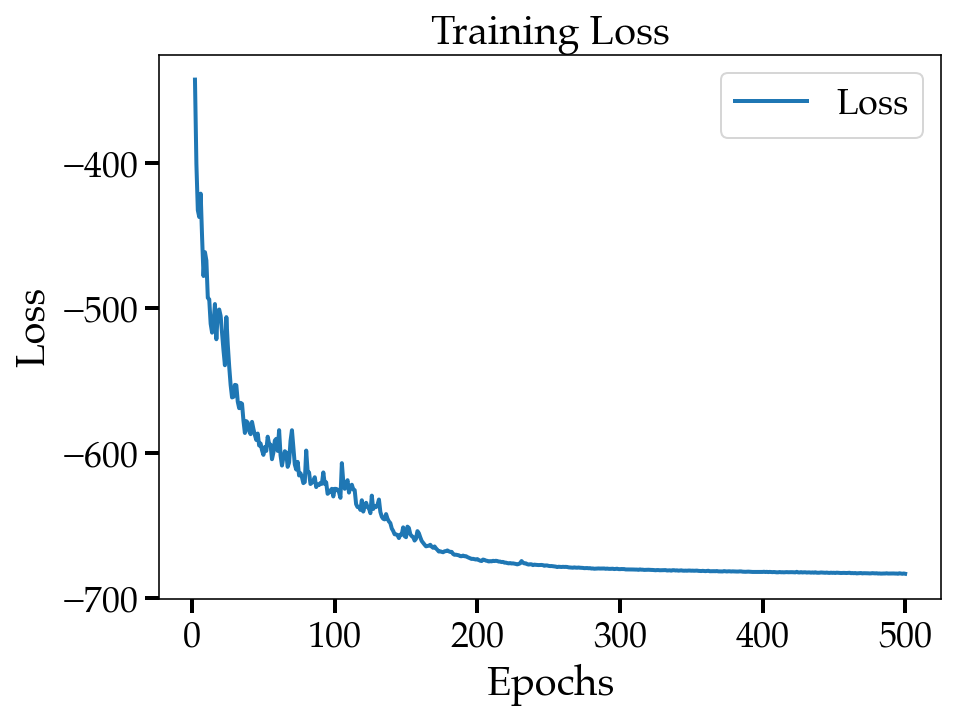

In [13]:
# Assuming you have a list of loss values named "loss_history"
epochs = range(1, len(loss_history) + 1)

# Plot the loss curve
plt.plot(epochs[1:], loss_history[1:], label='Loss')
#plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

loss_folder_path = f"../figures/VAE/{fakes_suffix}/loss_curves"
if not os.path.exists(loss_folder_path):
    os.makedirs(loss_folder_path)
plt.savefig(f'{loss_folder_path}/vae_model_batch_size={batch_size}_epochs={nepochs}_latent_dim={latent_dim}.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
x_test = x_test.astype('float32')

#x_test_mean = np.mean(x_test, axis=0)
#x_test_std = np.std(x_test, axis=0)

x_test_normalized = (x_test - x_train_mean) / x_train_std # x_test or x_train for mean, std?
#x_test_normalized = (x_test - x_test_mean) / x_test_std # x_test or x_train for mean, std?

encoded_data = encoder.predict(x_test_normalized)
decoded_data = vae.predict(x_test_normalized)

# Encode the test data
#encoded_data = encoder.predict(x_test) # VAE not trained on x_test but x_test_normalized so comment out?

# Decode the encoded data
#decoded_data = vae.predict(x_test) # VAE not trained on x_test but x_test_normalized so comment out?

# Evaluate the reconstruction loss
#test_loss = np.mean(np.square(x_test - decoded_data))
test_loss = np.mean(np.square(x_test_normalized - decoded_data))

# Print the test loss
print("Test Loss:", test_loss)

26/26 [==============================] - 0s 1ms/step
Test Loss: feature_amplitude_magn_r                   0.284985
feature_anderson_darling_normal_magn_r     1.601066
feature_beyond_1_std_magn_r                0.945757
feature_beyond_2_std_magn_r                1.578473
feature_cusum_magn_r                       0.846459
                                            ...    
iApMag_iKronMag                            0.315552
zApMag_zKronMag                            0.250364
yApMag_yKronMag                            0.452177
7DCD                                      11.258921
dist/DLR                                   5.442719
Length: 120, dtype: float64


In [15]:
len(x_test_normalized)

815

[137, 582, 782]
https://alerce.online/object/ZTF21aajgdpo
https://alerce.online/object/ZTF21aavozbk
https://alerce.online/object/ZTF21achjmmc


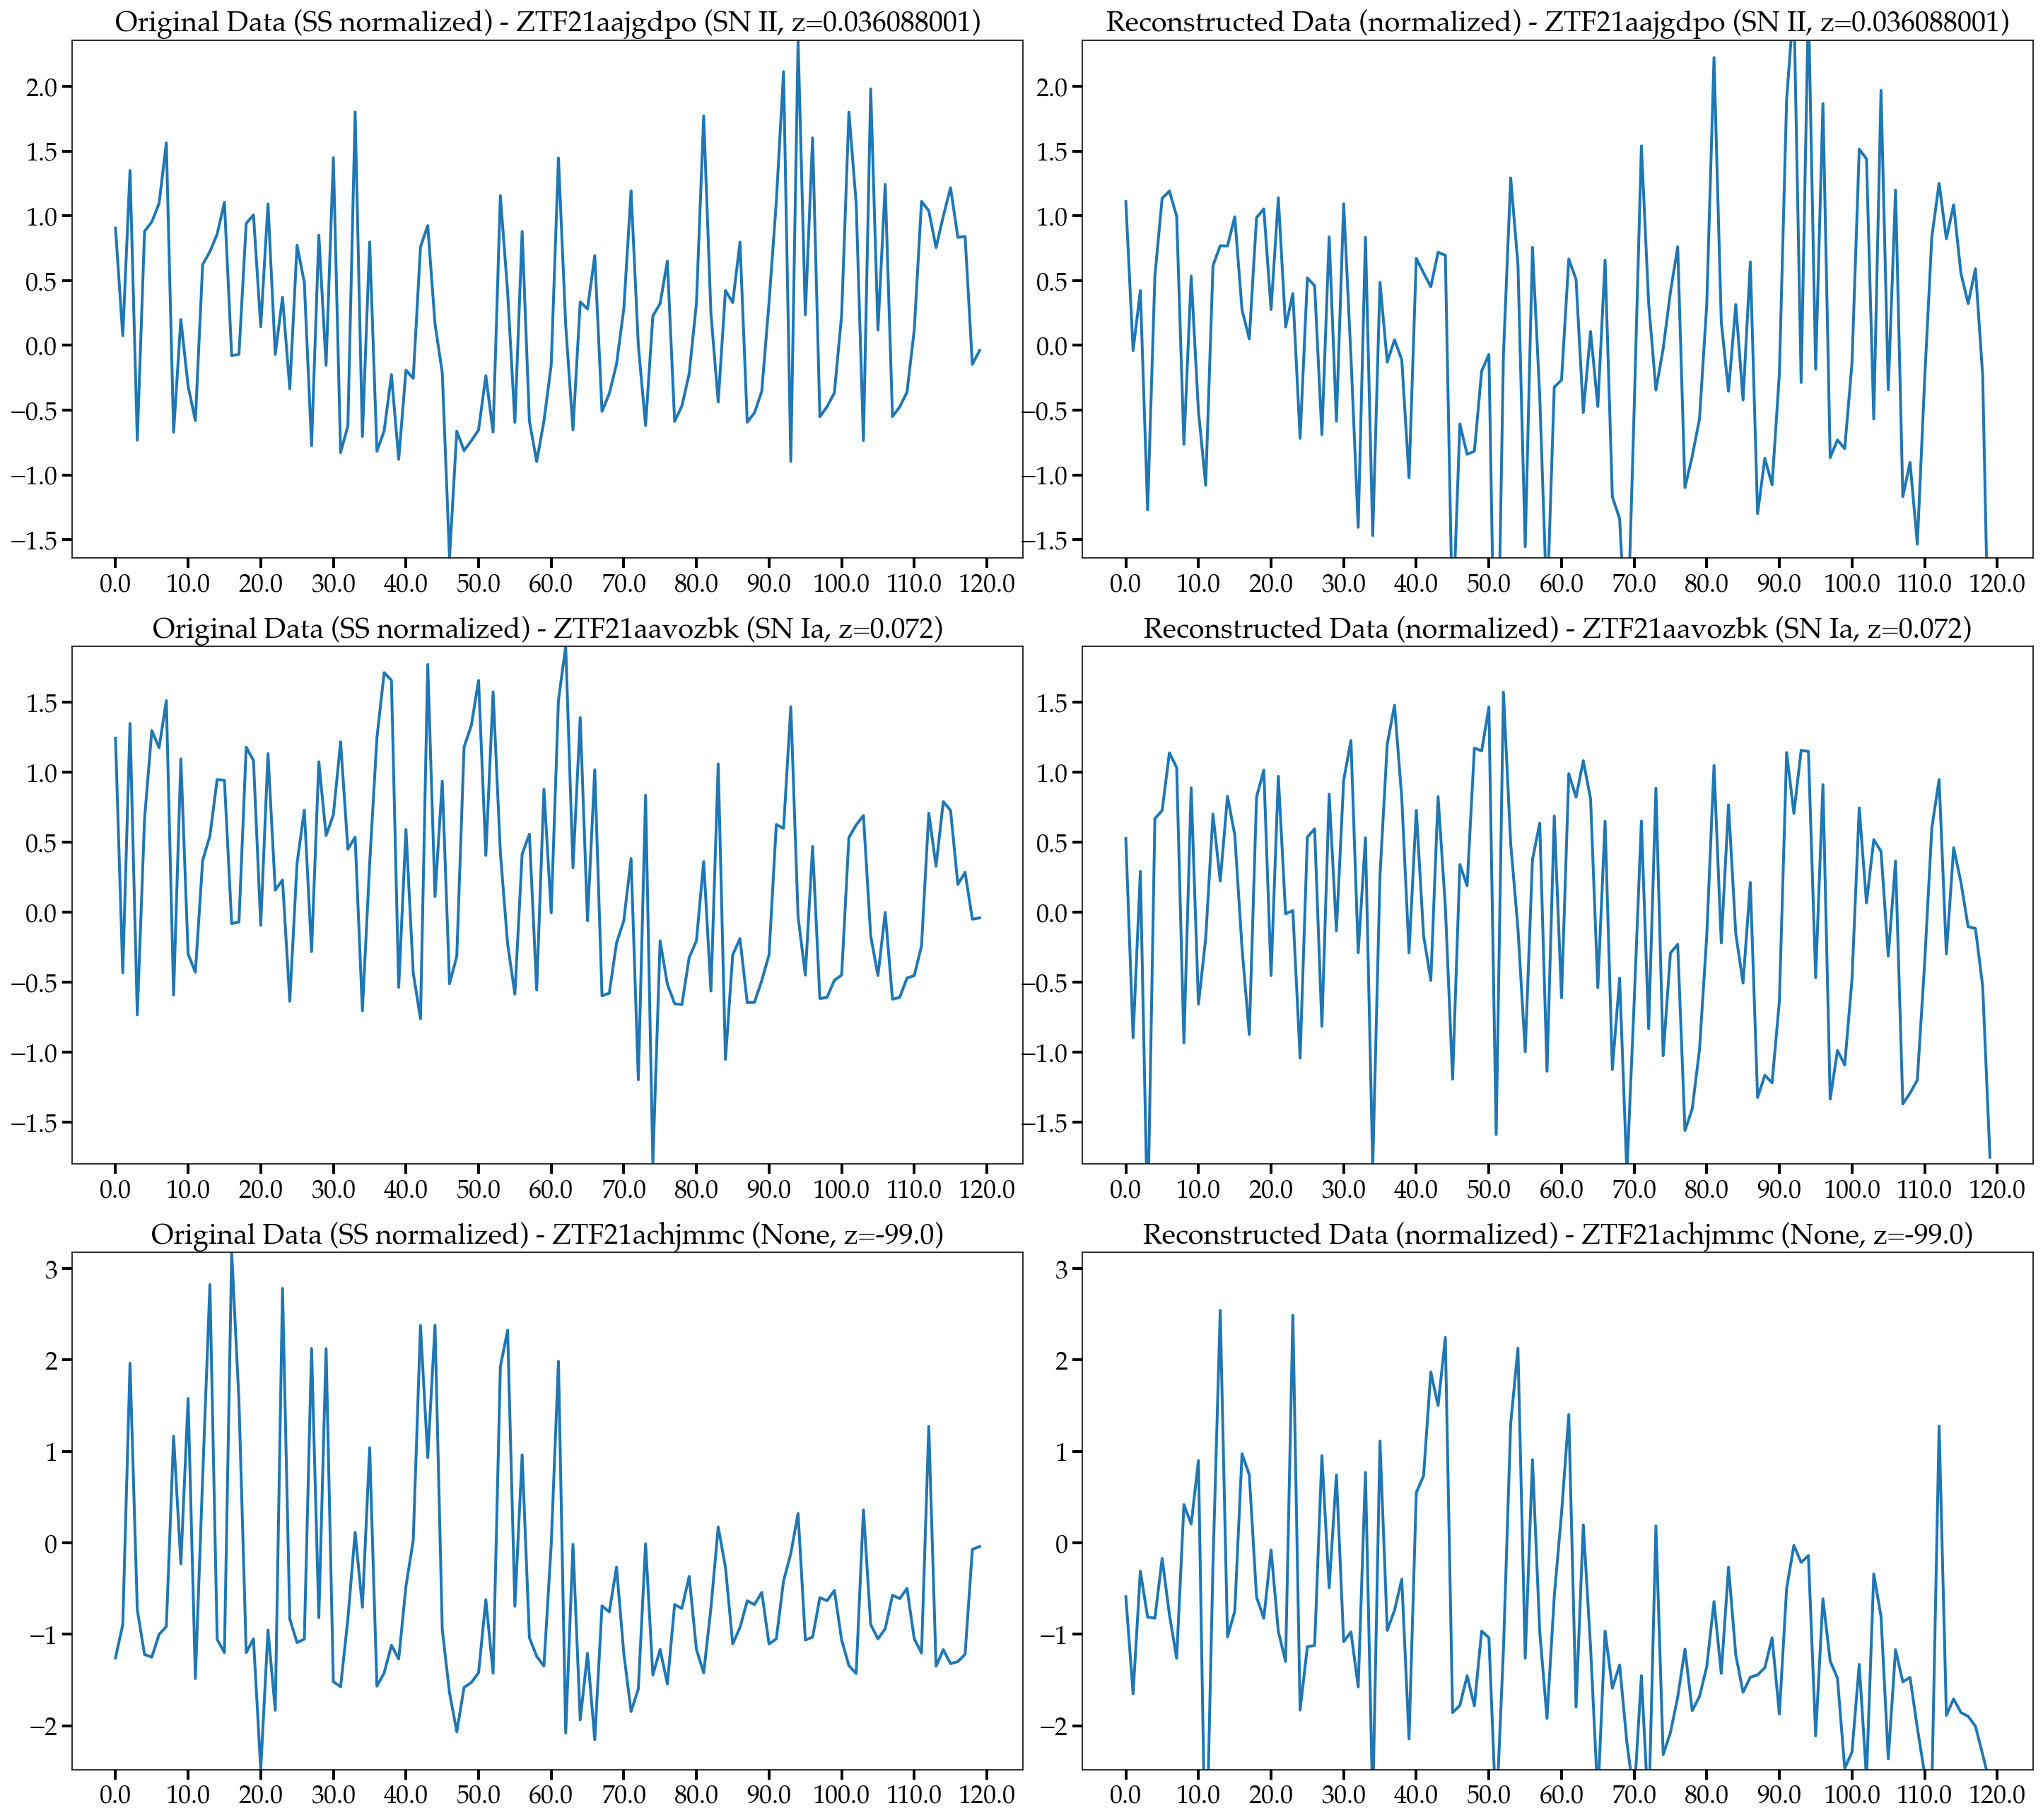

In [16]:
import matplotlib.pyplot as plt
import random

# Select a random sample of data points from x_test
num_samples = 3
random.seed(1)
random_indices = random.sample(range(len(x_test_normalized)), num_samples)
print(random_indices)

# Plot original data and reconstructed data
fig, axes = plt.subplots(num_samples, 2, figsize=(20, 6 * num_samples))
for i, index in enumerate(random_indices):
    try:
        # Plot original data
        y_min, y_max=np.min(x_test_normalized.iloc[index]), np.max(x_test_normalized.iloc[index])
        print(f'https://alerce.online/object/{x_test_normalized.iloc[index].name}')
        axes[i, 0].plot(x_test_normalized.iloc[index])
        axes[i, 0].set_title(f"Original Data (SS normalized) - {x_test_normalized.iloc[index].name} ({x_test_all.iloc[index].tns_cls}, z={x_test_all.iloc[index].spec_z})")
        #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
        #axes[i, 0].set_xticks(np.array(range(0, 120, 20)))
        axes[i, 0].set_xticks(np.array([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.]))
        axes[i, 0].set_xticklabels([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.])
        #axes[i, 0].set_xticklabels(x_test.columns, rotation=90, fontsize=6)
        axes[i, 0].set_ylim([y_min, y_max])  # Set y-scale limits

        # Plot reconstructed data
        axes[i, 1].plot(decoded_data[index])
        axes[i, 1].set_title(f"Reconstructed Data (normalized) - {x_test_normalized.iloc[index].name} ({x_test_all.iloc[index].tns_cls}, z={x_test_all.iloc[index].spec_z})")
        axes[i, 1].set_xticks(np.array([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.]))
        axes[i, 1].set_xticklabels([0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100., 110., 120.])
        #axes[i, 1].set_xticklabels(list(x_test.columns), rotation=90, fontsize=6)
        axes[i, 1].set_ylim([y_min, y_max])  # Set y-scale limits
    except KeyError:
        continue

plt.tight_layout()

ovr_folder_path = f"../figures/VAE/{fakes_suffix}/original_vs_reconstructed"
if not os.path.exists(ovr_folder_path):
    os.makedirs(ovr_folder_path)
plt.savefig(f'{ovr_folder_path}/vae_model_batch_size={batch_size}_epochs={nepochs}_latent_dim={latent_dim}.jpg', dpi=150, bbox_inches='tight')
plt.show()


In [17]:
for f_num, feat in enumerate(x_test_normalized.columns):
    print(f_num, feat)

0 feature_amplitude_magn_r
1 feature_anderson_darling_normal_magn_r
2 feature_beyond_1_std_magn_r
3 feature_beyond_2_std_magn_r
4 feature_cusum_magn_r
5 feature_inter_percentile_range_2_magn_r
6 feature_inter_percentile_range_10_magn_r
7 feature_inter_percentile_range_25_magn_r
8 feature_kurtosis_magn_r
9 feature_linear_fit_slope_magn_r
10 feature_linear_fit_slope_sigma_magn_r
11 feature_magnitude_percentage_ratio_40_5_magn_r
12 feature_magnitude_percentage_ratio_20_5_magn_r
13 feature_mean_magn_r
14 feature_median_absolute_deviation_magn_r
15 feature_percent_amplitude_magn_r
16 feature_median_buffer_range_percentage_10_magn_r
17 feature_median_buffer_range_percentage_20_magn_r
18 feature_percent_difference_magnitude_percentile_5_magn_r
19 feature_percent_difference_magnitude_percentile_10_magn_r
20 feature_skew_magn_r
21 feature_standard_deviation_magn_r
22 feature_stetson_k_magn_r
23 feature_weighted_mean_magn_r
24 feature_anderson_darling_normal_flux_r
25 feature_cusum_flux_r
26 fea

In [18]:
random.sample(range(len(x_test)), num_samples)

[64, 261, 120]

In [19]:
x_test_normalized.iloc[index]

feature_amplitude_magn_r                 -1.257328
feature_anderson_darling_normal_magn_r   -0.892725
feature_beyond_1_std_magn_r               1.963421
feature_beyond_2_std_magn_r              -0.731876
feature_cusum_magn_r                     -1.220879
                                            ...   
iApMag_iKronMag                          -1.320803
zApMag_zKronMag                          -1.298097
yApMag_yKronMag                          -1.218652
7DCD                                     -0.071091
dist/DLR                                 -0.039467
Name: ZTF21achjmmc, Length: 120, dtype: float64

In [20]:
decoded_data[index]

array([-0.5890246 , -1.6494595 , -0.309429  , -0.81115067, -0.8232617 ,
       -0.16997688, -0.7843564 , -1.2622616 ,  0.41823557,  0.20544642,
        0.89865655, -3.7686558 , -0.24024542,  2.5426831 , -1.0294656 ,
       -0.74650127,  0.9747364 ,  0.7443228 , -0.5932759 , -0.824113  ,
       -0.07869706, -0.9674581 , -1.2968559 ,  2.4899302 , -1.8281556 ,
       -1.136235  , -1.1204096 ,  0.9540582 , -0.49114972,  0.7416434 ,
       -1.080901  , -0.97347164, -1.5746025 ,  0.7706864 , -2.878657  ,
        1.1124824 , -0.9581605 , -0.7376919 , -0.39818197, -2.1441715 ,
        0.5501763 ,  0.73276246,  1.868985  ,  1.5008736 ,  2.2460296 ,
       -1.8557397 , -1.7776058 , -1.4543208 , -1.7814989 , -0.96409905,
       -1.0374485 , -3.001635  , -1.1706678 ,  1.3036102 ,  2.1288784 ,
       -1.2603269 ,  0.91097194, -0.97151935, -1.9192163 , -0.58622617,
        0.32178813,  1.4036524 , -1.796461  ,  0.19614154, -1.1394361 ,
       -2.7870193 , -0.96429217, -1.588976  , -1.334868  , -2.18